In [1]:
#Imports
import tensorflow as tf
import pymysql
from astropy.table import Table
import astropy.units as u
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70,Om0=0.3)
import pymysql
import pandas as pd
from matplotlib.colors import LogNorm
import gc
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from IPython.display import clear_output
import scipy
from astropy.nddata import StdDevUncertainty
from tqdm.notebook import tqdm
from astropy.coordinates import SkyCoord
from scipy.stats import ks_2samp
from multiprocess import Pool
from scipy.spatial import KDTree
from scipy.stats import linregress
gpus = tf.config.list_physical_devices('GPU')
import matplotlib as mpl
from sklearn import preprocessing
import matplotlib.transforms as mtrans
from venn import venn
from matplotlib_venn import venn2,venn2_circles
import scipy.ndimage
from astropy.visualization import make_lupton_rgb
mpl.rcParams['text.usetex']=True
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = 'DejaVu Sans'
mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.rm'] = 'DejaVu Sans'
mpl.rcParams['mathtext.it'] = 'DejaVu Sans:italic'
mpl.rcParams['mathtext.bf'] = 'DejaVu Sans:bold'
mpl.rcParams.update(
    {
        'text.usetex': False,
        'font.family': 'sans-serif',
        'mathtext.fontset': 'dejavusans',
    }
)
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['legend.fontsize'] = 14
mpl.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.linewidth'] = 3
plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['ytick.major.size'] = 10
plt.rcParams['ytick.minor.size'] = 5
plt.rcParams['ytick.major.width'] = 2
plt.rcParams['ytick.minor.width'] = 2
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['xtick.minor.width'] = 2
mpl.rcParams['xtick.minor.visible'] = True
mpl.rcParams['ytick.minor.visible'] = True
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['ytick.major.pad'] = 9
mpl.rcParams['ytick.right'] = True
mpl.rcParams['xtick.top'] = True
plt.rcParams['axes.titlesize'] = 50
mpl.rcParams['figure.dpi'] = 500

def histedges_equalN(x, nbin):
    npt = len(x)
    return np.interp(np.linspace(0, npt, nbin + 1),
                     np.arange(npt),
                     np.sort(x))

def binned_mean_ada(x,y,bins):
    xspace = histedges_equalN(x,bins)
    ymeds = []
    yerrs = []
    xspace_plot = []
    xerrs = []
    for i in range(len(xspace)-1):
        xmin = xspace[i]
        xmax = xspace[i+1]
        ys = y[(x>=xmin)&(x<xmax)]
        loc_med = np.mean(ys)
        loc_err = np.std(ys)
        ymeds.append(loc_med)
        yerrs.append(loc_err)
        xspace_plot.append(xspace[i]+((xspace[i+1]-xspace[i])/2))
        xerrs.append((xspace[i+1]-xspace[i])/2)
    return xspace_plot,ymeds,xerrs,yerrs,xspace

def binned_mean(x,y,bins):
    xspace = bins
    ymeds = []
    yerrs = []
    xspace_plot = []
    xerrs = []
    for i in range(len(xspace)-1):
        xmin = xspace[i]
        xmax = xspace[i+1]
        ys = y[(x>=xmin)&(x<xmax)]
        loc_med = np.mean(ys)
        loc_err = np.std(ys)
        ymeds.append(loc_med)
        yerrs.append(loc_err)
        xspace_plot.append(xspace[i]+((xspace[i+1]-xspace[i])/2))
        xerrs.append((xspace[i+1]-xspace[i])/2)
    return xspace_plot,ymeds,xerrs,yerrs,xspace

2024-06-12 02:43:27.576945: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-06-12 02:43:27.577062: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2024-06-12 02:43:27.577123: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (notebook1): /proc/driver/nvidia/version does not exist


In [2]:
#Load in the catalog I made already
df = pd.read_csv('nov3_df.csv',dtype={'objID':object,'companion_objID':object}).drop(columns=['Unnamed: 0'])
df

objID  fiberID  plate    MJD    z_spec  total_mass_med  \
0       587722981734285420      248    278  51900  0.089692        10.85840   
1       587722981734285458      201    278  51900  0.126874        10.48000   
2       587722981737431161      100    282  51658  0.074289        10.34460   
3       587722981741363294      204    287  52023  0.077909        10.85620   
4       587722981741428877      205    287  52023  0.114482        10.76880   
...                    ...      ...    ...    ...       ...             ...   
266302  588848900972413059      453    267  51608  0.142734        10.48630   
266303  588848900972150967      376    267  51608  0.163227        11.24600   
266304  588848900972281999      429    267  51608  0.086682         9.80047   
266305  588848900972282016      420    267  51608  0.142124        11.35250   
266306  588848900972282040      436    267  51608  0.093400        10.97980   

        total_sfr_med          ra      decl  ML_FLUX_1  ...   chi2red  \
0            1.295760  166.740978 -1.096967        NaN  ...  2.746083   
1            0.584156  166.844782 -1.077797        NaN  ...  0.001733   
2           -0.192857  174.035712 -1.069110        NaN  ...  0.011108   
3           -0.715957  182.925259 -1.092357        NaN  ...  0.001887   
4            0.932583  183.028622 -1.072705        NaN  ...  0.493927   
...               ...         ...       ...        ...  ...       ...   
266302       0.690242  147.968391  0.764449        NaN  ...  0.008069   
266303      -0.632102  147.475026  0.804604        NaN  ...  0.019272   
266304       0.110168  147.671013  0.667271        NaN  ...  0.014689   
266305      -0.457143  147.700504  0.829560        NaN  ...  0.279267   
266306      -0.991367  147.728943  0.769709        NaN  ...  0.024175   

         max_sep           rp           r2        delv    mratio  \
0       0.331887  1069.847004  1491.469591  215.966603  3.455222   
1       0.244799          NaN          NaN         NaN       NaN   
2       0.393601          NaN          NaN         NaN       NaN   
3       0.376898  2493.172627          NaN  234.458607  3.313805   
4       0.267514          NaN          NaN         NaN       NaN   
...          ...          ...          ...         ...       ...   
266302  0.221511   958.692973  1049.360300  186.790828  0.319946   
266303  0.198165          NaN          NaN         NaN       NaN   
266304  0.342218          NaN          NaN         NaN       NaN   
266305  0.222310  1164.006649          NaN   98.170058  2.348081   
266306  0.320077   886.699132   991.374218   41.401739  1.482583   

           companion_objID  pair_ctrl  pair_ctrl_120  Halpha_ew  
0       587748928161185966          1              1 -12.089050  
1                      NaN          1              1 -13.843612  
2                      NaN          1              1  -7.501599  
3       587722982278365293          1              1  -1.031528  
4                      NaN          1              1 -55.334431  
...                    ...        ...            ...        ...  
266302  587725076069548211          1              1 -31.611340  
266303                 NaN          1              1  -0.473317  
266304                 NaN          1              1 -30.711863  
266305  587725076069548211          1              1   1.141745  
266306  587725076069679184          1              1   0.711998  

[266307 rows x 47 columns]

In [3]:
pair_ctrl_120 = np.load('control_flag_120kpc.npz')['control_flag_120kpc']
df['pair_ctrl_120'] = pair_ctrl_120

In [4]:
kpc_per_arcsec = cosmo.kpc_proper_per_arcmin(0.103).value/60. #kpc/arcsec
kpc_per_arcsec*30

56.7930354529509

(array([1.00000e+00, 0.00000e+00, 0.00000e+00, 3.00000e+00, 6.00000e+00,
        2.20000e+01, 2.50000e+01, 2.80000e+01, 8.30000e+01, 4.42000e+02,
        6.81120e+04, 1.87811e+05, 1.68000e+02, 8.00000e+00, 6.00000e+00,
        8.00000e+00, 4.00000e+00, 5.00000e+00, 3.00000e+00, 9.00000e+00,
        5.00000e+00, 8.00000e+00, 3.00000e+00, 1.00000e+00, 3.00000e+00]),
 array([-3.36577840e+00, -3.05949754e+00, -2.75321669e+00, -2.44693583e+00,
        -2.14065498e+00, -1.83437412e+00, -1.52809326e+00, -1.22181241e+00,
        -9.15531552e-01, -6.09250696e-01, -3.02969840e-01,  3.31101600e-03,
         3.09591872e-01,  6.15872728e-01,  9.22153584e-01,  1.22843444e+00,
         1.53471530e+00,  1.84099615e+00,  2.14727701e+00,  2.45355786e+00,
         2.75983872e+00,  3.06611958e+00,  3.37240043e+00,  3.67868129e+00,
         3.98496214e+00,  4.29124300e+00]),
 <BarContainer object of 25 artists>)

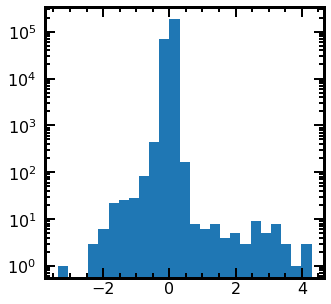

In [5]:
fig,axs = plt.subplots(figsize=[5,5])
mask = (df['total_mass_med']>0)&(df['logmass']>8)&(df['z_spec']>0.005)
plt.hist(df['logmass'][mask]-df['total_mass_med'][mask],log=True,bins=25)

In [6]:
print(np.median(df['logmass'][mask]-df['total_mass_med'][mask]))
print(np.std(df['logmass'][mask]-df['total_mass_med'][mask]))
a = np.abs(df['logmass'][mask]-df['total_mass_med'][mask])
print(len(a[a<0.1])/len(a))

0.02937799999999946
0.07722340045385624
0.8791224626505273


In [10]:
post_merger_df = df[df['PM']==1]
post_merger_df[['objID','fiberID','plate','MJD','z_spec','ra','decl']].to_csv('post_merger_df.csv',index=False)

In [9]:
# df_to_add = df.drop(columns=['ML_FLUX_1', 'ML_EXP_P1', 'p_i', 'L_X_e'])
# df_to_add

objID  fiberID  plate    MJD    z_spec  total_mass_med  \
0       587722981734285420      248    278  51900  0.089692        10.85840   
1       587722981734285458      201    278  51900  0.126874        10.48000   
2       587722981737431161      100    282  51658  0.074289        10.34460   
3       587722981741363294      204    287  52023  0.077909        10.85620   
4       587722981741428877      205    287  52023  0.114482        10.76880   
...                    ...      ...    ...    ...       ...             ...   
266302  588848900972413059      453    267  51608  0.142734        10.48630   
266303  588848900972150967      376    267  51608  0.163227        11.24600   
266304  588848900972281999      429    267  51608  0.086682         9.80047   
266305  588848900972282016      420    267  51608  0.142124        11.35250   
266306  588848900972282040      436    267  51608  0.093400        10.97980   

        total_sfr_med          ra      decl  PM  ...   chi2red   max_sep  \
0            1.295760  166.740978 -1.096967 NaN  ...  2.746083  0.331887   
1            0.584156  166.844782 -1.077797 NaN  ...  0.001733  0.244799   
2           -0.192857  174.035712 -1.069110 NaN  ...  0.011108  0.393601   
3           -0.715957  182.925259 -1.092357 NaN  ...  0.001887  0.376898   
4            0.932583  183.028622 -1.072705 NaN  ...  0.493927  0.267514   
...               ...         ...       ...  ..  ...       ...       ...   
266302       0.690242  147.968391  0.764449 NaN  ...  0.008069  0.221511   
266303      -0.632102  147.475026  0.804604 NaN  ...  0.019272  0.198165   
266304       0.110168  147.671013  0.667271 NaN  ...  0.014689  0.342218   
266305      -0.457143  147.700504  0.829560 NaN  ...  0.279267  0.222310   
266306      -0.991367  147.728943  0.769709 NaN  ...  0.024175  0.320077   

                 rp           r2        delv    mratio     companion_objID  \
0       1069.847004  1491.469591  215.966603  3.455222  587748928161185966   
1               NaN          NaN         NaN       NaN                 NaN   
2               NaN          NaN         NaN       NaN                 NaN   
3       2493.172627          NaN  234.458607  3.313805  587722982278365293   
4               NaN          NaN         NaN       NaN                 NaN   
...             ...          ...         ...       ...                 ...   
266302   958.692973  1049.360300  186.790828  0.319946  587725076069548211   
266303          NaN          NaN         NaN       NaN                 NaN   
266304          NaN          NaN         NaN       NaN                 NaN   
266305  1164.006649          NaN   98.170058  2.348081  587725076069548211   
266306   886.699132   991.374218   41.401739  1.482583  587725076069679184   

       pair_ctrl  pair_ctrl_120  Halpha_ew  
0              1              1 -12.089050  
1              1              1 -13.843612  
2              1              1  -7.501599  
3              1              1  -1.031528  
4              1              1 -55.334431  
...          ...            ...        ...  
266302         1              1 -31.611340  
266303         1              1  -0.473317  
266304         1              1 -30.711863  
266305         1              1   1.141745  
266306         1              1   0.711998  

[266307 rows x 43 columns]

In [10]:
#print([key for key in df_to_add.keys()])

['objID', 'fiberID', 'plate', 'MJD', 'z_spec', 'total_mass_med', 'total_sfr_med', 'ra', 'decl', 'PM', 'DN', 'CNN', 'd_a', 'specClass', 'agn_sn', 'new_K01_flag', 'new_K03_flag', 'new_S06_flag', 'Halpha_flux', 'Hbeta_flux', 'NII_flux', 'OIII_5007_flux', 'OI_flux', 'SII_6717_flux', 'sigma_balmer', 'sigma_forbidden', 'W1', 'W1_sn', 'W2', 'W2_sn', 'BLR', 'logmass', 'logmass_err', 'chi2red', 'max_sep', 'rp', 'r2', 'delv', 'mratio', 'companion_objID', 'pair_ctrl', 'pair_ctrl_120', 'Halpha_ew']


In [11]:
#df_to_add.to_csv('dr7_bickley2024.csv')

median delta 0 = -0.15438701986881398
median delta 1 = -0.21951168850606706
median delta 2 = -0.12511832885235208
stopping r = 3 with pval m = 0.9999999976400813 and pval z = 0.8988262050047495 at batch 2
median delta 3 = -0.16565743247302223
median delta 4 = -0.18798330021889598
median delta 5 = -0.200481545968902


/tmp/ipykernel_67/2550029671.py:115: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data_ext = np.array([calc_del_lx(r) for r in range(len(rp_space_ext)-1)])
/tmp/ipykernel_67/2550029671.py:120: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  tLX = np.array([i for i in data_ext[:,5]])
/tmp/ipykernel_67/2550029671.py:123: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=objec

median delta PM = 0.14819475790292103
[-0.23433882145360485, 0.13441862406654081, -0.24967125531843237, 0.6774799168636534, -0.2997944026565449, -0.48993891797974953, 0.3489591441092088, -0.2590673649867554, 0.35080503476049785, 0.4403921780045792, -0.3312440193144752, 0.5305823238540341, 0.23555198478277362, -0.4554463418020518, 0.5517907406143792, -0.6138259641642421, 0.7304017190261476, 0.08621025505632929, -0.734539049931378, 0.264588311707989, 0.16726654415980136, -0.5430019806964879, 0.1288162486763369, 0.3344607369374444, 0.16793516523532048, -0.10550494463837623, 0.6268923241113669, 0.22456546720479764, 0.7415546697643549, 0.9948591974244039, -0.3991242216200348, -0.06215314604410338, 1.3681567450777763, 0.08188430295865601, 0.5110738389358076, 0.15494327770809946, 0.1414462380977426, 0.39143182906672536, 0.08495817701790997, 0.4661960993181964, -0.14117793161116765, -0.21853254857691695, 1.273460318218902, -0.10826055450025507, 0.15523896721612118, -0.32971872310420736, 0.1587

/tmp/ipykernel_67/2550029671.py:126: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data_pm = np.array(calc_del_lx_pm())


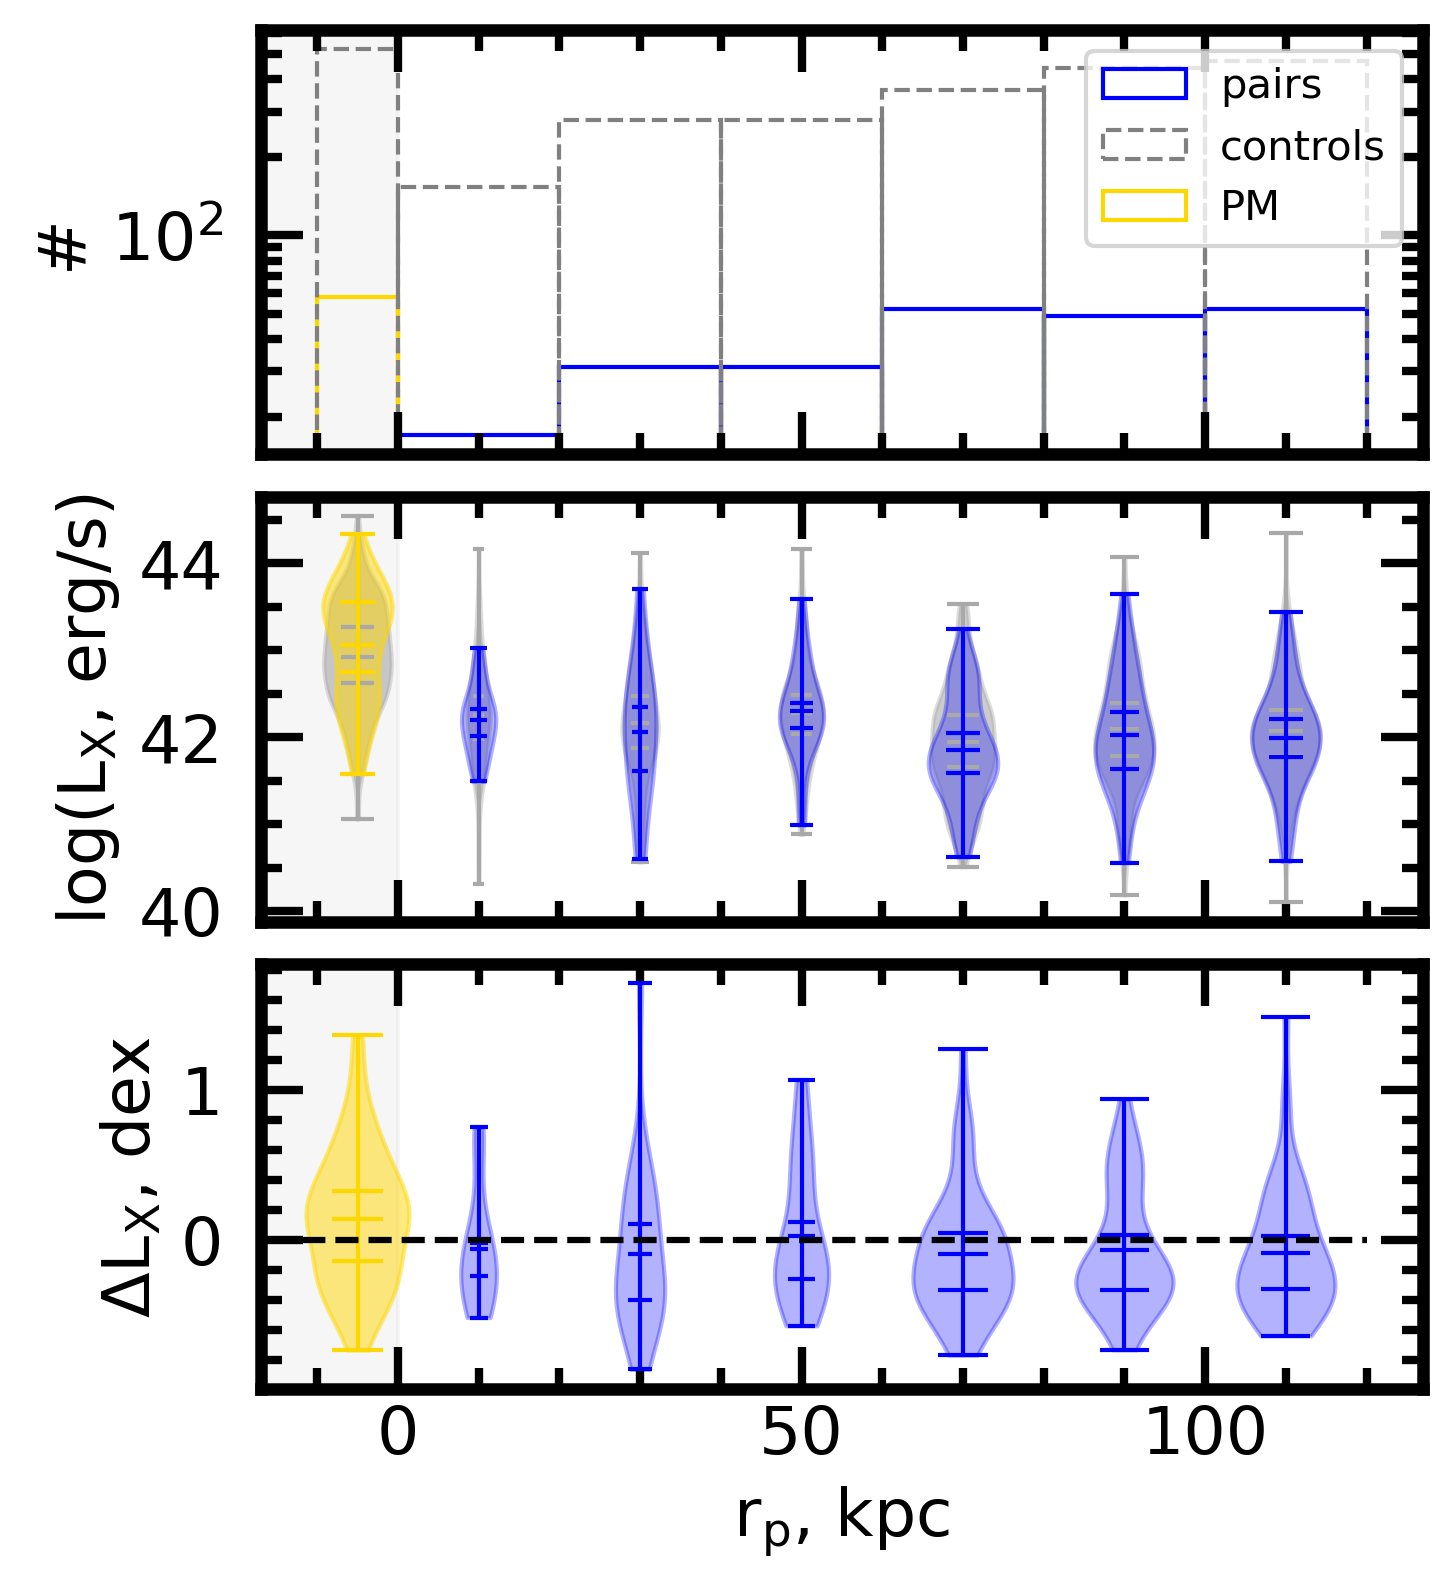

In [6]:
#now doing the luminosity enhancement for pairs and post-mergers in bins of rp.
rp_space_ext = np.linspace(0,120,7)
def calc_del_lx(r):
    #print('doing {}'.format(str(r)))
    tar_pool = df[(df['rp']>=rp_space_ext[r])&(df['rp']<rp_space_ext[r+1])&(df['L_X_e']>0)&(df['z_spec']>0.005)&(df['logmass']>8)]
    ctrl_pool = df[(df['pair_ctrl_120']==1)&(df['L_X_e']>0)&(df['CNN']<0.1)&(df['z_spec']>0.005)&(df['logmass']>8)]
    for batch in range(5):
        deltas = []
        ngrows = []
        tLXs = []
        cLX_all = []
        cM_all = []
        cz_all = []
        nctrls = 0
        for ind,row in tar_pool.iterrows():
            tLX1 = row['L_X_e']
            growth = 0
            found = False
            while not found:
                cs = ctrl_pool[(ctrl_pool['logmass']>row['logmass']-0.1*(1+growth))&(ctrl_pool['logmass']<row['logmass']+0.1*(1+growth))&(ctrl_pool['z_spec']>row['z_spec']-0.05*(1+growth))&(ctrl_pool['z_spec']<row['z_spec']+0.05*(1+growth))]
                if len(cs)<5+batch:
                    growth += 1
                else:
                    break
            #Choose the 5 best within cs.
            cpmean_m = np.mean(cs['logmass'])
            cpstd_m = np.std(cs['logmass'])
            m_td = ((cs['logmass']-cpmean_m)/cpstd_m).tolist()
            cpmean_z = np.mean(cs['z_spec'])
            cpstd_z = np.std(cs['z_spec'])
            z_td = ((cs['z_spec']-cpmean_z)/cpstd_z).tolist()
            treedat = np.array([[i,j] for i,j in zip(z_td,m_td)])
            tree = KDTree(treedat)
            match_inds = tree.query([(row['z_spec']-cpmean_z)/cpstd_z,(row['logmass']-cpmean_m)/cpstd_m],k=5+batch)[1]
            cs = cs.iloc[match_inds]
            cLXs = cs['L_X_e'].values.tolist()
            cMs = cs['logmass'].values.tolist()
            czs = cs['z_spec'].values.tolist()
            ngrows.append(growth)
            nctrls += len(cLXs)
            delta = tLX1-np.mean(cLXs)
            deltas.append(delta)
            tLXs.append(tLX1)
            cLX_all += cLXs
            cM_all += cMs
            cz_all += czs
        tar_masses = tar_pool['logmass'].values.tolist()
        tar_zs = tar_pool['z_spec'].values.tolist()
        pval_m = ks_2samp(tar_masses,cM_all)[1]
        pval_z = ks_2samp(tar_zs,cz_all)[1]
        if pval_m<0.9 or pval_z<0.9:
            print('stopping r = {} with pval m = {} and pval z = {} at batch {}'.format(str(r),str(pval_m),str(pval_z),str(batch)))
            break
    med_delta = np.median(deltas)
    print('median delta {} = {}'.format(r,med_delta))
    del_err = np.std(deltas)/np.sqrt(len(deltas))
    return [deltas,del_err,ngrows,nctrls,len(tar_pool),tLXs,cLX_all]

def calc_del_lx_pm():
    #print('doing PM')
    tar_pool = df[(df['PM']==1)&(df['L_X_e']>0)&(df['z_spec']>0.005)&(df['logmass']>8)]
    ctrl_pool = df[(df['CNN']<0.1)&(df['L_X_e']>0)&(df['pair_ctrl_120']==1)&(df['z_spec']>0.005)&(df['logmass']>8)]
    for batch in range(5):
        deltas = []
        ngrows = []
        tLXs = []
        cLX_all = []
        cM_all = []
        cz_all = []
        nctrls = 0
        for ind,row in tar_pool.iterrows():
            tLX1 = row['L_X_e']
            growth = 0
            found = False
            while not found:
                cs = ctrl_pool[(ctrl_pool['logmass']>row['logmass']-0.1*(1+growth))&(ctrl_pool['logmass']<row['logmass']+0.1*(1+growth))&(ctrl_pool['z_spec']>row['z_spec']-0.05*(1+growth))&(ctrl_pool['z_spec']<row['z_spec']+0.05*(1+growth))]
                if len(cs)<5+batch:
                    growth += 1
                else:
                    break
            #Choose the 5 best within cs.
            cpmean_m = np.mean(cs['logmass'])
            cpstd_m = np.std(cs['logmass'])
            m_td = ((cs['logmass']-cpmean_m)/cpstd_m).tolist()
            cpmean_z = np.mean(cs['z_spec'])
            cpstd_z = np.std(cs['z_spec'])
            z_td = ((cs['z_spec']-cpmean_z)/cpstd_z).tolist()
            treedat = np.array([[i,j] for i,j in zip(z_td,m_td)])
            tree = KDTree(treedat)
            match_inds = tree.query([(row['z_spec']-cpmean_z)/cpstd_z,(row['logmass']-cpmean_m)/cpstd_m],k=5+batch)[1]
            cs = cs.iloc[match_inds]
            cLXs = cs['L_X_e'].values.tolist()
            cMs = cs['logmass'].values.tolist()
            czs = cs['z_spec'].values.tolist()
            ngrows.append(growth)
            nctrls += len(cLXs)
            delta = tLX1-np.mean(cLXs)
            deltas.append(delta)
            tLXs.append(tLX1)
            cLX_all += cLXs
            cM_all += cMs
            cz_all += czs
        tar_masses = tar_pool['logmass'].values.tolist()
        tar_zs = tar_pool['z_spec'].values.tolist()
        pval_m = ks_2samp(tar_masses,cM_all)[1]
        pval_z = ks_2samp(tar_zs,cz_all)[1]
        if pval_m<0.9 or pval_z<0.9:
            print('stopping r = PM with pval m = {} and pval z = {} at batch {}'.format(str(pval_m),str(pval_z),str(batch)))
            break
    med_delta = np.median(deltas)
    print('median delta PM = {}'.format(med_delta))
    del_err = np.std(deltas)/np.sqrt(len(deltas))
    return [deltas,del_err,ngrows,nctrls,len(tar_pool),tLXs,cLX_all]

data_ext = np.array([calc_del_lx(r) for r in range(len(rp_space_ext)-1)])
deltas = data_ext[:,0]
errs = data_ext[:,1]
ncs = data_ext[:,3]
ngs = data_ext[:,4]
tLX = np.array([i for i in data_ext[:,5]])
#tLXe = np.array([np.std(i) for i in data_ext[:,5]])/np.sqrt(np.array([len(i) for i in data_ext[:,5]]))

cLX = np.array([i for i in data_ext[:,6]])
#cLXe = np.array([np.std(i) for i in data_ext[:,6]])/np.sqrt(np.array([len(i) for i in data_ext[:,6]]))

data_pm = np.array(calc_del_lx_pm())
del_pm = data_pm[0]
err_pm = data_pm[1]
print(del_pm,err_pm,err_pm*np.sqrt(len(del_pm)))
nc_pm = data_pm[3]
ng_pm = data_pm[4]
tLX_pm = data_pm[5]
#tLXe_pm = np.std(data_pm[5])/np.sqrt(len(data_pm[5]))
tLX_pm_c = data_pm[6]
#tLXe_pm_c = np.std(data_pm[6])/np.sqrt(len(data_pm[6]))

rp_space_plot_ext = rp_space_ext[:-1]+10

fig,axs = plt.subplots(3,1,figsize=[5,6],dpi=300,sharex=True)
axs.flatten()[0].axvspan(-40,0,alpha=0.2, color='lightgray')
axs.flatten()[1].axvspan(-40,0,alpha=0.2, color='lightgray')
axs.flatten()[2].axvspan(-40,0,alpha=0.2, color='lightgray')
plt.xlim(-17,127)
#panel 1: number of galaxies & agn in each bin
axs.flatten()[0].bar(rp_space_plot_ext,ngs,color='blue',edgecolor='blue',width=20,label='pairs',log=True,fill=False)
axs.flatten()[0].bar(rp_space_plot_ext,ncs,color='gray',edgecolor='gray',width=20,linestyle='dashed',label='controls',log=True,fill=False)
axs.flatten()[0].bar(-5,ng_pm,color='gold',edgecolor='gold',width=10,label='PM',log=True,fill=False)
axs.flatten()[0].bar(-5,nc_pm,color='gray',edgecolor='gray',linestyle='dashed',width=10,log=True,fill=False)
axs.flatten()[0].set_ylabel('#')
#panel 2: AGN luminosities in each bin
parts = axs.flatten()[1].violinplot(cLX,rp_space_plot_ext,points=100,widths=0.1*np.array([len(i)/np.std(i) for i in cLX])/(ncs/ngs),showmeans=True,showextrema=True,quantiles=[[0.3173,0.6827] for i in range(len(cLX))])#,label='controls')
for pc in parts['bodies']:
    pc.set_facecolor('gray')
    pc.set_edgecolor('darkgray')
    pc.set_alpha(0.4)
for partname in ('cbars', 'cmins', 'cmaxes', 'cquantiles', 'cmeans'):
    vp = parts[partname]
    vp.set_edgecolor("darkgray")
    vp.set_linewidth(1)
parts = axs.flatten()[1].violinplot(tLX,rp_space_plot_ext,widths=0.1*np.array([len(i)/np.std(i) for i in tLX]),showmeans=True,showextrema=True,quantiles=[[0.3173,0.6827] for i in range(len(tLX))])#,label='pairs')
for pc in parts['bodies']:
    pc.set_facecolor('blue')
    pc.set_edgecolor('blue')
    pc.set_alpha(0.3)
for partname in ('cbars', 'cmins', 'cmaxes', 'cquantiles', 'cmeans'):
    vp = parts[partname]
    vp.set_edgecolor("blue")
    vp.set_linewidth(1)
axs.flatten()[0].legend(loc='upper right',fontsize=10)
parts = axs.flatten()[1].violinplot(tLX_pm_c,[-5],widths=0.1*np.array([len(tLX_pm_c)/np.std(tLX_pm_c)])/10,showmeans=True,showextrema=True,quantiles=[0.3173,0.6827])
for pc in parts['bodies']:
    pc.set_facecolor('gray')
    pc.set_edgecolor('darkgray')
    pc.set_alpha(0.4)
for partname in ('cbars', 'cquantiles', 'cmins', 'cmaxes', 'cmeans'):
    vp = parts[partname]
    vp.set_edgecolor("darkgray")
    vp.set_linewidth(1)
axs.flatten()[1].set_ylabel('log($\mathrm{L_{X}}$, erg/s)')
parts = axs.flatten()[1].violinplot(tLX_pm,[-5],widths=0.1*np.array([len(tLX_pm)/np.std(tLX_pm)]),showmeans=True,showextrema=True,quantiles=[0.3173,0.6827])#,label='PM')
for pc in parts['bodies']:
    pc.set_facecolor('gold')
    pc.set_edgecolor('gold')
    pc.set_alpha(0.5)
for partname in ('cbars', 'cquantiles', 'cmins', 'cmaxes', 'cmeans'):
    vp = parts[partname]
    vp.set_edgecolor("gold")
    vp.set_linewidth(1)

#panel 3: excess calcs
parts = axs.flatten()[2].violinplot(deltas,rp_space_plot_ext,widths=0.1*np.array([len(i)/np.std(i) for i in deltas]),showmeans=True,showextrema=True,quantiles=[[0.3173,0.6827] for i in range(len(deltas))])
for pc in parts['bodies']:
    pc.set_facecolor('blue')
    pc.set_edgecolor('blue')
    pc.set_alpha(0.3)
for partname in ('cbars', 'cquantiles', 'cmins', 'cmaxes', 'cmeans'):
    vp = parts[partname]
    vp.set_edgecolor("blue")
    vp.set_linewidth(1)
parts = axs.flatten()[2].violinplot(del_pm,[-5],widths=0.1*np.array([len(del_pm)/np.std(del_pm)]),showmeans=True,showextrema=True,quantiles=[0.3173,0.6827])
for pc in parts['bodies']:
    pc.set_facecolor('gold')
    pc.set_edgecolor('gold')
    pc.set_alpha(0.5)
for partname in ('cbars', 'cquantiles', 'cmins', 'cmaxes', 'cmeans'):
    vp = parts[partname]
    vp.set_edgecolor("gold")
    vp.set_linewidth(1)
axs.flatten()[2].hlines(0,-20,120,linestyle='dashed',color='black',label='no excess')
axs.flatten()[2].set_ylabel('$\mathrm{\Delta L_{X}}$, dex')
axs.flatten()[2].set_xlabel('r$\mathrm{_{p}}$, kpc')
#plt.tight_layout()
plt.subplots_adjust(hspace=0.1)
plt.show()

[  0.  20.  40.  60.  80. 100. 120.]
doing 3doing 1doing 2doing 0doing 4doing 5





1076
16352273

2847
3643
4011
max 10 controls per target
max 10 controls per target
max 10 controls per targetmax 10 controls per targetmax 10 controls per target


max 10 controls per target


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

saving data for r = 0
316 3160
determining AGN statuses
aft = 0.025645296307553633
aft_err = 0.006287874493068995
afc = 0.024347021642830646
afc_err = 0.0019387065120502814
exc = 1.0533237569575695
exc_err = 0.32481434490294325
saving data for r = 1
485 4850
determining AGN statuses
aft = 0.0356883765003686
aft_err = 0.005956432569221879
afc = 0.019783318715682507
afc_err = 0.0014139197186368564
exc = 1.8039630768359374
exc_err = 0.23837149149009793
saving data for r = 2
629 6290
determining AGN statuses
aft = 0.02576922847591201
aft_err = 0.004467260814965417
afc = 0.025116696070853206
afc_err = 0.0013951382666016353
exc = 1.0259800255263685
exc_err = 0.22890265476360616
saving data for r = 3
799 7990
determining AGN statuses
aft = 0.017678161067333775
aft_err = 0.0032965301749528935
afc = 0.02163580624619932
afc_err = 0.0011509287247932463
exc = 0.8170789138232014
exc_err = 0.23967027742065347
saving data for r = 4
1089 10890
determining AGN statuses
aft = 0.020410310591235548
aft_er

  0%|          | 0/10 [00:00<?, ?it/s]

ctrl pool length 213146
ctrl pool length 212223
ctrl pool length 211300
ctrl pool length 210377
ctrl pool length 209454
ctrl pool length 208531
ctrl pool length 207608
ctrl pool length 206685
ctrl pool length 205762
ctrl pool length 204839
saving data for r = PM
923 9230
determining AGN statuses
aft = 0.06494766978614863
aft_err = 0.005735666574977696
afc = 0.037090901056732295
afc_err = 0.0013909467012261064
exc = 1.751040496072287
exc_err = 0.12581314469954166


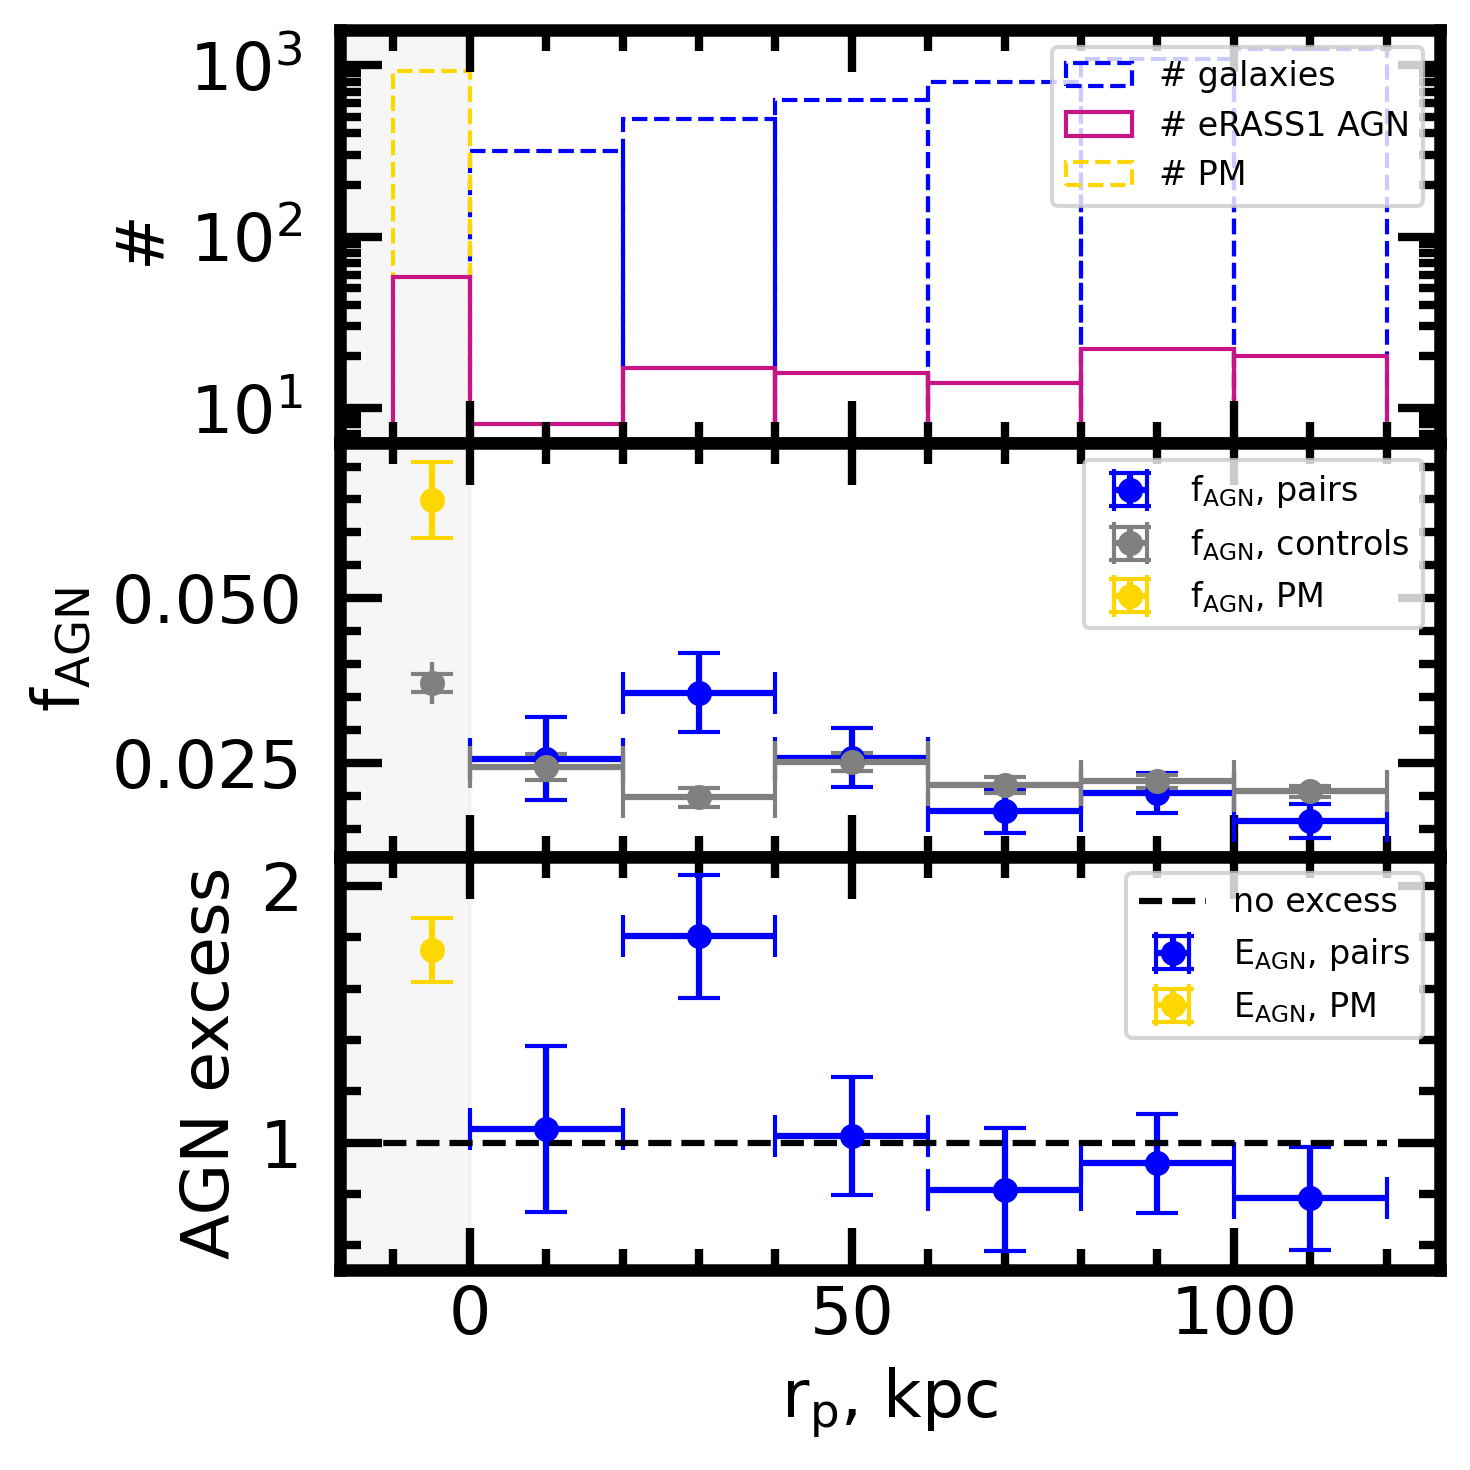

In [8]:
def calc_exc_ext_strict(r):
    print('doing {}'.format(str(r)))
    tar_pool = df[(df['rp']>=rp_space_ext[r])&(df['rp']<rp_space_ext[r+1])&(df['logmass']>8)&(df['z_spec']>0.005)&~(df['PM']==1)]
    print(len(tar_pool))
    ctrl_pool = df[(df['pair_ctrl_120']==1)&(df['CNN']<0.1)&(df['logmass']>8)&(df['z_spec']>0.005)]
    cpmean_m = np.mean(ctrl_pool['logmass'])
    cpstd_m = np.std(ctrl_pool['logmass'])
    m_td = ((ctrl_pool['logmass']-cpmean_m)/cpstd_m).tolist()
    cpmean_z = np.mean(ctrl_pool['z_spec'])
    cpstd_z = np.std(ctrl_pool['z_spec'])
    z_td = ((ctrl_pool['z_spec']-cpmean_z)/cpstd_z).tolist()
    treedat = np.array([[i,j] for i,j in zip(z_td,m_td)])
    tree = KDTree(treedat)
    selected = np.zeros(len(ctrl_pool))
    tar_data = []
    ctrl_data = []
    ctrl_samp = pd.DataFrame({},columns=[key for key in df.keys()])
    companion_samp = pd.DataFrame({},columns=[key for key in df.keys()])
    tar_samp = pd.DataFrame({},columns=[key for key in df.keys()])
    max_cpt = len(ctrl_pool)//len(tar_pool)
    max_cpt = max_cpt if max_cpt<10 else 10
    print('max {} controls per target'.format(str(max_cpt)))
    for batch in tqdm(range(max_cpt)):
        ctrl_data_prev = ctrl_data
        ctrl_samp_prev = ctrl_samp
        tar_data_prev = tar_data
        avoid_IDs = []
        for ind,row in tar_pool.iterrows():
            companion = df[(df['objID']==row['companion_objID'])].iloc[0]
            if row[0] in avoid_IDs or companion['companion_objID']!=row['objID']: #strict modification checking for mutual companionship
                pass
            else:
                found_c1 = False
                ki=1
                while not found_c1:
                    if ki==1:
                        match_ind = tree.query([(row['z_spec']-cpmean_z)/cpstd_z,(row['logmass']-cpmean_m)/cpstd_m],k=ki)[1]
                    else:
                        match_ind = tree.query([(row['z_spec']-cpmean_z)/cpstd_z,(row['logmass']-cpmean_m)/cpstd_m],k=ki)[1][-1]
                    if selected[match_ind]==1:
                        ki += 1
                    else:
                        match = ctrl_pool.iloc[match_ind]
                        found_c1 = True
                selected[ctrl_pool['objID']==match['objID']] = 1
                ctrl_samp = pd.concat([ctrl_samp,match.to_frame().T],ignore_index=True)
                #repeat the procedure for the companion galaxy
                if batch == 0:
                    tar_samp = pd.concat([tar_samp,row.to_frame().T],ignore_index=True)
                    companion_samp = pd.concat([companion_samp,companion.to_frame().T],ignore_index=True,axis=0)
                #Companion should always be in the table.
                found_c2 = False
                ki=1
                while not found_c2:
                    if ki==1:
                        match_ind = tree.query([(companion['z_spec']-cpmean_z)/cpstd_z,(companion['logmass']-cpmean_m)/cpstd_m],k=ki)[1]
                    else:
                        match_ind = tree.query([(companion['z_spec']-cpmean_z)/cpstd_z,(companion['logmass']-cpmean_m)/cpstd_m],k=ki)[1][-1]
                    if selected[match_ind]==1:
                        ki += 1
                    else:
                        match2 = ctrl_pool.iloc[match_ind]
                        found_c2 = True
                selected[ctrl_pool['objID']==match2['objID']] = 1
                ctrl_samp = pd.concat([ctrl_samp,match2.to_frame().T],ignore_index=True,axis=0)
                avoid_IDs.append(companion['objID'])
                #What L_X to add for the target galaxy pair?
                if batch==0: #only add the target LXs if it's the first pass through the data
                    tLX1 = row['L_X_e']
                    tLX2 = companion['L_X_e']
                    if tLX1>0 or tLX2>0:
                        tar_data.append(1)
                    else:
                        tar_data.append(0)
                #Always add control LXs regardless of what round, since controls are unique
                cLX1 = match['L_X_e']
                cLX2 = match2['L_X_e']
                if cLX1>0 or cLX2>0:
                    ctrl_data.append(1)
                else:
                    ctrl_data.append(0)
        tar_masses = np.concatenate([tar_samp['logmass'],companion_samp['logmass']])
        tar_zs = np.concatenate([tar_samp['z_spec'],companion_samp['z_spec']])
        ctrl_masses = ctrl_samp['logmass']
        ctrl_zs = ctrl_samp['z_spec']
        pval_m = ks_2samp(tar_masses,ctrl_masses)[1]
        pval_z = ks_2samp(tar_zs,ctrl_zs)[1]
        if ((pval_m>0.9) and (pval_z>0.9)) or len(ctrl_samp)==0: #checking that the matching stats are still OK
            ctrl_pool = ctrl_pool[~np.isin(ctrl_pool['objID'],ctrl_samp['objID'])]
            selected = np.zeros(len(ctrl_pool))
            cpmean_m = np.mean(ctrl_pool['logmass'])
            cpstd_m = np.std(ctrl_pool['logmass'])
            m_td = ((ctrl_pool['logmass']-cpmean_m)/cpstd_m).tolist()
            cpmean_z = np.mean(ctrl_pool['z_spec'])
            cpstd_z = np.std(ctrl_pool['z_spec'])
            z_td = ((ctrl_pool['z_spec']-cpmean_z)/cpstd_z).tolist()
            treedat = np.array([[i,j] for i,j in zip(z_td,m_td)])
            tree = KDTree(treedat)
            pass
        else: #If the stats fail and there are control pool galaxies
            ctrl_samp = ctrl_samp_prev
            ctrl_data = ctrl_data_prev
            culprit = 'both' if (pval_m<0.9 and pval_z<0.9) else 'mass' if pval_m<0.9 else 'redshift'
            pv = '{}, {}'.format(pval_m,pval_z) if culprit=='both' else str(pval_m) if culprit=='mass' else str(pval_z)
            print('stopping control matching on batch {} due to {} stats with p = {}'.format(str(batch),culprit,pv))
            break
    print('saving data for r = {}'.format(str(r)))
    tar_samp.to_csv('./nov6_match_track/tar_samp_strict_120_{}.csv'.format(str(r)))
    companion_samp.to_csv('./nov6_match_track/companion_samp_strict_120_{}.csv'.format(str(r)))
    ctrl_samp.to_csv('./nov6_match_track/ctrl_samp_strict_120_{}.csv'.format(str(r)))
    tar_data = np.array(tar_data)
    ctrl_data = np.array(ctrl_data)
    print(len(tar_data),len(ctrl_data))
    print('determining AGN statuses')
    #calculating target AGN fractions
    aft = len(tar_data[tar_data==1])/(len(tar_data))
    aft = 1-np.sqrt(1-2*aft)
    aft_err = np.sqrt(aft*(1-aft)/(2*(len(tar_data))))
    #calculating control agn fractions
    afc = len(ctrl_data[ctrl_data==1])/(len(ctrl_data))
    afc = 1-np.sqrt(1-2*afc)
    afc_err = np.sqrt(afc*(1-afc)/(2*(len(ctrl_data))))
    print('aft = {}'.format(str(aft)))
    print('aft_err = {}'.format(str(aft_err)))
    print('afc = {}'.format(str(afc)))
    print('afc_err = {}'.format(str(afc_err)))
    exc = aft/afc
    err = aft_err/aft+afc_err/afc
    print('exc = {}'.format(str(aft/afc)))
    print('exc_err = {}'.format(str(aft_err/aft+afc_err/afc)))
    #format: [number of galaxies, number of AGN, AFTs, AFTes, AFCs, AFCes, excs, excerrs]
    return [len(tar_data),len(tar_data[tar_data==1]),aft,aft_err,afc,afc_err,exc,err]
rp_space_ext = np.linspace(0,120,7)
print(rp_space_ext)
p = Pool()
data_ext = np.array(p.map(calc_exc_ext_strict,range(len(rp_space_ext)-1)))
#data_ext = np.array([calc_exc_ext(i) for i in range(len(rp_space_ext)-1)])
p.close()
p.join()

ngs_ext = data_ext[:,0]
nas_ext = data_ext[:,1]
afts_ext = data_ext[:,2]
aftes_ext = data_ext[:,3]
afcs_ext = data_ext[:,4]
afces_ext = data_ext[:,5]
excs_ext = data_ext[:,6]
exces_ext = data_ext[:,7]
exces2_ext = exces_ext#np.sqrt(2)*(aftes_ext/afts_ext+afces_ext/afcs_ext)
aftes2_ext = aftes_ext#np.sqrt(2)*aftes_ext
afces2_ext = afces_ext#np.sqrt(2)*afces_ext

def calc_exc_ext_pm():
    tar_pool = df[(df['PM']==1)&(df['logmass']>8)&(df['z_spec']>0.005)]
    print(len(tar_pool))
    ctrl_pool = df[(df['pair_ctrl_120']==1)&(df['CNN']<0.1)&(df['logmass']>8)&(df['z_spec']>0.005)]
    cpmean_m = np.mean(ctrl_pool['logmass'])
    cpstd_m = np.std(ctrl_pool['logmass'])
    m_td = ((ctrl_pool['logmass']-cpmean_m)/cpstd_m).tolist()
    cpmean_z = np.mean(ctrl_pool['z_spec'])
    cpstd_z = np.std(ctrl_pool['z_spec'])
    z_td = ((ctrl_pool['z_spec']-cpmean_z)/cpstd_z).tolist()
    treedat = np.array([[i,j] for i,j in zip(z_td,m_td)])
    tree = KDTree(treedat)
    selected = np.zeros(len(ctrl_pool))
    tar_data = []
    ctrl_data = []
    ctrl_samp = pd.DataFrame({},columns=[key for key in df.keys()])
    max_cpt = len(ctrl_pool)//len(tar_pool)
    max_cpt = max_cpt if max_cpt<10 else 10
    print('max {} controls per target'.format(str(max_cpt)))
    for batch in tqdm(range(max_cpt)):
        ctrl_data_prev = ctrl_data
        ctrl_samp_prev = ctrl_samp
        for ind,row in tar_pool.iterrows():
            found_c1 = False
            ki=1
            while not found_c1:
                if ki==1:
                    match_ind = tree.query([(row['z_spec']-cpmean_z)/cpstd_z,(row['logmass']-cpmean_m)/cpstd_m],k=ki)[1]
                else:
                    match_ind = tree.query([(row['z_spec']-cpmean_z)/cpstd_z,(row['logmass']-cpmean_m)/cpstd_m],k=ki)[1][-1]
                if selected[match_ind]==1:
                    ki += 1
                else:
                    match = ctrl_pool.iloc[match_ind]
                    found_c1 = True
            selected[ctrl_pool['objID']==match['objID']] = 1
            ctrl_samp = pd.concat([ctrl_samp,match.to_frame().T],ignore_index=True)
            #What L_X to add for the target galaxy pair?
            if batch==0: #only add the target LXs if it's the first pass through the data
                tLX1 = row['L_X_e']
                if tLX1>0:
                    tar_data.append(1)
                else:
                    tar_data.append(0)
            #Always add control LXs regardless of what round, since controls are unique
            cLX1 = match['L_X_e']
            if cLX1>0:
                ctrl_data.append(1)
            else:
                ctrl_data.append(0)
        tar_masses = tar_pool['logmass']
        tar_zs = tar_pool['z_spec']
        ctrl_masses = ctrl_samp['logmass']
        ctrl_zs = ctrl_samp['z_spec']
        pval_m = ks_2samp(tar_masses,ctrl_masses)[1]
        pval_z = ks_2samp(tar_zs,ctrl_zs)[1]
        if ((pval_m>0.9) and (pval_z>0.9)) or len(ctrl_samp)==0: #checking that the matching stats are still OK
            ctrl_pool = ctrl_pool[~np.isin(ctrl_pool['objID'],ctrl_samp['objID'])]
            selected = np.zeros(len(ctrl_pool))
            cpmean_m = np.mean(ctrl_pool['logmass'])
            cpstd_m = np.std(ctrl_pool['logmass'])
            m_td = ((ctrl_pool['logmass']-cpmean_m)/cpstd_m).tolist()
            cpmean_z = np.mean(ctrl_pool['z_spec'])
            cpstd_z = np.std(ctrl_pool['z_spec'])
            z_td = ((ctrl_pool['z_spec']-cpmean_z)/cpstd_z).tolist()
            treedat = np.array([[i,j] for i,j in zip(z_td,m_td)])
            tree = KDTree(treedat)
            print('ctrl pool length {}'.format(str(len(ctrl_pool))))
            pass
        else: #If the stats fail and there are control pool galaxies
            ctrl_samp = ctrl_samp_prev
            ctrl_data = ctrl_data_prev
            culprit = 'both' if (pval_m<0.9 and pval_z<0.9) else 'mass' if pval_m<0.9 else 'redshift'
            pv = '{}, {}'.format(pval_m,pval_z) if culprit=='both' else str(pval_m) if culprit=='mass' else str(pval_z)
            print('stopping control matching on batch {} due to {} stats with p = {}'.format(str(batch),culprit,pv))
            break
    print('saving data for r = PM')
    tar_pool.to_csv('./nov6_match_track/tar_pool_120_pm.csv')
    ctrl_samp.to_csv('./nov6_match_track/ctrl_samp_120_pm.csv')
    tar_data = np.array(tar_data)
    ctrl_data = np.array(ctrl_data)
    print(len(tar_data),len(ctrl_data))
    print('determining AGN statuses')
    #calculating target AGN fractions
    aft = len(tar_data[tar_data==1])/(len(tar_data))
    aft = 1-np.sqrt(1-2*aft)
    aft_err = np.sqrt(aft*(1-aft)/(2*(len(tar_data))))
    #calculating control agn fractions
    afc = len(ctrl_data[ctrl_data==1])/(len(ctrl_data))
    afc = 1-np.sqrt(1-2*afc)
    afc_err = np.sqrt(afc*(1-afc)/(2*(len(ctrl_data))))
    print('aft = {}'.format(str(aft)))
    print('aft_err = {}'.format(str(aft_err)))
    print('afc = {}'.format(str(afc)))
    print('afc_err = {}'.format(str(afc_err)))
    exc = aft/afc
    err = aft_err/aft+afc_err/afc
    print('exc = {}'.format(str(aft/afc)))
    print('exc_err = {}'.format(str(aft_err/aft+afc_err/afc)))
    #format: [number of galaxies, number of AGN, AFTs, AFTes, AFCs, AFCes, excs, excerrs]
    return [len(tar_data),len(tar_data[tar_data==1]),aft,aft_err,afc,afc_err,exc,err]
ng,nagn,aft,afte,afc,afce,exc,exce = calc_exc_ext_pm()

fig,axs = plt.subplots(3,1,figsize=[5,5],dpi=300,sharex=True)
rp_space_plot_ext = rp_space_ext[:-1]+10
axs.flatten()[0].axvspan(-40,0,alpha=0.2, color='lightgray')
axs.flatten()[1].axvspan(-40,0,alpha=0.2, color='lightgray')
axs.flatten()[2].axvspan(-40,0,alpha=0.2, color='lightgray')
plt.xlim(-17,127)
#panel 1: number of galaxies & agn in each bin
axs.flatten()[0].bar(rp_space_plot_ext,ngs_ext,color='gray',edgecolor='blue',width=20,linestyle='dashed',label='# galaxies',log=True,fill=False)
axs.flatten()[0].bar(rp_space_plot_ext,nas_ext,color='mediumvioletred',edgecolor='mediumvioletred',width=20,label='# eRASS1 AGN',log=True,fill=False)
axs.flatten()[0].bar(-5,ng,color='gold',edgecolor='gold',linestyle='dashed',width=10,label='# PM',log=True,fill=False)
axs.flatten()[0].bar(-5,nagn,color='mediumvioletred',edgecolor='mediumvioletred',width=10,log=True,fill=False)
axs.flatten()[0].set_ylabel('#')
axs.flatten()[0].legend(loc='upper right', fontsize=8)
#panel 2: fractions and errors of AGN in pair & control samples
axs.flatten()[1].errorbar(rp_space_plot_ext,afts_ext,xerr=10,yerr=aftes2_ext,color='blue',label='f$\mathrm{_{AGN}}$, pairs',marker='o',markersize=5,capsize=5,linestyle='')
axs.flatten()[1].errorbar(rp_space_plot_ext,afcs_ext,xerr=10,yerr=afces2_ext,color='gray',label='f$\mathrm{_{AGN}}$, controls',marker='o',markersize=5,capsize=5,linestyle='')
axs.flatten()[1].errorbar(-5,aft,xerr=0,yerr=afte,color='gold',label='f$\mathrm{_{AGN}}$, PM',marker='o',markersize=5,capsize=5,linestyle='')
axs.flatten()[1].errorbar(-5,afc,xerr=0,yerr=afce,color='gray',marker='o',markersize=5,capsize=5,linestyle='')
axs.flatten()[1].legend(loc='upper right',fontsize=8)
axs.flatten()[1].set_ylabel('f$\mathrm{_{AGN}}$')
#panel 3: excess calcs
axs.flatten()[2].errorbar(rp_space_plot_ext,excs_ext,xerr=10,yerr=exces2_ext,color='blue',label='E$\mathrm{_{AGN}}$, pairs',marker='o',markersize=5,capsize=5,linestyle='')
axs.flatten()[2].errorbar(-5,exc,xerr=0,yerr=exce,color='gold',label='E$\mathrm{_{AGN}}$, PM',marker='o',markersize=5,capsize=5,linestyle='')
axs.flatten()[2].hlines(1,-20,120,linestyle='dashed',color='black',label='no excess')
axs.flatten()[2].set_ylabel('AGN excess')
axs.flatten()[2].set_xlabel('r$\mathrm{_{p}}$, kpc')
axs.flatten()[2].legend(loc='upper right',fontsize=8)
plt.tight_layout()
plt.subplots_adjust(hspace=0.1)
plt.show()

[  0.  20.  40.  60.  80. 100. 120.]
doing 0doing 1doing 2

doing 3

doing 4doing 5

1076
16352273
2847

36434011

max 10 controls per target


  0%|          | 0/10 [00:00<?, ?it/s]

max 10 controls per target


  0%|          | 0/10 [00:00<?, ?it/s]

max 10 controls per target


  0%|          | 0/10 [00:00<?, ?it/s]

max 10 controls per target


  0%|          | 0/10 [00:00<?, ?it/s]

max 10 controls per target
max 10 controls per target


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

saving data for r = 0
316 3160
determining AGN statuses
aft = 0.025645296307553633
aft_err = 0.006287874493068995
afc = 0.024347021642830646
afc_err = 0.0019387065120502814
exc = 1.0533237569575695
exc_err = 0.32481434490294325
saving data for r = 1
485 4850
determining AGN statuses
aft = 0.0356883765003686
aft_err = 0.005956432569221879
afc = 0.019783318715682507
afc_err = 0.0014139197186368564
exc = 1.8039630768359374
exc_err = 0.23837149149009793
saving data for r = 2
629 6290
determining AGN statuses
aft = 0.02576922847591201
aft_err = 0.004467260814965417
afc = 0.025116696070853206
afc_err = 0.0013951382666016353
exc = 1.0259800255263685
exc_err = 0.22890265476360616
saving data for r = 3
799 7990
determining AGN statuses
aft = 0.017678161067333775
aft_err = 0.0032965301749528935
afc = 0.02163580624619932
afc_err = 0.0011509287247932463
exc = 0.8170789138232014
exc_err = 0.23967027742065347
saving data for r = 4
1089 10890
determining AGN statuses
aft = 0.020410310591235548
aft_er

  0%|          | 0/10 [00:00<?, ?it/s]

ctrl pool length 213114
ctrl pool length 212191
ctrl pool length 211268
ctrl pool length 210345
ctrl pool length 209422
ctrl pool length 208499
ctrl pool length 207576
ctrl pool length 206653
ctrl pool length 205730
ctrl pool length 204807
saving data for r = PM
923 9230
determining AGN statuses
aft = 0.06494766978614863
aft_err = 0.005735666574977696
afc = 0.037090901056732295
afc_err = 0.0013909467012261064
exc = 1.751040496072287
exc_err = 0.12581314469954166


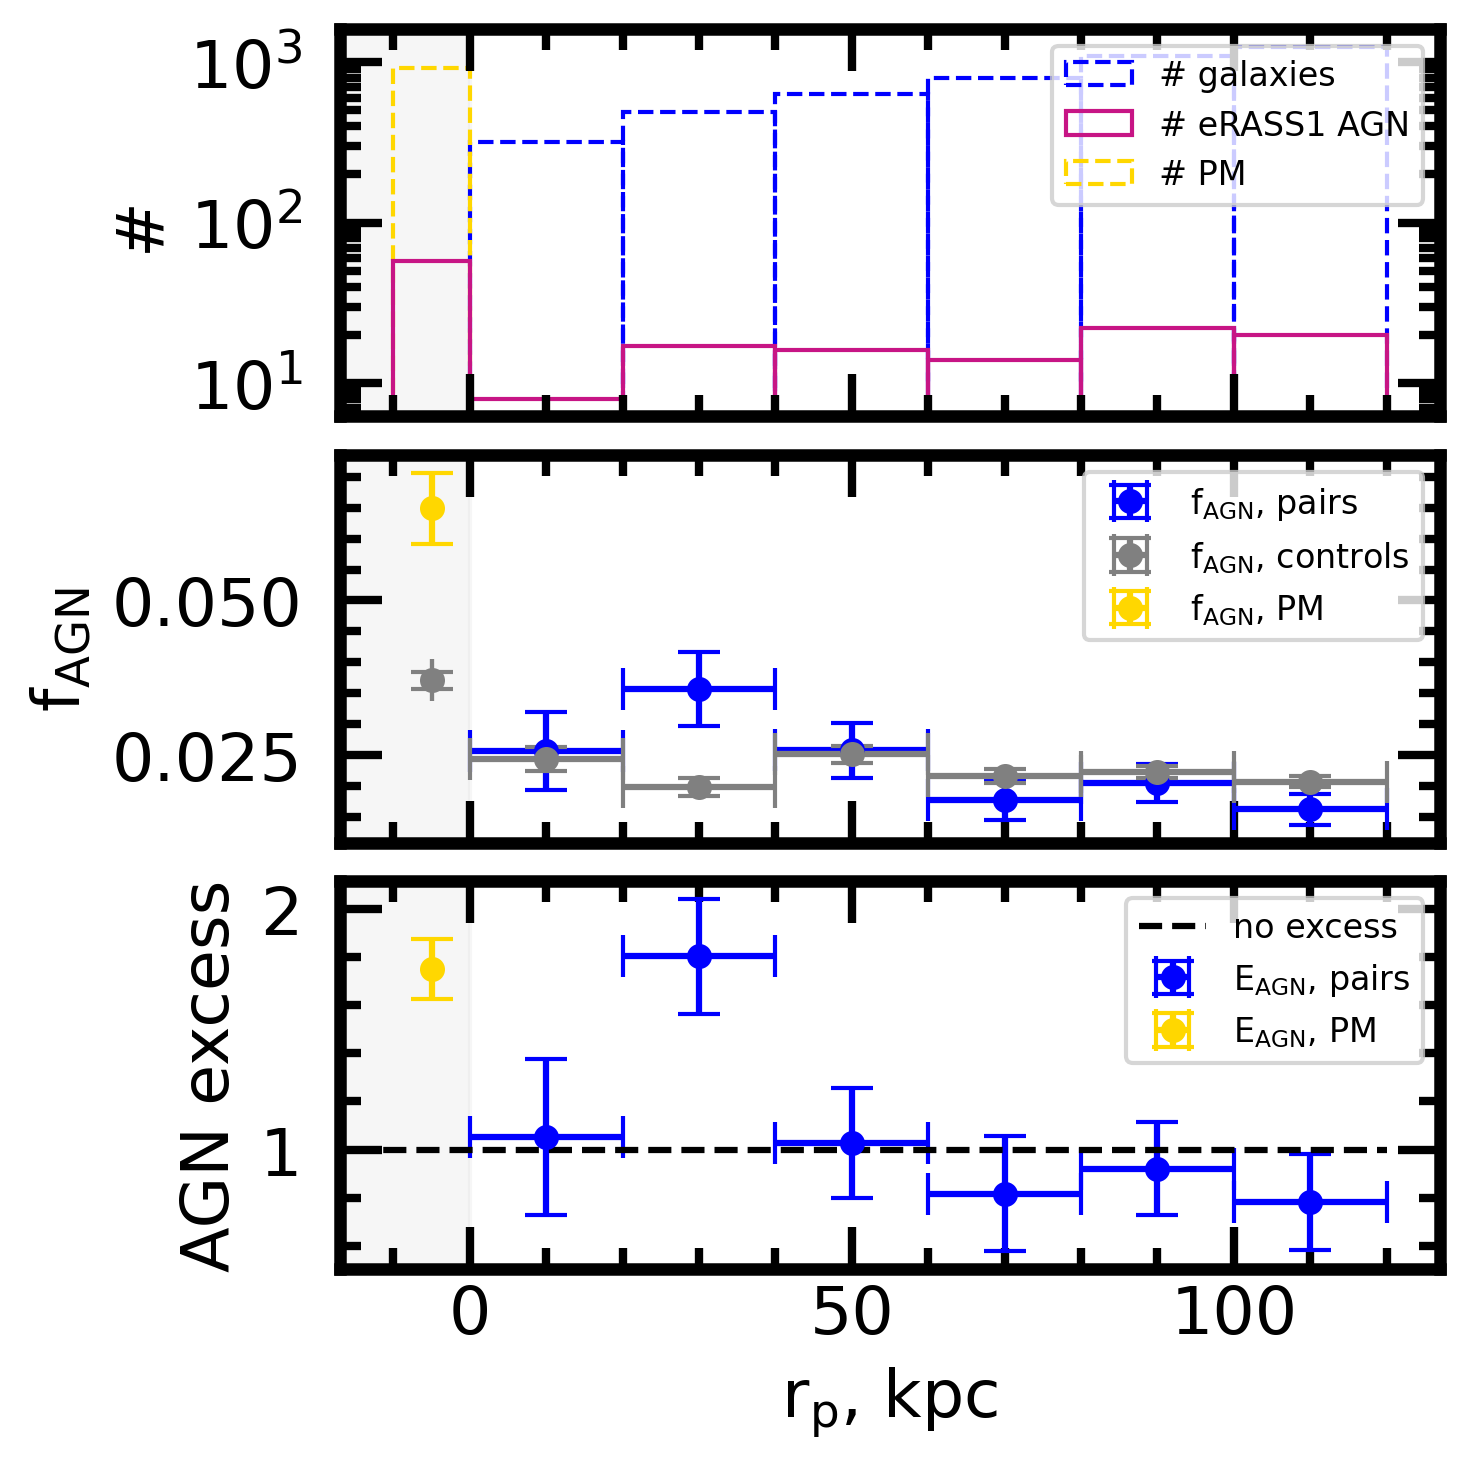

In [5]:
def calc_exc_ext_strict(r):
    print('doing {}'.format(str(r)))
    tar_pool = df[(df['rp']>=rp_space_ext[r])&(df['rp']<rp_space_ext[r+1])&(df['logmass']>8)&(df['logmass']<12)&(df['z_spec']>0.005)&~(df['PM']==1)]
    print(len(tar_pool))
    ctrl_pool = df[(df['pair_ctrl_120']==1)&(df['CNN']<0.1)&(df['logmass']>8)&(df['logmass']<12)&(df['z_spec']>0.005)]
    cpmean_m = np.mean(ctrl_pool['logmass'])
    cpstd_m = np.std(ctrl_pool['logmass'])
    m_td = ((ctrl_pool['logmass']-cpmean_m)/cpstd_m).tolist()
    cpmean_z = np.mean(ctrl_pool['z_spec'])
    cpstd_z = np.std(ctrl_pool['z_spec'])
    z_td = ((ctrl_pool['z_spec']-cpmean_z)/cpstd_z).tolist()
    treedat = np.array([[i,j] for i,j in zip(z_td,m_td)])
    tree = KDTree(treedat)
    selected = np.zeros(len(ctrl_pool))
    tar_data = []
    ctrl_data = []
    ctrl_samp = pd.DataFrame({},columns=[key for key in df.keys()])
    companion_samp = pd.DataFrame({},columns=[key for key in df.keys()])
    tar_samp = pd.DataFrame({},columns=[key for key in df.keys()])
    max_cpt = len(ctrl_pool)//len(tar_pool)
    max_cpt = max_cpt if max_cpt<10 else 10
    print('max {} controls per target'.format(str(max_cpt)))
    for batch in tqdm(range(max_cpt)):
        ctrl_data_prev = ctrl_data
        ctrl_samp_prev = ctrl_samp
        tar_data_prev = tar_data
        avoid_IDs = []
        for ind,row in tar_pool.iterrows():
            companion = df[(df['objID']==row['companion_objID'])].iloc[0]
            if row[0] in avoid_IDs or companion['companion_objID']!=row['objID']: #strict modification checking for mutual companionship
                pass
            else:
                found_c1 = False
                ki=1
                while not found_c1:
                    if ki==1:
                        match_ind = tree.query([(row['z_spec']-cpmean_z)/cpstd_z,(row['logmass']-cpmean_m)/cpstd_m],k=ki)[1]
                    else:
                        match_ind = tree.query([(row['z_spec']-cpmean_z)/cpstd_z,(row['logmass']-cpmean_m)/cpstd_m],k=ki)[1][-1]
                    if selected[match_ind]==1:
                        ki += 1
                    else:
                        match = ctrl_pool.iloc[match_ind]
                        found_c1 = True
                selected[ctrl_pool['objID']==match['objID']] = 1
                ctrl_samp = pd.concat([ctrl_samp,match.to_frame().T],ignore_index=True)
                #repeat the procedure for the companion galaxy
                if batch == 0:
                    tar_samp = pd.concat([tar_samp,row.to_frame().T],ignore_index=True)
                    companion_samp = pd.concat([companion_samp,companion.to_frame().T],ignore_index=True,axis=0)
                #Companion should always be in the table.
                found_c2 = False
                ki=1
                while not found_c2:
                    if ki==1:
                        match_ind = tree.query([(companion['z_spec']-cpmean_z)/cpstd_z,(companion['logmass']-cpmean_m)/cpstd_m],k=ki)[1]
                    else:
                        match_ind = tree.query([(companion['z_spec']-cpmean_z)/cpstd_z,(companion['logmass']-cpmean_m)/cpstd_m],k=ki)[1][-1]
                    if selected[match_ind]==1:
                        ki += 1
                    else:
                        match2 = ctrl_pool.iloc[match_ind]
                        found_c2 = True
                selected[ctrl_pool['objID']==match2['objID']] = 1
                ctrl_samp = pd.concat([ctrl_samp,match2.to_frame().T],ignore_index=True,axis=0)
                avoid_IDs.append(companion['objID'])
                #What L_X to add for the target galaxy pair?
                if batch==0: #only add the target LXs if it's the first pass through the data
                    tLX1 = row['L_X_e']
                    tLX2 = companion['L_X_e']
                    if tLX1>0 or tLX2>0:
                        tar_data.append(1)
                    else:
                        tar_data.append(0)
                #Always add control LXs regardless of what round, since controls are unique
                cLX1 = match['L_X_e']
                cLX2 = match2['L_X_e']
                if cLX1>0 or cLX2>0:
                    ctrl_data.append(1)
                else:
                    ctrl_data.append(0)
        tar_masses = np.concatenate([tar_samp['logmass'],companion_samp['logmass']])
        tar_zs = np.concatenate([tar_samp['z_spec'],companion_samp['z_spec']])
        ctrl_masses = ctrl_samp['logmass']
        ctrl_zs = ctrl_samp['z_spec']
        pval_m = ks_2samp(tar_masses,ctrl_masses)[1]
        pval_z = ks_2samp(tar_zs,ctrl_zs)[1]
        if ((pval_m>0.9) and (pval_z>0.9)) or len(ctrl_samp)==0: #checking that the matching stats are still OK
            ctrl_pool = ctrl_pool[~np.isin(ctrl_pool['objID'],ctrl_samp['objID'])]
            selected = np.zeros(len(ctrl_pool))
            cpmean_m = np.mean(ctrl_pool['logmass'])
            cpstd_m = np.std(ctrl_pool['logmass'])
            m_td = ((ctrl_pool['logmass']-cpmean_m)/cpstd_m).tolist()
            cpmean_z = np.mean(ctrl_pool['z_spec'])
            cpstd_z = np.std(ctrl_pool['z_spec'])
            z_td = ((ctrl_pool['z_spec']-cpmean_z)/cpstd_z).tolist()
            treedat = np.array([[i,j] for i,j in zip(z_td,m_td)])
            tree = KDTree(treedat)
            pass
        else: #If the stats fail and there are control pool galaxies
            ctrl_samp = ctrl_samp_prev
            ctrl_data = ctrl_data_prev
            culprit = 'both' if (pval_m<0.9 and pval_z<0.9) else 'mass' if pval_m<0.9 else 'redshift'
            pv = '{}, {}'.format(pval_m,pval_z) if culprit=='both' else str(pval_m) if culprit=='mass' else str(pval_z)
            print('stopping control matching on batch {} due to {} stats with p = {}'.format(str(batch),culprit,pv))
            break
    print('saving data for r = {}'.format(str(r)))
    tar_samp.to_csv('./nov6_match_track/tar_samp_strict_120_{}.csv'.format(str(r)))
    companion_samp.to_csv('./nov6_match_track/companion_samp_strict_120_{}.csv'.format(str(r)))
    ctrl_samp.to_csv('./nov6_match_track/ctrl_samp_strict_120_{}.csv'.format(str(r)))
    tar_data = np.array(tar_data)
    ctrl_data = np.array(ctrl_data)
    print(len(tar_data),len(ctrl_data))
    print('determining AGN statuses')
    #calculating target AGN fractions
    aft = len(tar_data[tar_data==1])/(len(tar_data))
    aft = 1-np.sqrt(1-2*aft)
    aft_err = np.sqrt(aft*(1-aft)/(2*(len(tar_data))))
    #calculating control agn fractions
    afc = len(ctrl_data[ctrl_data==1])/(len(ctrl_data))
    afc = 1-np.sqrt(1-2*afc)
    afc_err = np.sqrt(afc*(1-afc)/(2*(len(ctrl_data))))
    print('aft = {}'.format(str(aft)))
    print('aft_err = {}'.format(str(aft_err)))
    print('afc = {}'.format(str(afc)))
    print('afc_err = {}'.format(str(afc_err)))
    exc = aft/afc
    err = aft_err/aft+afc_err/afc
    print('exc = {}'.format(str(aft/afc)))
    print('exc_err = {}'.format(str(aft_err/aft+afc_err/afc)))
    #format: [number of galaxies, number of AGN, AFTs, AFTes, AFCs, AFCes, excs, excerrs]
    return [len(tar_data),len(tar_data[tar_data==1]),aft,aft_err,afc,afc_err,exc,err]
rp_space_ext = np.linspace(0,120,7)
print(rp_space_ext)
p = Pool()
data_ext = np.array(p.map(calc_exc_ext_strict,range(len(rp_space_ext)-1)))
#data_ext = np.array([calc_exc_ext(i) for i in range(len(rp_space_ext)-1)])
p.close()
p.join()

ngs_ext = data_ext[:,0]
nas_ext = data_ext[:,1]
afts_ext = data_ext[:,2]
aftes_ext = data_ext[:,3]
afcs_ext = data_ext[:,4]
afces_ext = data_ext[:,5]
excs_ext = data_ext[:,6]
exces_ext = data_ext[:,7]
exces2_ext = exces_ext#np.sqrt(2)*(aftes_ext/afts_ext+afces_ext/afcs_ext)
aftes2_ext = aftes_ext#np.sqrt(2)*aftes_ext
afces2_ext = afces_ext#np.sqrt(2)*afces_ext

def calc_exc_ext_pm():
    tar_pool = df[(df['PM']==1)&(df['logmass']>8)&(df['logmass']<12)&(df['z_spec']>0.005)]
    print(len(tar_pool))
    ctrl_pool = df[(df['pair_ctrl_120']==1)&(df['CNN']<0.1)&(df['logmass']>8)&(df['logmass']<12)&(df['z_spec']>0.005)]
    cpmean_m = np.mean(ctrl_pool['logmass'])
    cpstd_m = np.std(ctrl_pool['logmass'])
    m_td = ((ctrl_pool['logmass']-cpmean_m)/cpstd_m).tolist()
    cpmean_z = np.mean(ctrl_pool['z_spec'])
    cpstd_z = np.std(ctrl_pool['z_spec'])
    z_td = ((ctrl_pool['z_spec']-cpmean_z)/cpstd_z).tolist()
    treedat = np.array([[i,j] for i,j in zip(z_td,m_td)])
    tree = KDTree(treedat)
    selected = np.zeros(len(ctrl_pool))
    tar_data = []
    ctrl_data = []
    ctrl_samp = pd.DataFrame({},columns=[key for key in df.keys()])
    max_cpt = len(ctrl_pool)//len(tar_pool)
    max_cpt = max_cpt if max_cpt<10 else 10
    print('max {} controls per target'.format(str(max_cpt)))
    for batch in tqdm(range(max_cpt)):
        ctrl_data_prev = ctrl_data
        ctrl_samp_prev = ctrl_samp
        for ind,row in tar_pool.iterrows():
            found_c1 = False
            ki=1
            while not found_c1:
                if ki==1:
                    match_ind = tree.query([(row['z_spec']-cpmean_z)/cpstd_z,(row['logmass']-cpmean_m)/cpstd_m],k=ki)[1]
                else:
                    match_ind = tree.query([(row['z_spec']-cpmean_z)/cpstd_z,(row['logmass']-cpmean_m)/cpstd_m],k=ki)[1][-1]
                if selected[match_ind]==1:
                    ki += 1
                else:
                    match = ctrl_pool.iloc[match_ind]
                    found_c1 = True
            selected[ctrl_pool['objID']==match['objID']] = 1
            ctrl_samp = pd.concat([ctrl_samp,match.to_frame().T],ignore_index=True)
            #What L_X to add for the target galaxy pair?
            if batch==0: #only add the target LXs if it's the first pass through the data
                tLX1 = row['L_X_e']
                if tLX1>0:
                    tar_data.append(1)
                else:
                    tar_data.append(0)
            #Always add control LXs regardless of what round, since controls are unique
            cLX1 = match['L_X_e']
            if cLX1>0:
                ctrl_data.append(1)
            else:
                ctrl_data.append(0)
        tar_masses = tar_pool['logmass']
        tar_zs = tar_pool['z_spec']
        ctrl_masses = ctrl_samp['logmass']
        ctrl_zs = ctrl_samp['z_spec']
        pval_m = ks_2samp(tar_masses,ctrl_masses)[1]
        pval_z = ks_2samp(tar_zs,ctrl_zs)[1]
        if ((pval_m>0.9) and (pval_z>0.9)) or len(ctrl_samp)==0: #checking that the matching stats are still OK
            ctrl_pool = ctrl_pool[~np.isin(ctrl_pool['objID'],ctrl_samp['objID'])]
            selected = np.zeros(len(ctrl_pool))
            cpmean_m = np.mean(ctrl_pool['logmass'])
            cpstd_m = np.std(ctrl_pool['logmass'])
            m_td = ((ctrl_pool['logmass']-cpmean_m)/cpstd_m).tolist()
            cpmean_z = np.mean(ctrl_pool['z_spec'])
            cpstd_z = np.std(ctrl_pool['z_spec'])
            z_td = ((ctrl_pool['z_spec']-cpmean_z)/cpstd_z).tolist()
            treedat = np.array([[i,j] for i,j in zip(z_td,m_td)])
            tree = KDTree(treedat)
            print('ctrl pool length {}'.format(str(len(ctrl_pool))))
            pass
        else: #If the stats fail and there are control pool galaxies
            ctrl_samp = ctrl_samp_prev
            ctrl_data = ctrl_data_prev
            culprit = 'both' if (pval_m<0.9 and pval_z<0.9) else 'mass' if pval_m<0.9 else 'redshift'
            pv = '{}, {}'.format(pval_m,pval_z) if culprit=='both' else str(pval_m) if culprit=='mass' else str(pval_z)
            print('stopping control matching on batch {} due to {} stats with p = {}'.format(str(batch),culprit,pv))
            break
    print('saving data for r = PM')
    tar_pool.to_csv('./nov6_match_track/tar_pool_120_pm.csv')
    ctrl_samp.to_csv('./nov6_match_track/ctrl_samp_120_pm.csv')
    tar_data = np.array(tar_data)
    ctrl_data = np.array(ctrl_data)
    print(len(tar_data),len(ctrl_data))
    print('determining AGN statuses')
    #calculating target AGN fractions
    aft = len(tar_data[tar_data==1])/(len(tar_data))
    aft = 1-np.sqrt(1-2*aft)
    aft_err = np.sqrt(aft*(1-aft)/(2*(len(tar_data))))
    #calculating control agn fractions
    afc = len(ctrl_data[ctrl_data==1])/(len(ctrl_data))
    afc = 1-np.sqrt(1-2*afc)
    afc_err = np.sqrt(afc*(1-afc)/(2*(len(ctrl_data))))
    print('aft = {}'.format(str(aft)))
    print('aft_err = {}'.format(str(aft_err)))
    print('afc = {}'.format(str(afc)))
    print('afc_err = {}'.format(str(afc_err)))
    exc = aft/afc
    err = aft_err/aft+afc_err/afc
    print('exc = {}'.format(str(aft/afc)))
    print('exc_err = {}'.format(str(aft_err/aft+afc_err/afc)))
    #format: [number of galaxies, number of AGN, AFTs, AFTes, AFCs, AFCes, excs, excerrs]
    return [len(tar_data),len(tar_data[tar_data==1]),aft,aft_err,afc,afc_err,exc,err]
ng,nagn,aft,afte,afc,afce,exc,exce = calc_exc_ext_pm()

fig,axs = plt.subplots(3,1,figsize=[5,5],dpi=300,sharex=True)
rp_space_plot_ext = rp_space_ext[:-1]+10
axs.flatten()[0].axvspan(-40,0,alpha=0.2, color='lightgray')
axs.flatten()[1].axvspan(-40,0,alpha=0.2, color='lightgray')
axs.flatten()[2].axvspan(-40,0,alpha=0.2, color='lightgray')
plt.xlim(-17,127)
#panel 1: number of galaxies & agn in each bin
axs.flatten()[0].bar(rp_space_plot_ext,ngs_ext,color='gray',edgecolor='blue',width=20,linestyle='dashed',label='# galaxies',log=True,fill=False)
axs.flatten()[0].bar(rp_space_plot_ext,nas_ext,color='mediumvioletred',edgecolor='mediumvioletred',width=20,label='# eRASS1 AGN',log=True,fill=False)
axs.flatten()[0].bar(-5,ng,color='gold',edgecolor='gold',linestyle='dashed',width=10,label='# PM',log=True,fill=False)
axs.flatten()[0].bar(-5,nagn,color='mediumvioletred',edgecolor='mediumvioletred',width=10,log=True,fill=False)
axs.flatten()[0].set_ylabel('#')
axs.flatten()[0].legend(loc='upper right', fontsize=8)
#panel 2: fractions and errors of AGN in pair & control samples
axs.flatten()[1].errorbar(rp_space_plot_ext,afts_ext,xerr=10,yerr=aftes2_ext,color='blue',label='f$\mathrm{_{AGN}}$, pairs',marker='o',markersize=5,capsize=5,linestyle='')
axs.flatten()[1].errorbar(rp_space_plot_ext,afcs_ext,xerr=10,yerr=afces2_ext,color='gray',label='f$\mathrm{_{AGN}}$, controls',marker='o',markersize=5,capsize=5,linestyle='')
axs.flatten()[1].errorbar(-5,aft,xerr=0,yerr=afte,color='gold',label='f$\mathrm{_{AGN}}$, PM',marker='o',markersize=5,capsize=5,linestyle='')
axs.flatten()[1].errorbar(-5,afc,xerr=0,yerr=afce,color='gray',marker='o',markersize=5,capsize=5,linestyle='')
axs.flatten()[1].legend(loc='upper right',fontsize=8)
axs.flatten()[1].set_ylabel('f$\mathrm{_{AGN}}$')
#panel 3: excess calcs
axs.flatten()[2].errorbar(rp_space_plot_ext,excs_ext,xerr=10,yerr=exces2_ext,color='blue',label='E$\mathrm{_{AGN}}$, pairs',marker='o',markersize=5,capsize=5,linestyle='')
axs.flatten()[2].errorbar(-5,exc,xerr=0,yerr=exce,color='gold',label='E$\mathrm{_{AGN}}$, PM',marker='o',markersize=5,capsize=5,linestyle='')
axs.flatten()[2].hlines(1,-20,120,linestyle='dashed',color='black',label='no excess')
axs.flatten()[2].set_ylabel('AGN excess')
axs.flatten()[2].set_xlabel('r$\mathrm{_{p}}$, kpc')
axs.flatten()[2].legend(loc='upper right',fontsize=8)
plt.tight_layout()
plt.subplots_adjust(hspace=0.1)
plt.show()

[  0.  20.  40.  60.  80. 100. 120.]
aft = 0.025645296307553633
afc = 0.024347021642830646
exc 0 = 1.0533237569575695
exc 1 = 1.8039630768359374
exc 2 = 1.0259800255263685
exc 3 = 0.8170789138232014
exc 4 = 0.9196731456207913
exc 5 = 0.7825372717510903


  0%|          | 0/10 [00:00<?, ?it/s]

aft = 0.06494766978614863
afc = 0.037090901056732295
exc PM = 1.751040496072287


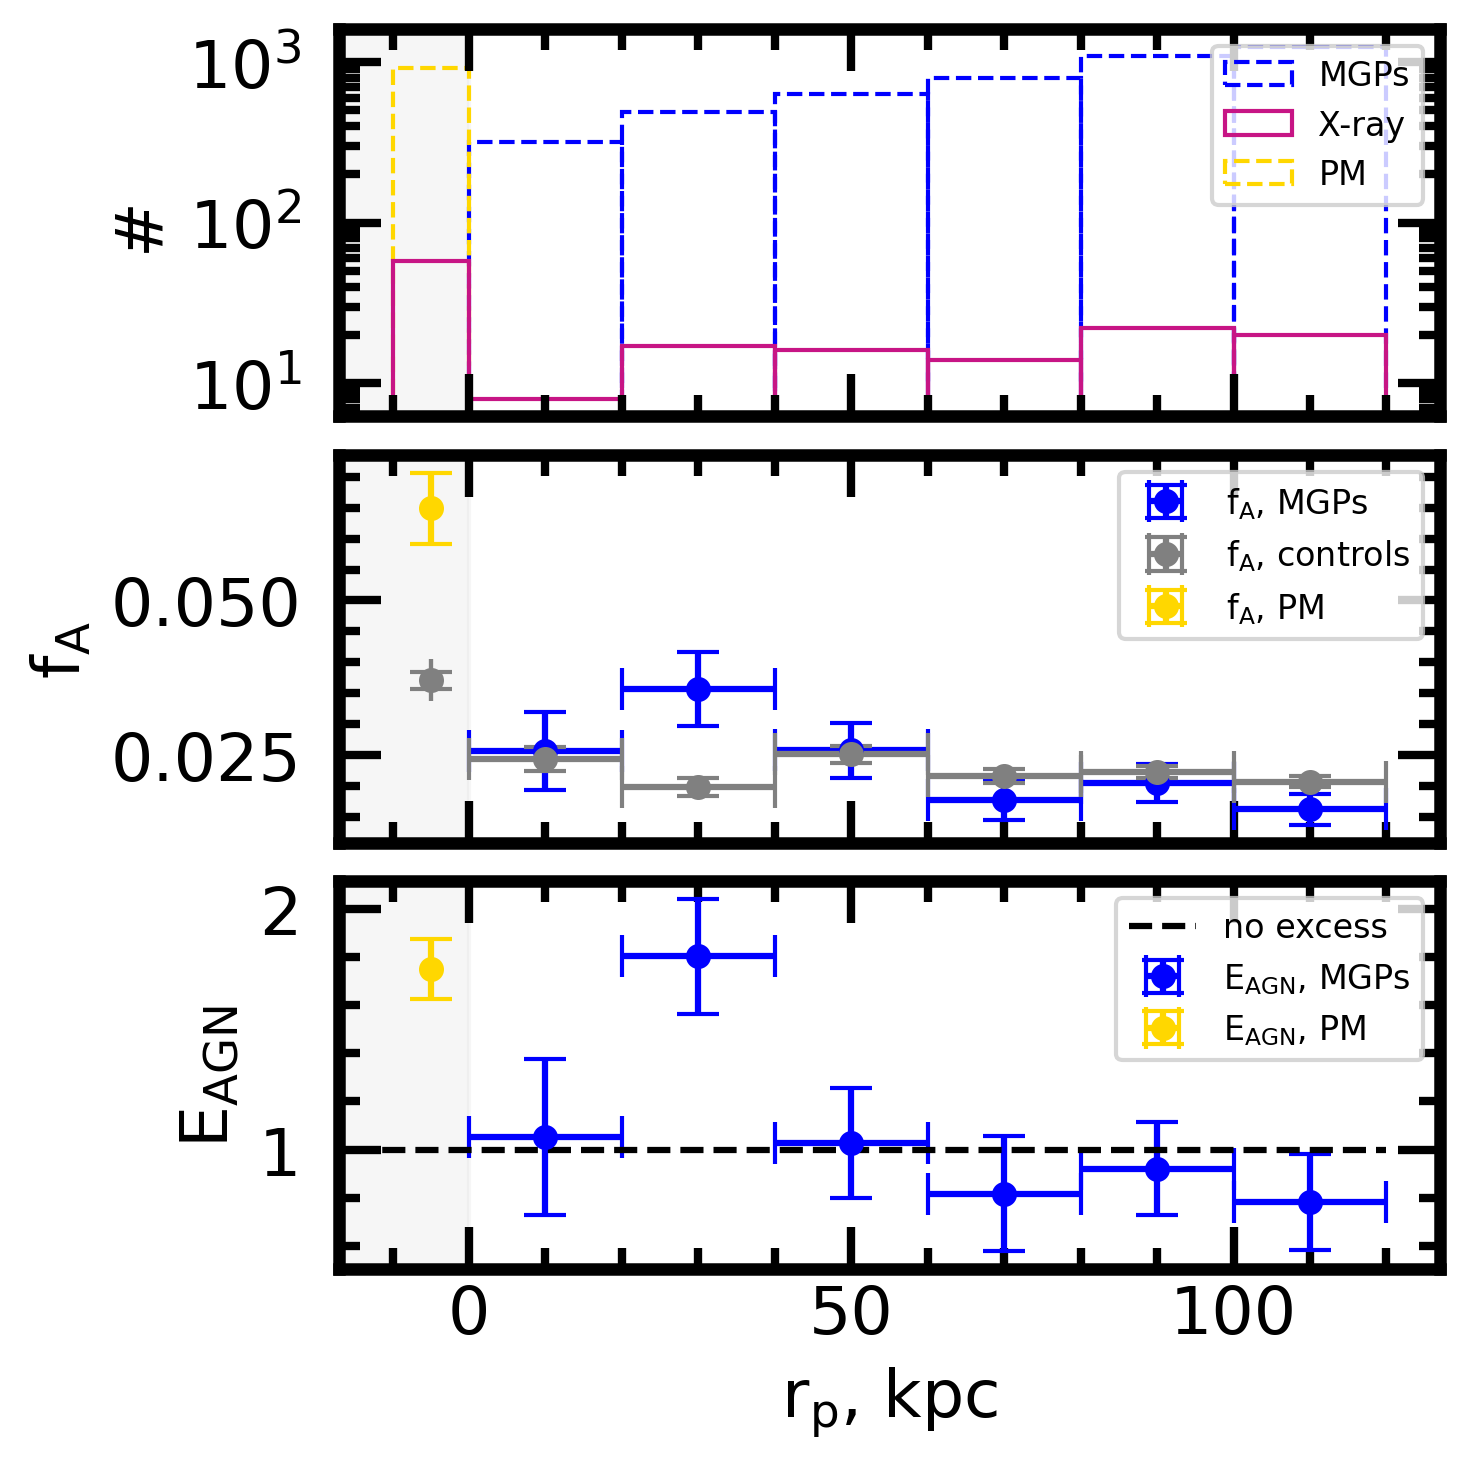

In [146]:
def calc_exc_ext(r):
    #print('doing {}'.format(str(r)))
    tar_samp = pd.read_csv('./nov6_match_track/tar_samp_strict_120_{}.csv'.format(str(r)))#df[(df['rp']>=rp_space_ext[r])&(df['rp']<rp_space_ext[r+1])&(df['logmass']>8)&(df['z_spec']>0.005)]
    ctrl_samp = pd.read_csv('./nov6_match_track/ctrl_samp_strict_120_{}.csv'.format(str(r)))#pd.DataFrame({},columns=[key for key in df.keys()])
    companion_samp = pd.read_csv('./nov6_match_track/companion_samp_strict_120_{}.csv'.format(str(r)))#pd.DataFrame({},columns=[key for key in df.keys()])
    tars = [row for ind,row in tar_samp.iterrows()]
    comps = [row for ind,row in companion_samp.iterrows()]
    ctrls = [row for ind,row in ctrl_samp.iterrows()]
    #print(len(tars))
    #print(len(comps))
    #print(len(ctrls))
    tar_data = []
    ctrl_data = []
    max_cpt = int(len(ctrls)/(len(tars)+len(comps)))
    #print('max {} controls per target'.format(str(max_cpt)))
    for batch in tqdm(range(max_cpt)):
        for i in range(len(tars)):
            row = tars[i]
            companion = comps[i]
            match = ctrls[batch*len(tars)*2+2*i]
            match2 = ctrls[batch*len(tars)*2+2*i+1]
            #What L_X to add for the target galaxy pair?
            if batch==0: #only add the target LXs if it's the first pass through the data
                tLX1 = row['L_X_e']
                tLX2 = companion['L_X_e']
                if tLX1>0 or tLX2>0:
                    tar_data.append(1)
                else:
                    tar_data.append(0)
            #Always add control LXs regardless of what round, since controls are unique
            cLX1 = match['L_X_e']
            cLX2 = match2['L_X_e']
            if cLX1>0 or cLX2>0:
                ctrl_data.append(1)
            else:
                ctrl_data.append(0)
    tar_data = np.array(tar_data)
    ctrl_data = np.array(ctrl_data)
    #print(len(tar_data),len(ctrl_data))
    #print('determining AGN statuses')
    #calculating target AGN fractions
    aft = len(tar_data[tar_data==1])/(len(tar_data))
    aft = 1-np.sqrt(1-2*aft)
    aft_err = np.sqrt(aft*(1-aft)/(2*(len(tar_data))))
    #calculating control agn fractions
    afc = len(ctrl_data[ctrl_data==1])/(len(ctrl_data))
    afc = 1-np.sqrt(1-2*afc)
    afc_err = np.sqrt(afc*(1-afc)/(2*(len(ctrl_data))))
    if r==0:
        print('aft = {}'.format(str(aft)))
        #print('aft_err = {}'.format(str(aft_err)))
        print('afc = {}'.format(str(afc)))
    #print('afc_err = {}'.format(str(afc_err)))
    exc = aft/afc
    print('exc {} = {}'.format(r,exc))
    err = aft_err/aft+afc_err/afc
    #print('exc = {}'.format(str(aft/afc)))
    #print('exc_err = {}'.format(str(aft_err/aft+afc_err/afc)))
    #format: [number of galaxies, number of AGN, AFTs, AFTes, AFCs, AFCes, excs, excerrs]
    return [len(tar_data),len(tar_data[tar_data==1]),aft,aft_err,afc,afc_err,exc,err]
rp_space_ext = np.linspace(0,120,7)
print(rp_space_ext)
p = Pool()
data_ext = np.array(p.map(calc_exc_ext,range(len(rp_space_ext)-1)))
#data_ext = np.array([calc_exc_ext(i) for i in range(len(rp_space_ext)-1)])
p.close()
p.join()

ngs_ext = data_ext[:,0]
nas_ext = data_ext[:,1]
afts_ext = data_ext[:,2]
aftes_ext = data_ext[:,3]
afcs_ext = data_ext[:,4]
afces_ext = data_ext[:,5]
excs_ext = data_ext[:,6]
exces_ext = data_ext[:,7]
exces2_ext = exces_ext#np.sqrt(2)*(aftes_ext/afts_ext+afces_ext/afcs_ext)
aftes2_ext = aftes_ext#np.sqrt(2)*aftes_ext
afces2_ext = afces_ext#np.sqrt(2)*afces_ext

def calc_exc_ext_pm():
    tar_samp = pd.read_csv('./nov6_match_track/tar_pool_120_pm.csv')#df[(df['rp']>=rp_space_ext[r])&(df['rp']<rp_space_ext[r+1])&(df['logmass']>8)&(df['z_spec']>0.005)]
    tars = [row for ind,row in tar_samp.iterrows()]
    ctrl_samp = pd.read_csv('./nov6_match_track/ctrl_samp_120_pm.csv')#pd.DataFrame({},columns=[key for key in df.keys()])
    ctrls = [row for ind,row in ctrl_samp.iterrows()]
    tar_data = []
    ctrl_data = []
    for batch in tqdm(range(10)):
        ctrl_data_prev = ctrl_data
        ctrl_samp_prev = ctrl_samp
        for i in range(len(tars)):
            row = tars[i]
            match = ctrls[batch*len(tars)+i]
            #What L_X to add for the target galaxy pair?
            if batch==0: #only add the target LXs if it's the first pass through the data
                tLX1 = row['L_X_e']
                if tLX1>0:
                    tar_data.append(1)
                else:
                    tar_data.append(0)
            #Always add control LXs regardless of what round, since controls are unique
            cLX1 = match['L_X_e']
            if cLX1>0:
                ctrl_data.append(1)
            else:
                ctrl_data.append(0)
    tar_data = np.array(tar_data)
    ctrl_data = np.array(ctrl_data)
    #print(len(tar_data),len(ctrl_data))
    #print('determining AGN statuses')
    #calculating target AGN fractions
    aft = len(tar_data[tar_data==1])/(len(tar_data))
    aft = 1-np.sqrt(1-2*aft)
    aft_err = np.sqrt(aft*(1-aft)/(2*(len(tar_data))))
    #calculating control agn fractions
    afc = len(ctrl_data[ctrl_data==1])/(len(ctrl_data))
    afc = 1-np.sqrt(1-2*afc)
    afc_err = np.sqrt(afc*(1-afc)/(2*(len(ctrl_data))))
    print('aft = {}'.format(str(aft)))
    #print('aft_err = {}'.format(str(aft_err)))
    print('afc = {}'.format(str(afc)))
    #print('afc_err = {}'.format(str(afc_err)))
    exc = aft/afc
    print('exc PM = {}'.format(exc))
    err = aft_err/aft+afc_err/afc
    #print('exc = {}'.format(str(aft/afc)))
    #print('exc_err = {}'.format(str(aft_err/aft+afc_err/afc)))
    #format: [number of galaxies, number of AGN, AFTs, AFTes, AFCs, AFCes, excs, excerrs]
    return [len(tar_data),len(tar_data[tar_data==1]),aft,aft_err,afc,afc_err,exc,err]
ng,nagn,aft,afte,afc,afce,exc,exce = calc_exc_ext_pm()

fig,axs = plt.subplots(3,1,figsize=[5,5],dpi=300,sharex=True)
rp_space_plot_ext = rp_space_ext[:-1]+10
axs.flatten()[0].axvspan(-40,0,alpha=0.2, color='lightgray')
axs.flatten()[1].axvspan(-40,0,alpha=0.2, color='lightgray')
axs.flatten()[2].axvspan(-40,0,alpha=0.2, color='lightgray')
plt.xlim(-17,127)
#panel 1: number of galaxies & agn in each bin
axs.flatten()[0].bar(rp_space_plot_ext,ngs_ext,color='gray',edgecolor='blue',width=20,linestyle='dashed',label='MGPs',log=True,fill=False)
axs.flatten()[0].bar(rp_space_plot_ext,nas_ext,color='mediumvioletred',edgecolor='mediumvioletred',width=20,label='X-ray',log=True,fill=False)
axs.flatten()[0].bar(-5,ng,color='gold',edgecolor='gold',linestyle='dashed',width=10,label='PM',log=True,fill=False)
axs.flatten()[0].bar(-5,nagn,color='mediumvioletred',edgecolor='mediumvioletred',width=10,log=True,fill=False)
axs.flatten()[0].set_ylabel('#')
axs.flatten()[0].legend(loc='upper right', fontsize=8)
#panel 2: fractions and errors of AGN in pair & control samples
axs.flatten()[1].errorbar(rp_space_plot_ext,afts_ext,xerr=10,yerr=aftes2_ext,color='blue',label='f$\mathrm{_{A}}$, MGPs',marker='o',markersize=5,capsize=5,linestyle='')
axs.flatten()[1].errorbar(rp_space_plot_ext,afcs_ext,xerr=10,yerr=afces2_ext,color='gray',label='f$\mathrm{_{A}}$, controls',marker='o',markersize=5,capsize=5,linestyle='')
axs.flatten()[1].errorbar(-5,aft,xerr=0,yerr=afte,color='gold',label='f$\mathrm{_{A}}$, PM',marker='o',markersize=5,capsize=5,linestyle='')
axs.flatten()[1].errorbar(-5,afc,xerr=0,yerr=afce,color='gray',marker='o',markersize=5,capsize=5,linestyle='')
axs.flatten()[1].legend(loc='upper right',fontsize=8)
axs.flatten()[1].set_ylabel('f$\mathrm{_{A}}$')
#panel 3: excess calcs
axs.flatten()[2].errorbar(rp_space_plot_ext,excs_ext,xerr=10,yerr=exces2_ext,color='blue',label='E$\mathrm{_{AGN}}$, MGPs',marker='o',markersize=5,capsize=5,linestyle='')
axs.flatten()[2].errorbar(-5,exc,xerr=0,yerr=exce,color='gold',label='E$\mathrm{_{AGN}}$, PM',marker='o',markersize=5,capsize=5,linestyle='')
axs.flatten()[2].hlines(1,-20,120,linestyle='dashed',color='black',label='no excess')
axs.flatten()[2].set_ylabel('$\mathrm{E_{AGN}}$')
axs.flatten()[2].set_xlabel('r$\mathrm{_{p}}$, kpc')
axs.flatten()[2].legend(loc='upper right',fontsize=8)
plt.tight_layout()
plt.subplots_adjust(hspace=0.1)
plt.show()

[  0.  20.  40.  60.  80. 100. 120.]
exc 0 = 1.198655819019562
exc 1 = 1.0895922708109818
exc 2 = 1.0375162913654528
exc 3 = 0.8831212185156772
exc 4 = 0.9361364982917646
exc 5 = 0.8336080966926841


  0%|          | 0/10 [00:00<?, ?it/s]

exc PM = 2.568937587056826


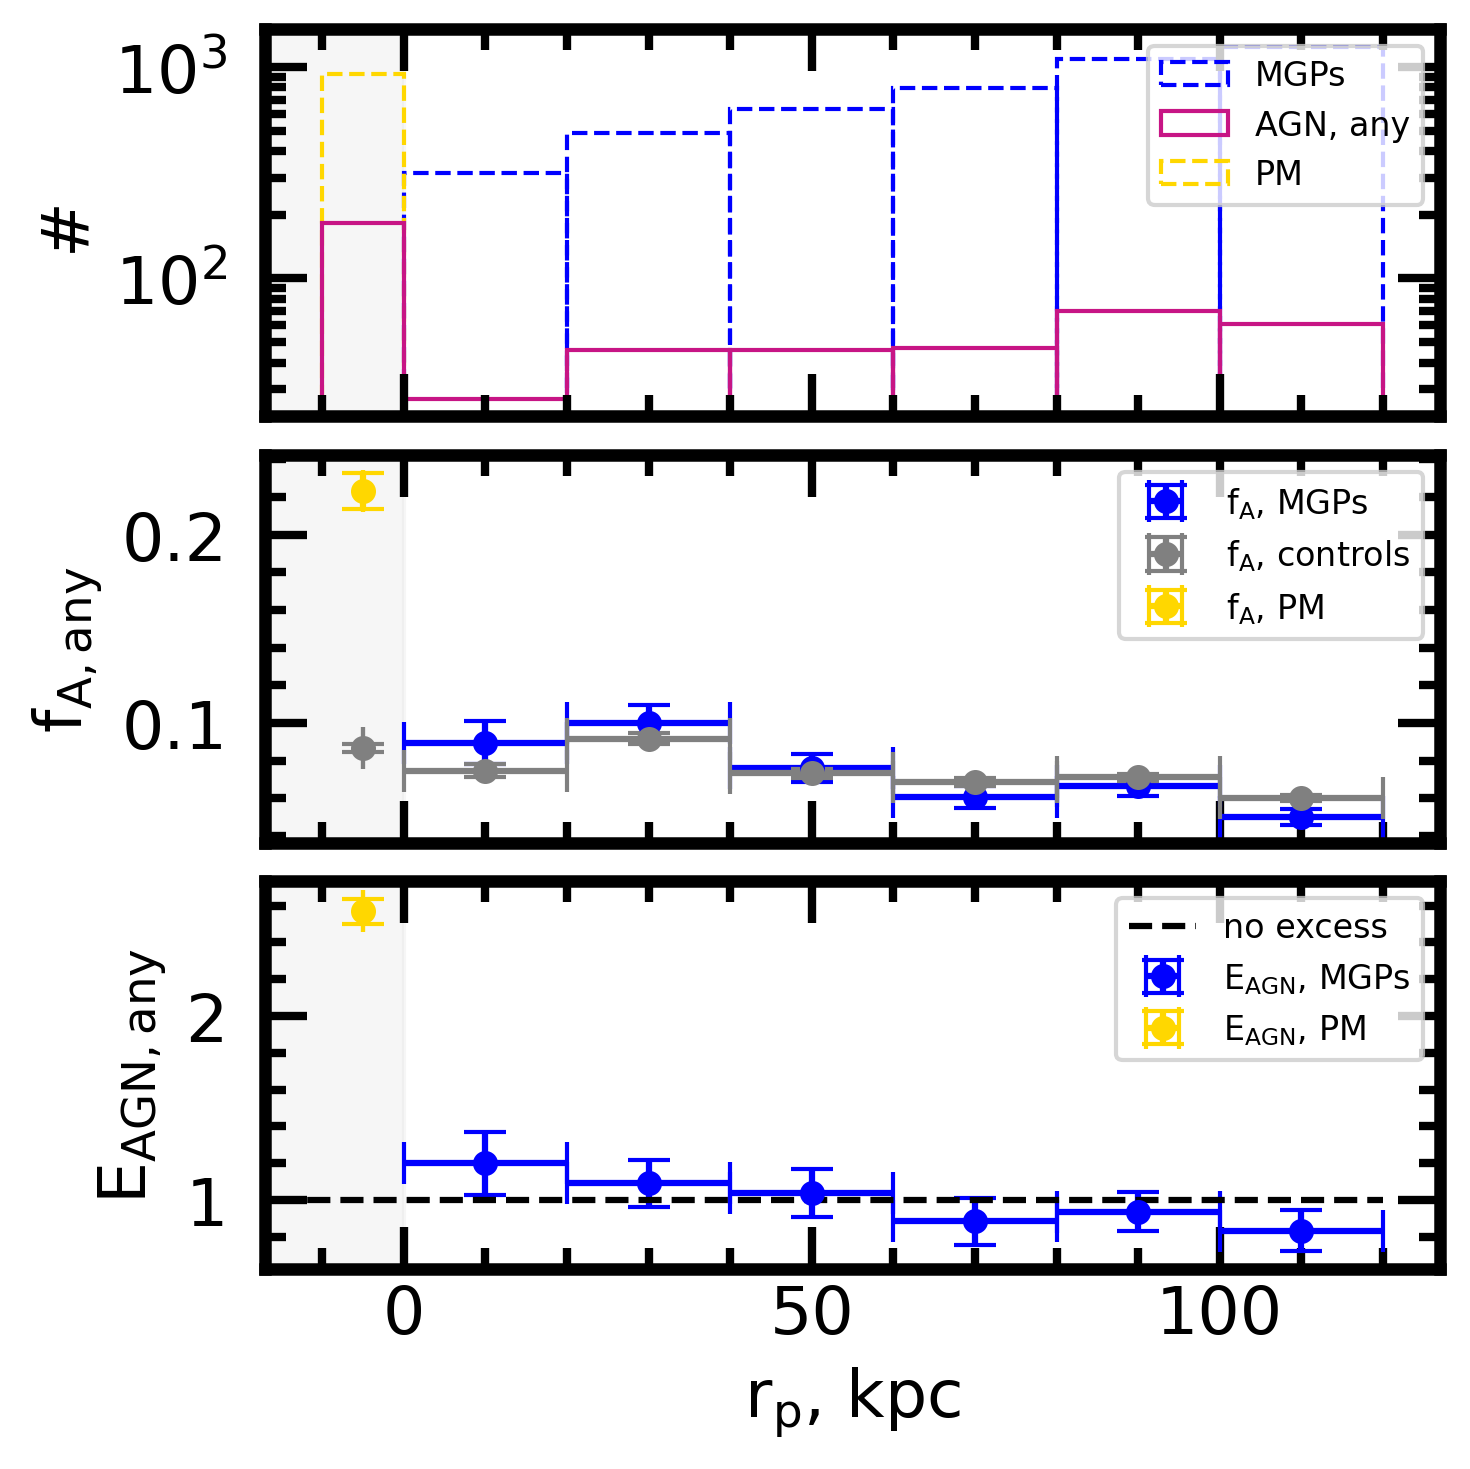

In [145]:
def calc_exc_ext_any(r):
    #print('doing {}'.format(str(r)))
    tar_samp = pd.read_csv('./nov6_match_track/tar_samp_strict_120_{}.csv'.format(str(r)))#df[(df['rp']>=rp_space_ext[r])&(df['rp']<rp_space_ext[r+1])&(df['logmass']>8)&(df['z_spec']>0.005)]
    ctrl_samp = pd.read_csv('./nov6_match_track/ctrl_samp_strict_120_{}.csv'.format(str(r)))#pd.DataFrame({},columns=[key for key in df.keys()])
    companion_samp = pd.read_csv('./nov6_match_track/companion_samp_strict_120_{}.csv'.format(str(r)))#pd.DataFrame({},columns=[key for key in df.keys()])
    tars = [row for ind,row in tar_samp.iterrows()]
    comps = [row for ind,row in companion_samp.iterrows()]
    ctrls = [row for ind,row in ctrl_samp.iterrows()]
    tar_data = []
    ctrl_data = []
    for batch in range(len(ctrls)//(2*len(tars))):
        for i in range(len(tars)):
            row = tars[i]
            companion = comps[i]
            match = ctrls[batch*len(tars)*2+2*i]
            match2 = ctrls[batch*len(tars)*2+2*i+1]
            #What L_X to add for the target galaxy pair?
            if batch==0: #only add the target LXs if it's the first pass through the data
                tLX1 = row['L_X_e']
                tLX2 = companion['L_X_e']
                tW1 = row['W1']-row['W2']
                tW2 = companion['W1']-companion['W2']
                bpt_pos = (row['OIII_5007_flux']>0)&(row['Halpha_flux']>0)&(row['Hbeta_flux']>0)&(row['Halpha_ew']<-6)
                if bpt_pos:
                    tBPT1 = 1 if (row['agn_sn']>5)&(row['new_K01_flag']=='AGN')&(np.isnan(match['BLR'])) else 0
                else:
                    tBPT1 = 0
                bpt_pos = (companion['OIII_5007_flux']>0)&(companion['Halpha_flux']>0)&(companion['Hbeta_flux']>0)&(companion['Halpha_ew']<-6)
                if bpt_pos:
                    tBPT2 = 1 if (companion['agn_sn']>5)&(companion['new_K01_flag']=='AGN')&(np.isnan(match['BLR'])) else 0
                else:
                    tBPT2 = 0
                tBLR1 = row['BLR']
                tBLR2 = companion['BLR']
                if tLX1>0 or tLX2>0 or tW1>0.5 or tW2>0.5 or tBPT1>0 or tBPT2>0 or tBLR1>0 or tBLR2>0:
                    tar_data.append(1)
                else:
                    tar_data.append(0)
            #Always add control LXs regardless of what round, since controls are unique
            cLX1 = match['L_X_e']
            cLX2 = match2['L_X_e']
            cW1 = match['W1']-match['W2']
            cW2 = companion['W1']-companion['W2']
            bpt_pos = (match['OIII_5007_flux']>0)&(match['Halpha_flux']>0)&(match['Hbeta_flux']>0)&(match['Halpha_ew']<-6)
            if bpt_pos:
                cBPT1 = 1 if (match['agn_sn']>5)&(match['new_K01_flag']=='AGN')&(np.isnan(match['BLR'])) else 0
            else:
                cBPT1 = 0
            bpt_pos = (match2['OIII_5007_flux']>0)&(match2['Halpha_flux']>0)&(match2['Hbeta_flux']>0)&(match2['Halpha_ew']<-6)
            if bpt_pos:
                cBPT2 = 1 if (match2['agn_sn']>5)&(match2['new_K01_flag']=='AGN')&(np.isnan(match2['BLR'])) else 0
            else:
                cBPT2 = 0
            cBLR1 = match['BLR']
            cBLR2 = match2['BLR']
            if cLX1>0 or cLX2>0 or cW1>0.5 or cW2>0.5 or cBPT1>0 or cBPT2>0 or cBLR1>0 or cBLR2>0:
                ctrl_data.append(1)
            else:
                ctrl_data.append(0)
    tar_data = np.array(tar_data)
    ctrl_data = np.array(ctrl_data)
    #print(len(tar_data),len(ctrl_data))
    #print('determining AGN statuses')
    #calculating target AGN fractions
    aft = len(tar_data[tar_data==1])/(len(tar_data))
    aft = 1-np.sqrt(1-2*aft)
    aft_err = np.sqrt(aft*(1-aft)/(2*(len(tar_data))))
    #calculating control agn fractions
    afc = len(ctrl_data[ctrl_data==1])/(len(ctrl_data))
    afc = 1-np.sqrt(1-2*afc)
    afc_err = np.sqrt(afc*(1-afc)/(2*(len(ctrl_data))))
    #print('aft = {}'.format(str(aft)))
    #print('aft_err = {}'.format(str(aft_err)))
    #print('afc = {}'.format(str(afc)))
    #print('afc_err = {}'.format(str(afc_err)))
    exc = aft/afc
    err = aft_err/aft+afc_err/afc
    print('exc {} = {}'.format(r,exc))
    #print('exc_err = {}'.format(str(aft_err/aft+afc_err/afc)))
    #format: [number of galaxies, number of AGN, AFTs, AFTes, AFCs, AFCes, excs, excerrs]
    return [len(tar_data),len(tar_data[tar_data==1]),aft,aft_err,afc,afc_err,exc,err]
rp_space_ext = np.linspace(0,120,7)
print(rp_space_ext)
p = Pool()
#data_ext_any = np.array(p.map(calc_exc_ext_any,range(len(rp_space_ext)-1)))
data_ext = np.array([calc_exc_ext_any(i) for i in range(len(rp_space_ext)-1)])
p.close()
p.join()

ngs_ext_any = data_ext[:,0]
nas_ext_any = data_ext[:,1]
afts_ext_any = data_ext[:,2]
aftes_ext_any = data_ext[:,3]
afcs_ext_any = data_ext[:,4]
afces_ext_any = data_ext[:,5]
excs_ext_any = data_ext[:,6]
exces_ext_any = data_ext[:,7]
exces2_ext_any = exces_ext_any#np.sqrt(2)*(aftes_ext/afts_ext+afces_ext/afcs_ext)
aftes2_ext_any = aftes_ext_any#np.sqrt(2)*aftes_ext
afces2_ext_any = afces_ext_any#np.sqrt(2)*afces_ext

def calc_exc_ext_pm_any():
    tar_samp = pd.read_csv('./nov6_match_track/tar_pool_120_pm.csv')#df[(df['rp']>=rp_space_ext[r])&(df['rp']<rp_space_ext[r+1])&(df['logmass']>8)&(df['z_spec']>0.005)]
    tars = [row for ind,row in tar_samp.iterrows()]
    ctrl_samp = pd.read_csv('./nov6_match_track/ctrl_samp_120_pm.csv')#pd.DataFrame({},columns=[key for key in df.keys()])
    ctrls = [row for ind,row in ctrl_samp.iterrows()]
    tar_data = []
    ctrl_data = []
    for batch in tqdm(range(10)):
        for i in range(len(tars)):
            row = tars[i]
            match = ctrls[batch*len(tars)+i]
            #What L_X to add for the target galaxy pair?
            if batch==0: #only add the target LXs if it's the first pass through the data
                tLX1 = row['L_X_e']
                tW1 = row['W1']-row['W2']
                bpt_pos = (row['OIII_5007_flux']>0)&(row['Halpha_flux']>0)&(row['Hbeta_flux']>0)&(row['Halpha_ew']<-6)
                if bpt_pos:
                    tBPT1 = 1 if (bpt_pos)&(row['agn_sn']>5)&(row['new_K01_flag']=='AGN')&(np.isnan(row['BLR'])) else 0
                else:
                    tBPT1 = 0
                tBLR1 = row['BLR']
                if tLX1>0 or tW1>0.5 or tBPT1>0 or tBLR1>0:
                    tar_data.append(1)
                else:
                    tar_data.append(0)
            #Always add control LXs regardless of what round, since controls are unique
            cLX1 = match['L_X_e']
            cW1 = match['W1']-match['W2']
            bpt_pos = (match['OIII_5007_flux']>0)&(match['Halpha_flux']>0)&(match['Hbeta_flux']>0)&(match['Halpha_ew']<-6)
            if bpt_pos:
                cBPT1 = 1 if (bpt_pos)&(match['agn_sn']>5)&(match['new_K01_flag']=='AGN')&(np.isnan(match['BLR'])) else 0
            else:
                cBPT1 = 0
            cBLR1 = match['BLR']
            if cLX1>0 or cW1>0.5 or cBPT1>0 or cBLR1>0:
                ctrl_data.append(1)
            else:
                ctrl_data.append(0)
    tar_data = np.array(tar_data)
    ctrl_data = np.array(ctrl_data)
    #print(len(tar_data),len(ctrl_data))
    #print('determining AGN statuses')
    #calculating target AGN fractions
    aft = len(tar_data[tar_data==1])/(len(tar_data))
    aft = 1-np.sqrt(1-2*aft)
    aft_err = np.sqrt(aft*(1-aft)/(2*(len(tar_data))))
    #calculating control agn fractions
    afc = len(ctrl_data[ctrl_data==1])/(len(ctrl_data))
    afc = 1-np.sqrt(1-2*afc)
    afc_err = np.sqrt(afc*(1-afc)/(2*(len(ctrl_data))))
    #print('aft = {}'.format(str(aft)))
    #print('aft_err = {}'.format(str(aft_err)))
    #print('afc = {}'.format(str(afc)))
    #print('afc_err = {}'.format(str(afc_err)))
    exc = aft/afc
    err = aft_err/aft+afc_err/afc
    print('exc PM = {}'.format(exc))
    #print('exc_err = {}'.format(str(aft_err/aft+afc_err/afc)))
    #format: [number of galaxies, number of AGN, AFTs, AFTes, AFCs, AFCes, excs, excerrs]
    return [len(tar_data),len(tar_data[tar_data==1]),aft,aft_err,afc,afc_err,exc,err]
ng_any,nagn_any,aft_any,afte_any,afc_any,afce_any,exc_any,exce_any = calc_exc_ext_pm_any()
rp_space_plot_ext = rp_space_ext[:-1]+10
fig,axs = plt.subplots(3,1,figsize=[5,5],dpi=300,sharex=True)
axs.flatten()[0].axvspan(-40,0,alpha=0.2, color='lightgray')
axs.flatten()[1].axvspan(-40,0,alpha=0.2, color='lightgray')
axs.flatten()[2].axvspan(-40,0,alpha=0.2, color='lightgray')
plt.xlim(-17,127)
#panel 1: number of galaxies & agn in each bin
axs.flatten()[0].bar(rp_space_plot_ext,ngs_ext_any,color='gray',edgecolor='blue',width=20,linestyle='dashed',label='MGPs',log=True,fill=False)
axs.flatten()[0].bar(rp_space_plot_ext,nas_ext_any,color='mediumvioletred',edgecolor='mediumvioletred',width=20,label='AGN, any',log=True,fill=False)
axs.flatten()[0].bar(-5,ng_any,color='gold',edgecolor='gold',linestyle='dashed',width=10,label='PM',log=True,fill=False)
axs.flatten()[0].bar(-5,nagn_any,color='mediumvioletred',edgecolor='mediumvioletred',width=10,log=True,fill=False)
axs.flatten()[0].set_ylabel('#')
axs.flatten()[0].legend(loc='upper right', fontsize=8)
#panel 2: fractions and errors of AGN in pair & control samples
axs.flatten()[1].errorbar(rp_space_plot_ext,afts_ext_any,xerr=10,yerr=aftes2_ext_any,color='blue',label='f$\mathrm{_{A}}$, MGPs',marker='o',markersize=5,capsize=5,linestyle='')
axs.flatten()[1].errorbar(rp_space_plot_ext,afcs_ext_any,xerr=10,yerr=afces2_ext_any,color='gray',label='f$\mathrm{_{A}}$, controls',marker='o',markersize=5,capsize=5,linestyle='')
axs.flatten()[1].errorbar(-5,aft_any,xerr=0,yerr=afte_any,color='gold',label='f$\mathrm{_{A}}$, PM',marker='o',markersize=5,capsize=5,linestyle='')
axs.flatten()[1].errorbar(-5,afc_any,xerr=0,yerr=afce_any,color='gray',marker='o',markersize=5,capsize=5,linestyle='')
axs.flatten()[1].legend(loc='upper right',fontsize=8)
axs.flatten()[1].set_ylabel('f$\mathrm{_{A, any}}$')
#panel 3: excess calcs
axs.flatten()[2].errorbar(rp_space_plot_ext,excs_ext_any,xerr=10,yerr=exces2_ext_any,color='blue',label='E$\mathrm{_{AGN}}$, MGPs',marker='o',markersize=5,capsize=5,linestyle='')
axs.flatten()[2].errorbar(-5,exc_any,xerr=0,yerr=exce_any,color='gold',label='E$\mathrm{_{AGN}}$, PM',marker='o',markersize=5,capsize=5,linestyle='')
axs.flatten()[2].hlines(1,-20,120,linestyle='dashed',color='black',label='no excess')
axs.flatten()[2].set_ylabel('$\mathrm{E_{AGN, any}}$')
axs.flatten()[2].set_xlabel('r$\mathrm{_{p}}$, kpc')
axs.flatten()[2].legend(loc='upper right',fontsize=8)
plt.tight_layout()
plt.subplots_adjust(hspace=0.1)
plt.show()

In [10]:
def calc_exc_ext(r):
    #print('doing {}'.format(str(r)))
    tar_samp = pd.read_csv('./nov6_match_track/tar_samp_strict_120_{}.csv'.format(str(r)))#df[(df['rp']>=rp_space_ext[r])&(df['rp']<rp_space_ext[r+1])&(df['logmass']>8)&(df['z_spec']>0.005)]
    ctrl_samp = pd.read_csv('./nov6_match_track/ctrl_samp_strict_120_{}.csv'.format(str(r)))#pd.DataFrame({},columns=[key for key in df.keys()])
    companion_samp = pd.read_csv('./nov6_match_track/companion_samp_strict_120_{}.csv'.format(str(r)))#pd.DataFrame({},columns=[key for key in df.keys()])
    tars = [row for ind,row in tar_samp.iterrows()]
    comps = [row for ind,row in companion_samp.iterrows()]
    ctrls = [row for ind,row in ctrl_samp.iterrows()]
    #print(len(tars))
    #print(len(comps))
    #print(len(ctrls))
    tar_data = []
    ctrl_data = []
    max_cpt = int(len(ctrls)/(len(tars)+len(comps)))
    #print('max {} controls per target'.format(str(max_cpt)))
    for batch in tqdm(range(max_cpt)):
        for i in range(len(tars)):
            row = tars[i]
            companion = comps[i]
            match = ctrls[batch*len(tars)*2+2*i]
            match2 = ctrls[batch*len(tars)*2+2*i+1]
            #What L_X to add for the target galaxy pair?
            if batch==0: #only add the target LXs if it's the first pass through the data
                tLX1 = row['L_X_e']
                tLX2 = companion['L_X_e']
                if tLX1>0 or tLX2>0:
                    tar_data.append(1)
                else:
                    tar_data.append(0)
            #Always add control LXs regardless of what round, since controls are unique
            cLX1 = match['L_X_e']
            cLX2 = match2['L_X_e']
            if cLX1>0 or cLX2>0:
                ctrl_data.append(1)
            else:
                ctrl_data.append(0)
    tar_data = np.array(tar_data)
    ctrl_data = np.array(ctrl_data)
    #print(len(tar_data),len(ctrl_data))
    #print('determining AGN statuses')
    #calculating target AGN fractions
    aft = len(tar_data[tar_data==1])/(len(tar_data))
    aft = 1-np.sqrt(1-2*aft)
    aft_err = np.sqrt(aft*(1-aft)/(2*(len(tar_data))))
    #calculating control agn fractions
    afc = len(ctrl_data[ctrl_data==1])/(len(ctrl_data))
    afc = 1-np.sqrt(1-2*afc)
    afc_err = np.sqrt(afc*(1-afc)/(2*(len(ctrl_data))))
    #print('aft = {}'.format(str(aft)))
    #print('aft_err = {}'.format(str(aft_err)))
    #print('afc = {}'.format(str(afc)))
    #print('afc_err = {}'.format(str(afc_err)))
    exc = aft/afc
    err = aft_err/aft+afc_err/afc
    #print('exc = {}'.format(str(aft/afc)))
    #print('exc_err = {}'.format(str(aft_err/aft+afc_err/afc)))
    #format: [number of galaxies, number of AGN, AFTs, AFTes, AFCs, AFCes, excs, excerrs]
    return [len(tar_data),len(tar_data[tar_data==1]),aft,aft_err,afc,afc_err,exc,err]
rp_space_ext = np.linspace(0,120,7)
print(rp_space_ext)
p = Pool()
data_ext_x = np.array(p.map(calc_exc_ext,range(len(rp_space_ext)-1)))
#data_ext = np.array([calc_exc_ext(i) for i in range(len(rp_space_ext)-1)])
p.close()
p.join()

ngs_ext_x = data_ext_x[:,0]
nas_ext_x = data_ext_x[:,1]
afts_ext_x = data_ext_x[:,2]
aftes_ext_x = data_ext_x[:,3]
afcs_ext_x = data_ext_x[:,4]
afces_ext_x = data_ext_x[:,5]
excs_ext_x = data_ext_x[:,6]
exces_ext_x = data_ext_x[:,7]
exces2_ext_x = exces_ext_x#np.sqrt(2)*(aftes_ext/afts_ext+afces_ext/afcs_ext)
aftes2_ext_x = aftes_ext_x#np.sqrt(2)*aftes_ext
afces2_ext_x = afces_ext_x#np.sqrt(2)*afces_ext

def calc_exc_ext_pm():
    tar_samp = pd.read_csv('./nov6_match_track/tar_pool_120_pm.csv')#df[(df['rp']>=rp_space_ext[r])&(df['rp']<rp_space_ext[r+1])&(df['logmass']>8)&(df['z_spec']>0.005)]
    tars = [row for ind,row in tar_samp.iterrows()]
    ctrl_samp = pd.read_csv('./nov6_match_track/ctrl_samp_120_pm.csv')#pd.DataFrame({},columns=[key for key in df.keys()])
    ctrls = [row for ind,row in ctrl_samp.iterrows()]
    tar_data = []
    ctrl_data = []
    for batch in tqdm(range(10)):
        ctrl_data_prev = ctrl_data
        ctrl_samp_prev = ctrl_samp
        for i in range(len(tars)):
            row = tars[i]
            match = ctrls[batch*len(tars)+i]
            #What L_X to add for the target galaxy pair?
            if batch==0: #only add the target LXs if it's the first pass through the data
                tLX1 = row['L_X_e']
                if tLX1>0:
                    tar_data.append(1)
                else:
                    tar_data.append(0)
            #Always add control LXs regardless of what round, since controls are unique
            cLX1 = match['L_X_e']
            if cLX1>0:
                ctrl_data.append(1)
            else:
                ctrl_data.append(0)
    tar_data = np.array(tar_data)
    ctrl_data = np.array(ctrl_data)
    #print(len(tar_data),len(ctrl_data))
    #print('determining AGN statuses')
    #calculating target AGN fractions
    aft = len(tar_data[tar_data==1])/(len(tar_data))
    aft = 1-np.sqrt(1-2*aft)
    aft_err = np.sqrt(aft*(1-aft)/(2*(len(tar_data))))
    #calculating control agn fractions
    afc = len(ctrl_data[ctrl_data==1])/(len(ctrl_data))
    afc = 1-np.sqrt(1-2*afc)
    afc_err = np.sqrt(afc*(1-afc)/(2*(len(ctrl_data))))
    #print('aft = {}'.format(str(aft)))
    #print('aft_err = {}'.format(str(aft_err)))
    #print('afc = {}'.format(str(afc)))
    #print('afc_err = {}'.format(str(afc_err)))
    exc = aft/afc
    err = aft_err/aft+afc_err/afc
    #print('exc = {}'.format(str(aft/afc)))
    #print('exc_err = {}'.format(str(aft_err/aft+afc_err/afc)))
    #format: [number of galaxies, number of AGN, AFTs, AFTes, AFCs, AFCes, excs, excerrs]
    return [len(tar_data),len(tar_data[tar_data==1]),aft,aft_err,afc,afc_err,exc,err]
ng_x,nagn_x,aft_x,afte_x,afc_x,afce_x,exc_x,exce_x = calc_exc_ext_pm()

[  0.  20.  40.  60.  80. 100. 120.]


  0%|          | 0/10 [00:00<?, ?it/s]

doing 0doing 2doing 1doing 3doing 4doing 5







  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

doing PM


  0%|          | 0/10 [00:00<?, ?it/s]

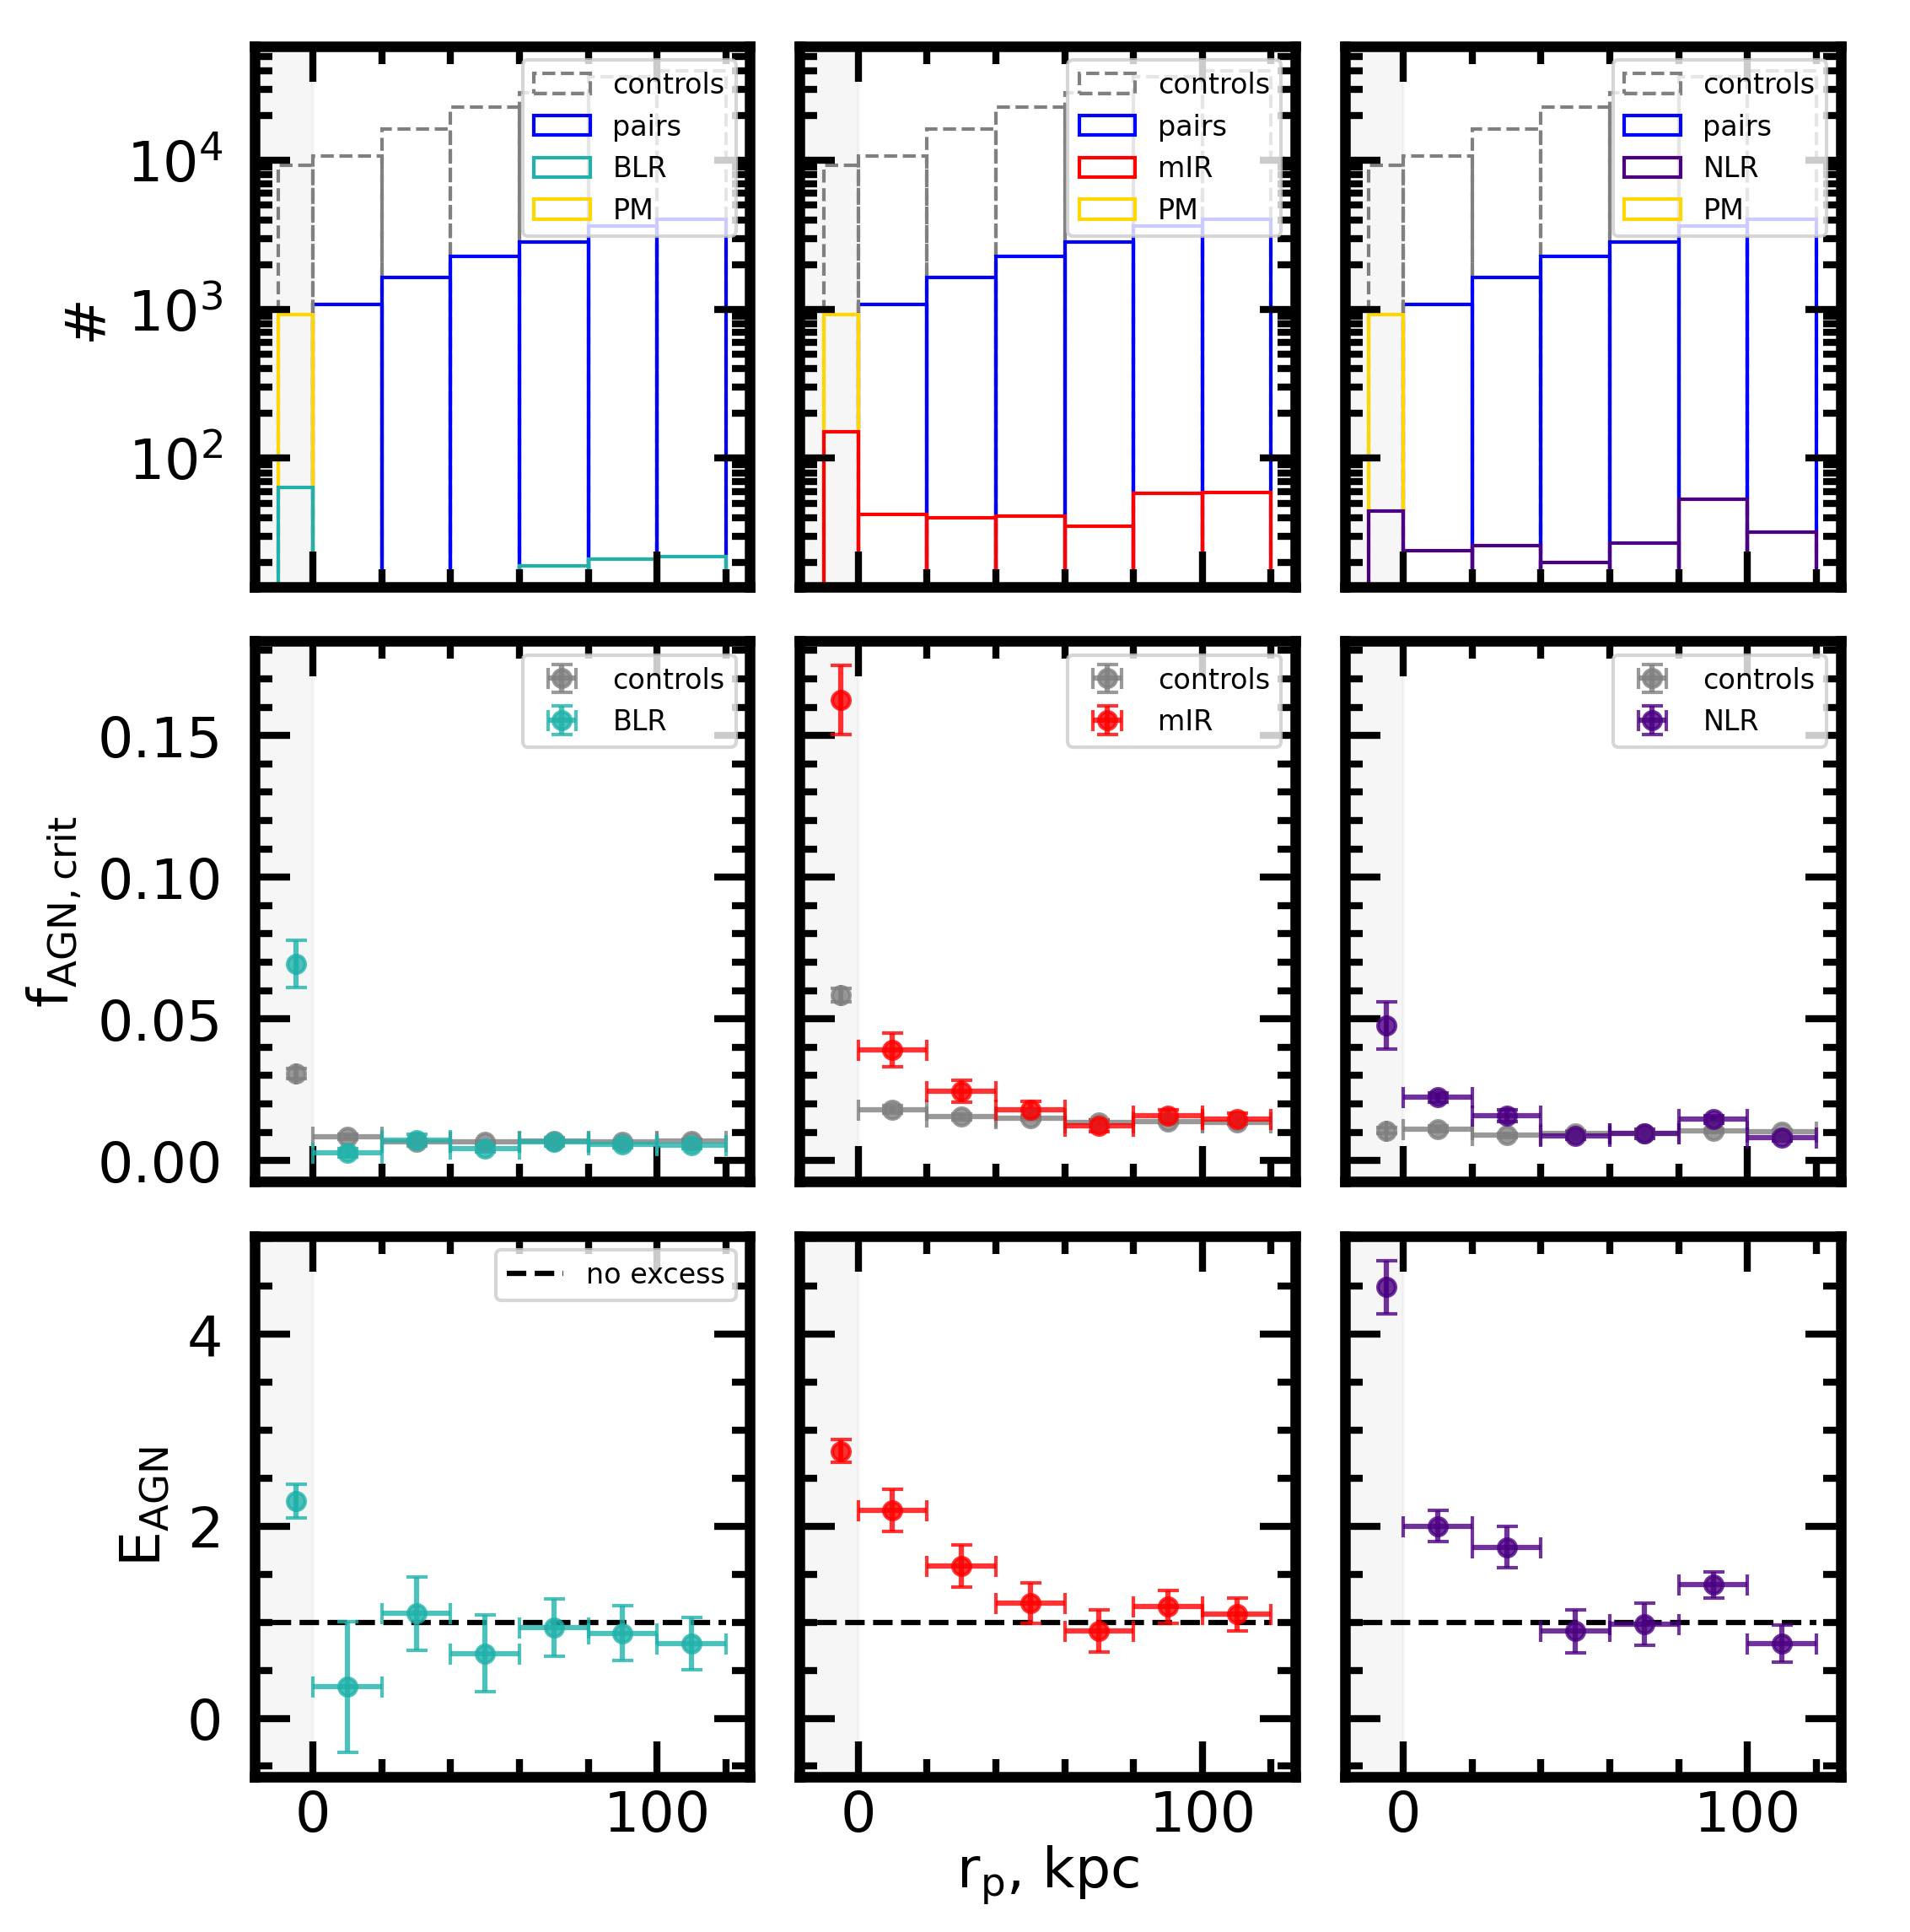

In [12]:
rp_space_ext = np.linspace(0,120,7)
def calc_exc_mw(r):
    print('doing {}'.format(str(r)))
    tar_pool = df[(df['rp']>=rp_space_ext[r])&(df['rp']<rp_space_ext[r+1])&(df['logmass']>8)&(df['z_spec']>0.005)&~(df['PM']==1)]
    ctrl_pool = df[(df['pair_ctrl_120']==1)&(df['CNN']<0.1)&(df['logmass']>8)&(df['z_spec']>0.005)]
    cpmean_m = np.mean(ctrl_pool['logmass'])
    cpstd_m = np.std(ctrl_pool['logmass'])
    m_td = ((ctrl_pool['logmass']-cpmean_m)/cpstd_m).tolist()
    cpmean_z = np.mean(ctrl_pool['z_spec'])
    cpstd_z = np.std(ctrl_pool['z_spec'])
    z_td = ((ctrl_pool['z_spec']-cpmean_z)/cpstd_z).tolist()
    treedat = np.array([[i,j] for i,j in zip(z_td,m_td)])
    tree = KDTree(treedat)
    selected = np.zeros(len(ctrl_pool))
    ctrl_IDs = []
    max_cpt = len(ctrl_pool)//len(tar_pool)
    max_cpt = max_cpt if max_cpt<10 else 10
    #print('max {} controls per target'.format(str(max_cpt)))
    for batch in tqdm(range(max_cpt)):
        ctrl_IDs_prev = ctrl_IDs
        for ind,row in tar_pool.iterrows():
            found_c1 = False
            ki=1
            while not found_c1:
                if ki==1:
                    match_ind = tree.query([(row['z_spec']-cpmean_z)/cpstd_z,(row['logmass']-cpmean_m)/cpstd_m],k=ki)[1]
                else:
                    match_ind = tree.query([(row['z_spec']-cpmean_z)/cpstd_z,(row['logmass']-cpmean_m)/cpstd_m],k=ki)[1][-1]
                if selected[match_ind]==1:
                    ki += 1
                else:
                    match = ctrl_pool.iloc[match_ind]['objID']
                    found_c1 = True
            selected[ctrl_pool['objID']==match] = 1
            ctrl_IDs.append(match)
            #These are optical or longer, we do not need to repeat the procedure for the companion galaxy
        tar_masses = tar_pool['logmass']
        tar_zs = tar_pool['z_spec']
        ctrl_masses = ctrl_pool[np.isin(ctrl_pool['objID'],ctrl_IDs)]['logmass']
        ctrl_zs = ctrl_pool[np.isin(ctrl_pool['objID'],ctrl_IDs)]['z_spec']
        pval_m = ks_2samp(tar_masses,ctrl_masses)[1]
        pval_z = ks_2samp(tar_zs,ctrl_zs)[1]
        if ((pval_m>0.9) and (pval_z>0.9)) or len(ctrl_IDs)==0: #checking that the matching stats are still OK
            pass
        else: #If the stats fail and there are control pool galaxies
            ctrl_IDs = ctrl_IDs_prev
            culprit = 'both' if (pval_m<0.9 and pval_z<0.9) else 'mass' if pval_m<0.9 else 'redshift'
            pv = '{}, {}'.format(pval_m,pval_z) if culprit=='both' else str(pval_m) if culprit=='mass' else str(pval_z)
            print('stopping control matching on batch {} due to {} stats with p = {}'.format(str(batch),culprit,pv))
            break
    ctrl_samp = ctrl_pool[np.isin(ctrl_pool['objID'],ctrl_IDs)]
    #BLR fraction in the targets and err
    bft = len(tar_pool[(tar_pool['BLR']==1)])/len(tar_pool)
    bfte = np.sqrt(bft*(1-bft)/len(tar_pool))
    #BLR fraction in the controls and err
    bfc = len(ctrl_samp[(ctrl_samp['BLR']==1)])/len(ctrl_samp)
    bfce = np.sqrt(bfc*(1-bfc)/len(ctrl_samp))
    #BLR exc and err
    bexc = bft/bfc if bfc>0 else float('NaN')
    berr = bfte/bft+bfce/bfc if (bfc>0 and bft>0) else float('NaN')
    
    #BPT frac tar & err
    bpt_agn_mask = (tar_pool['agn_sn']>5)&(tar_pool['new_K01_flag']=='AGN')&(tar_pool['Halpha_ew']<-6)&np.isnan(tar_pool['BLR'])
    oft = len(tar_pool[bpt_agn_mask])/len(tar_pool)
    ofte = np.sqrt(bft*(1-bft)/len(tar_pool))
    #BPT frac ctr & err
    bpt_agn_mask = (ctrl_samp['agn_sn']>5)&(ctrl_samp['new_K01_flag']=='AGN')&(ctrl_samp['Halpha_ew']<-6)&np.isnan(ctrl_samp['BLR'])
    ofc = len(ctrl_samp[bpt_agn_mask])/len(ctrl_samp)
    ofce = np.sqrt(ofc*(1-ofc)/len(ctrl_samp))
    #BPT exc and err
    oexc = oft/ofc if ofc>0 else float('NaN')
    oerr = ofte/oft+ofce/ofc if (ofc>0 and oft>0) else float('NaN')
    
    ng = len(tar_pool)
    nc = len(ctrl_samp)
    nb = len(tar_pool[(tar_pool['BLR']==1)])
    nw = len(tar_pool[(tar_pool['W1']-tar_pool['W2']>0.5)])
    bpt_agn_mask = (tar_pool['agn_sn']>5)&(tar_pool['new_K01_flag']=='AGN')&(tar_pool['Halpha_ew']<-6)&np.isnan(tar_pool['BLR'])
    no = len(tar_pool[bpt_agn_mask])
    
    #WISE frac tar & err
    wft = len(tar_pool[(tar_pool['W1']-tar_pool['W2']>0.5)])/len(tar_pool)
    wfte = np.sqrt(wft*(1-wft)/len(tar_pool))
    #WISE frac ctr & err
    wfc = len(ctrl_samp[(ctrl_samp['W1']-ctrl_samp['W2']>0.5)])/len(ctrl_samp)
    wfce = np.sqrt(wfc*(1-wfc)/len(ctrl_samp))
    #WISE exc and err
    wexc = wft/wfc if wfc>0 else float('NaN')
    werr = wfte/wft+wfce/wfc if (wfc>0 and wft>0) else float('NaN')
    nw = len(tar_pool[(tar_pool['W1']-tar_pool['W2']>0.5)])
    ng_w = len(tar_pool)
    nc_w = len(ctrl_samp)
    
    return [ng,nc,bft,bfte,bfc,bfce,bexc,berr,wft,wfte,wfc,wfce,wexc,werr,oft,ofte,ofc,ofce,oexc,oerr,nb,nw,no,ng_w,nc_w]

def calc_exc_mw_pm():
    print('doing PM')
    tar_pool = df[(df['PM']==1)&(df['logmass']>8)&(df['z_spec']>0.005)]
    ctrl_pool = df[(df['pair_ctrl_120']==1)&(df['CNN']<0.1)&(df['logmass']>8)&(df['z_spec']>0.005)]
    cpmean_m = np.mean(ctrl_pool['logmass'])
    cpstd_m = np.std(ctrl_pool['logmass'])
    m_td = ((ctrl_pool['logmass']-cpmean_m)/cpstd_m).tolist()
    cpmean_z = np.mean(ctrl_pool['z_spec'])
    cpstd_z = np.std(ctrl_pool['z_spec'])
    z_td = ((ctrl_pool['z_spec']-cpmean_z)/cpstd_z).tolist()
    treedat = np.array([[i,j] for i,j in zip(z_td,m_td)])
    tree = KDTree(treedat)
    selected = np.zeros(len(ctrl_pool))
    ctrl_IDs = []
    max_cpt = len(ctrl_pool)//len(tar_pool)
    max_cpt = max_cpt if max_cpt<10 else 10
    #print('max {} controls per target'.format(str(max_cpt)))
    for batch in tqdm(range(max_cpt)):
        ctrl_IDs_prev = ctrl_IDs
        for ind,row in tar_pool.iterrows():
            found_c1 = False
            ki=1
            while not found_c1:
                if ki==1:
                    match_ind = tree.query([(row['z_spec']-cpmean_z)/cpstd_z,(row['logmass']-cpmean_m)/cpstd_m],k=ki)[1]
                else:
                    match_ind = tree.query([(row['z_spec']-cpmean_z)/cpstd_z,(row['logmass']-cpmean_m)/cpstd_m],k=ki)[1][-1]
                if selected[match_ind]==1:
                    ki += 1
                else:
                    match = ctrl_pool.iloc[match_ind]['objID']
                    found_c1 = True
            selected[ctrl_pool['objID']==match] = 1
            ctrl_IDs.append(match)
        tar_masses = tar_pool['logmass']
        tar_zs = tar_pool['z_spec']
        ctrl_masses = ctrl_pool[np.isin(ctrl_pool['objID'],ctrl_IDs)]['logmass']
        ctrl_zs = ctrl_pool[np.isin(ctrl_pool['objID'],ctrl_IDs)]['z_spec']
        pval_m = ks_2samp(tar_masses,ctrl_masses)[1]
        pval_z = ks_2samp(tar_zs,ctrl_zs)[1]
        if ((pval_m>0.9) and (pval_z>0.9)) or len(ctrl_IDs)==0: #checking that the matching stats are still OK
            pass
        else: #If the stats fail and there are control pool galaxies
            ctrl_IDs = ctrl_IDs_prev
            culprit = 'both' if (pval_m<0.9 and pval_z<0.9) else 'mass' if pval_m<0.9 else 'redshift'
            pv = '{}, {}'.format(pval_m,pval_z) if culprit=='both' else str(pval_m) if culprit=='mass' else str(pval_z)
            print('stopping control matching on batch {} due to {} stats with p = {}'.format(str(batch),culprit,pv))
            break
    ctrl_samp = ctrl_pool[np.isin(ctrl_pool['objID'],ctrl_IDs)]
    #BLR fraction in the targets and err
    bft = len(tar_pool[(tar_pool['BLR']==1)])/len(tar_pool)
    bfte = np.sqrt(bft*(1-bft)/len(tar_pool))
    #BLR fraction in the controls and err
    bfc = len(ctrl_samp[(ctrl_samp['BLR']==1)])/len(ctrl_samp)
    bfce = np.sqrt(bfc*(1-bfc)/len(ctrl_samp))
    #BLR exc and err
    bexc = bft/bfc if bfc>0 else float('NaN')
    berr = bfte/bft+bfce/bfc if (bfc>0 and bft>0) else float('NaN')
    
    #BPT frac tar & err
    bpt_agn_mask = (tar_pool['agn_sn']>5)&(tar_pool['new_K01_flag']=='AGN')&(tar_pool['Halpha_ew']<-6)&np.isnan(tar_pool['BLR'])
    oft = len(tar_pool[bpt_agn_mask])/len(tar_pool)
    ofte = np.sqrt(bft*(1-bft)/len(tar_pool))
    #BPT frac ctr & err
    bpt_agn_mask = (ctrl_samp['agn_sn']>5)&(ctrl_samp['new_K01_flag']=='AGN')&(ctrl_samp['Halpha_ew']<-6)&np.isnan(ctrl_samp['BLR'])
    ofc = len(ctrl_samp[bpt_agn_mask])/len(ctrl_samp)
    ofce = np.sqrt(ofc*(1-ofc)/len(ctrl_samp))
    #BPT exc and err
    oexc = oft/ofc if ofc>0 else float('NaN')
    oerr = ofte/oft+ofce/ofc if (ofc>0 and oft>0) else float('NaN')
    
    ng = len(tar_pool)
    nc = len(ctrl_samp)
    nb = len(tar_pool[(tar_pool['BLR']==1)])
    bpt_agn_mask = (tar_pool['agn_sn']>5)&(tar_pool['new_K01_flag']=='AGN')&(tar_pool['Halpha_ew']<-6)&np.isnan(tar_pool['BLR'])
    no = len(tar_pool[bpt_agn_mask])
    
    #WISE frac tar & err
    wft = len(tar_pool[(tar_pool['W1']-tar_pool['W2']>0.5)])/len(tar_pool)
    wfte = np.sqrt(wft*(1-wft)/len(tar_pool))
    #WISE frac ctr & err
    wfc = len(ctrl_samp[(ctrl_samp['W1']-ctrl_samp['W2']>0.5)])/len(ctrl_samp)
    wfce = np.sqrt(wfc*(1-wfc)/len(ctrl_samp))
    #WISE exc and err
    wexc = wft/wfc if wfc>0 else float('NaN')
    werr = wfte/wft+wfce/wfc if (wfc>0 and wft>0) else float('NaN')
    nw = len(tar_pool[(tar_pool['W1']-tar_pool['W2']>0.5)])
    ng_w = len(tar_pool)
    nc_w = len(ctrl_samp)
    
    return [ng,nc,bft,bfte,bfc,bfce,bexc,berr,wft,wfte,wfc,wfce,wexc,werr,oft,ofte,ofc,ofce,oexc,oerr,nb,nw,no,ng_w,nc_w]

#data_ext = np.array([calc_exc_mw(r) for r in range(len(rp_space_ext)-1)])
p = Pool()
data_ext = np.array(p.map(calc_exc_mw,range(len(rp_space_ext)-1)))
p.close()
p.join()

ngs = data_ext[:,0]
ncs = data_ext[:,1]
bfts = data_ext[:,2]
bftes = data_ext[:,3]
bfcs = data_ext[:,4]
bfces = data_ext[:,5]
bexcs = data_ext[:,6]
berrs = data_ext[:,7]
wfts = data_ext[:,8]
wftes = data_ext[:,9]
wfcs = data_ext[:,10]
wfces = data_ext[:,11]
wexcs = data_ext[:,12]
werrs = data_ext[:,13]
ofts = data_ext[:,14]
oftes = data_ext[:,15]
ofcs = data_ext[:,16]
ofces = data_ext[:,17]
oexcs = data_ext[:,18]
oerrs = data_ext[:,19]
#numbers of each agn type
nbs = data_ext[:,20]
nws = data_ext[:,21]
nos = data_ext[:,22]
#sample numbers for WISE
ng_ws = data_ext[:,23]
nc_ws = data_ext[:,24]

data_ext_pm = calc_exc_mw_pm()
ng_pm = data_ext_pm[0]
nc_pm = data_ext_pm[1]
bft_pm = data_ext_pm[2]
bfte_pm = data_ext_pm[3]
bfc_pm = data_ext_pm[4]
bfce_pm = data_ext_pm[5]
bexc_pm = data_ext_pm[6]
berr_pm = data_ext_pm[7]
wft_pm = data_ext_pm[8]
wfte_pm = data_ext_pm[9]
wfc_pm = data_ext_pm[10]
wfce_pm = data_ext_pm[11]
wexc_pm = data_ext_pm[12]
werr_pm = data_ext_pm[13]
oft_pm = data_ext_pm[14]
ofte_pm = data_ext_pm[15]
ofc_pm = data_ext_pm[16]
ofce_pm = data_ext_pm[17]
oexc_pm = data_ext_pm[18]
oerr_pm = data_ext_pm[19]
#numbers of each agn type
nb_pm = data_ext_pm[20]
nw_pm = data_ext_pm[21]
no_pm = data_ext_pm[22]
#sample numbers for WISE
ng_w_pm = data_ext_pm[23]
nc_w_pm = data_ext_pm[24]

np.savez('mw_exc_stats_120.npz',data_ext=data_ext,data_ext_pm=data_ext_pm)

rp_space_plot_ext = rp_space_ext[:-1]+10
fig,axs = plt.subplots(3,3,figsize=[8,8],dpi=300,sharex=True,sharey='row')
for ax in axs.flatten():
    ax.axvspan(-40,0,alpha=0.2, color='lightgray')

plt.xlim(-17,127)
#panel 1: number of galaxies & agn in each bin
axs.flatten()[0].bar(rp_space_plot_ext,ncs,color='gray',edgecolor='gray',width=20,linestyle='dashed',label='controls',log=True,fill=False)
axs.flatten()[0].bar(rp_space_plot_ext,ngs,color='blue',edgecolor='blue',width=20,label='pairs',log=True,fill=False)
axs.flatten()[0].bar(rp_space_plot_ext,nbs,color='lightseagreen',edgecolor='lightseagreen',width=20,label='BLR',log=True,fill=False)

axs.flatten()[0].bar(-5,nc_pm,color='gray',edgecolor='gray',linestyle='dashed',width=10,log=True,fill=False)
axs.flatten()[0].bar(-5,ng_pm,color='gold',edgecolor='gold',width=10,label='PM',log=True,fill=False)
axs.flatten()[0].legend(loc='upper right', fontsize=8)
axs.flatten()[0].bar(-5,nb_pm,color='lightseagreen',edgecolor='lightseagreen',width=10,log=True,fill=False)
axs.flatten()[0].set_ylabel('#')

#panel 1: number of galaxies & agn in each bin
axs.flatten()[1].bar(rp_space_plot_ext,nc_ws,color='gray',edgecolor='gray',width=20,linestyle='dashed',label='controls',log=True,fill=False)
axs.flatten()[1].bar(rp_space_plot_ext,ng_ws,color='blue',edgecolor='blue',width=20,label='pairs',log=True,fill=False)
axs.flatten()[1].bar(rp_space_plot_ext,nws,color='red',edgecolor='red',width=20,label='mIR',log=True,fill=False)

axs.flatten()[1].bar(-5,nc_w_pm,color='gray',edgecolor='gray',linestyle='dashed',width=10,log=True,fill=False)
axs.flatten()[1].bar(-5,ng_w_pm,color='gold',edgecolor='gold',width=10,label='PM',log=True,fill=False)
axs.flatten()[1].legend(loc='upper right', fontsize=8)
axs.flatten()[1].bar(-5,nw_pm,color='red',edgecolor='red',width=10,log=True,fill=False)

#panel 1: number of galaxies & agn in each bin
axs.flatten()[2].bar(rp_space_plot_ext,ncs,color='gray',edgecolor='gray',width=20,linestyle='dashed',label='controls',log=True,fill=False)
axs.flatten()[2].bar(rp_space_plot_ext,ngs,color='blue',edgecolor='blue',width=20,label='pairs',log=True,fill=False)
axs.flatten()[2].bar(rp_space_plot_ext,nos,color='indigo',edgecolor='indigo',width=20,label='NLR',log=True,fill=False)

axs.flatten()[2].bar(-5,nc_pm,color='gray',edgecolor='gray',linestyle='dashed',width=10,log=True,fill=False)
axs.flatten()[2].bar(-5,ng_pm,color='gold',edgecolor='gold',width=10,label='PM',log=True,fill=False)
axs.flatten()[2].legend(loc='upper right', fontsize=8)
axs.flatten()[2].bar(-5,no_pm,color='indigo',edgecolor='indigo',width=10,log=True,fill=False)

#panel 2: fractions of the various AGN types

axs.flatten()[3].errorbar(rp_space_plot_ext,bfcs,xerr=10,yerr=bfces,color='gray',label='controls',marker='o',markersize=5,capsize=3,linestyle='',alpha=0.8)
axs.flatten()[4].errorbar(rp_space_plot_ext,wfcs,xerr=10,yerr=wfces,color='gray',label='controls',marker='o',markersize=5,capsize=3,linestyle='',alpha=0.8)
axs.flatten()[5].errorbar(rp_space_plot_ext,ofcs,xerr=10,yerr=ofces,color='gray',label='controls',marker='o',markersize=5,capsize=3,linestyle='',alpha=0.8)

axs.flatten()[3].errorbar(rp_space_plot_ext,bfts,xerr=10,yerr=bftes,color='lightseagreen',label='BLR',marker='o',markersize=5,capsize=3,linestyle='',alpha=0.8)
axs.flatten()[4].errorbar(rp_space_plot_ext,wfts,xerr=10,yerr=wftes,color='red',label='mIR',marker='o',markersize=5,capsize=3,linestyle='',alpha=0.8)
axs.flatten()[5].errorbar(rp_space_plot_ext,ofts,xerr=10,yerr=oftes,color='indigo',label='NLR',marker='o',markersize=5,capsize=3,linestyle='',alpha=0.8)

axs.flatten()[3].legend(loc='upper right',fontsize=8)
axs.flatten()[4].legend(loc='upper right',fontsize=8)
axs.flatten()[5].legend(loc='upper right',fontsize=8)

axs.flatten()[3].set_ylabel('$\mathrm{f_{AGN,crit}}$')

axs.flatten()[3].errorbar(-5,bfc_pm,xerr=0,yerr=bfce_pm,color='gray',label='controls',marker='o',markersize=5,capsize=3,linestyle='',alpha=0.8)
axs.flatten()[4].errorbar(-5,wfc_pm,xerr=0,yerr=wfce_pm,color='gray',label='controls',marker='o',markersize=5,capsize=3,linestyle='',alpha=0.8)
axs.flatten()[5].errorbar(-5,ofc_pm,xerr=0,yerr=ofce_pm,color='gray',label='controls',marker='o',markersize=5,capsize=3,linestyle='',alpha=0.8)

axs.flatten()[3].errorbar(-5,bft_pm,xerr=0,yerr=bfte_pm,color='lightseagreen',label='BLR',marker='o',markersize=5,capsize=3,linestyle='',alpha=0.8)
axs.flatten()[4].errorbar(-5,wft_pm,xerr=0,yerr=wfte_pm,color='red',label='mIR',marker='o',markersize=5,capsize=3,linestyle='',alpha=0.8)
axs.flatten()[5].errorbar(-5,oft_pm,xerr=0,yerr=ofte_pm,color='indigo',label='NLR',marker='o',markersize=5,capsize=3,linestyle='',alpha=0.8)

#panel 3: excesses of the various AGN types
axs.flatten()[6].hlines(1,-20,120,linestyle='dashed',color='black',label='no excess')
axs.flatten()[7].hlines(1,-20,120,linestyle='dashed',color='black',label='no excess')
axs.flatten()[8].hlines(1,-20,120,linestyle='dashed',color='black',label='no excess')

axs.flatten()[6].legend(loc='upper right',fontsize=8)
axs.flatten()[6].errorbar(rp_space_plot_ext,bexcs,xerr=10,yerr=berrs,color='lightseagreen',label='BLR',marker='o',markersize=5,capsize=3,linestyle='',alpha=0.8)
axs.flatten()[7].errorbar(rp_space_plot_ext,wexcs,xerr=10,yerr=werrs,color='red',label='mIR',marker='o',markersize=5,capsize=3,linestyle='',alpha=0.8)
axs.flatten()[8].errorbar(rp_space_plot_ext,oexcs,xerr=10,yerr=oerrs,color='indigo',label='NLR',marker='o',markersize=5,capsize=3,linestyle='',alpha=0.8)
axs.flatten()[6].set_ylabel('$\mathrm{E_{AGN}}$')

axs.flatten()[6].errorbar(-5,bexc_pm,xerr=0,yerr=berr_pm,color='lightseagreen',label='BLR',marker='o',markersize=5,capsize=3,linestyle='',alpha=0.8)
axs.flatten()[7].errorbar(-5,wexc_pm,xerr=0,yerr=werr_pm,color='red',label='mIR',marker='o',markersize=5,capsize=3,linestyle='',alpha=0.8)
axs.flatten()[8].errorbar(-5,oexc_pm,xerr=0,yerr=oerr_pm,color='indigo',label='NLR',marker='o',markersize=5,capsize=3,linestyle='',alpha=0.8)

fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel('r$\mathrm{_{p}}$, kpc',labelpad=0.1)

plt.tight_layout()
plt.subplots_adjust(hspace=0.1,wspace=0.1)
plt.show()

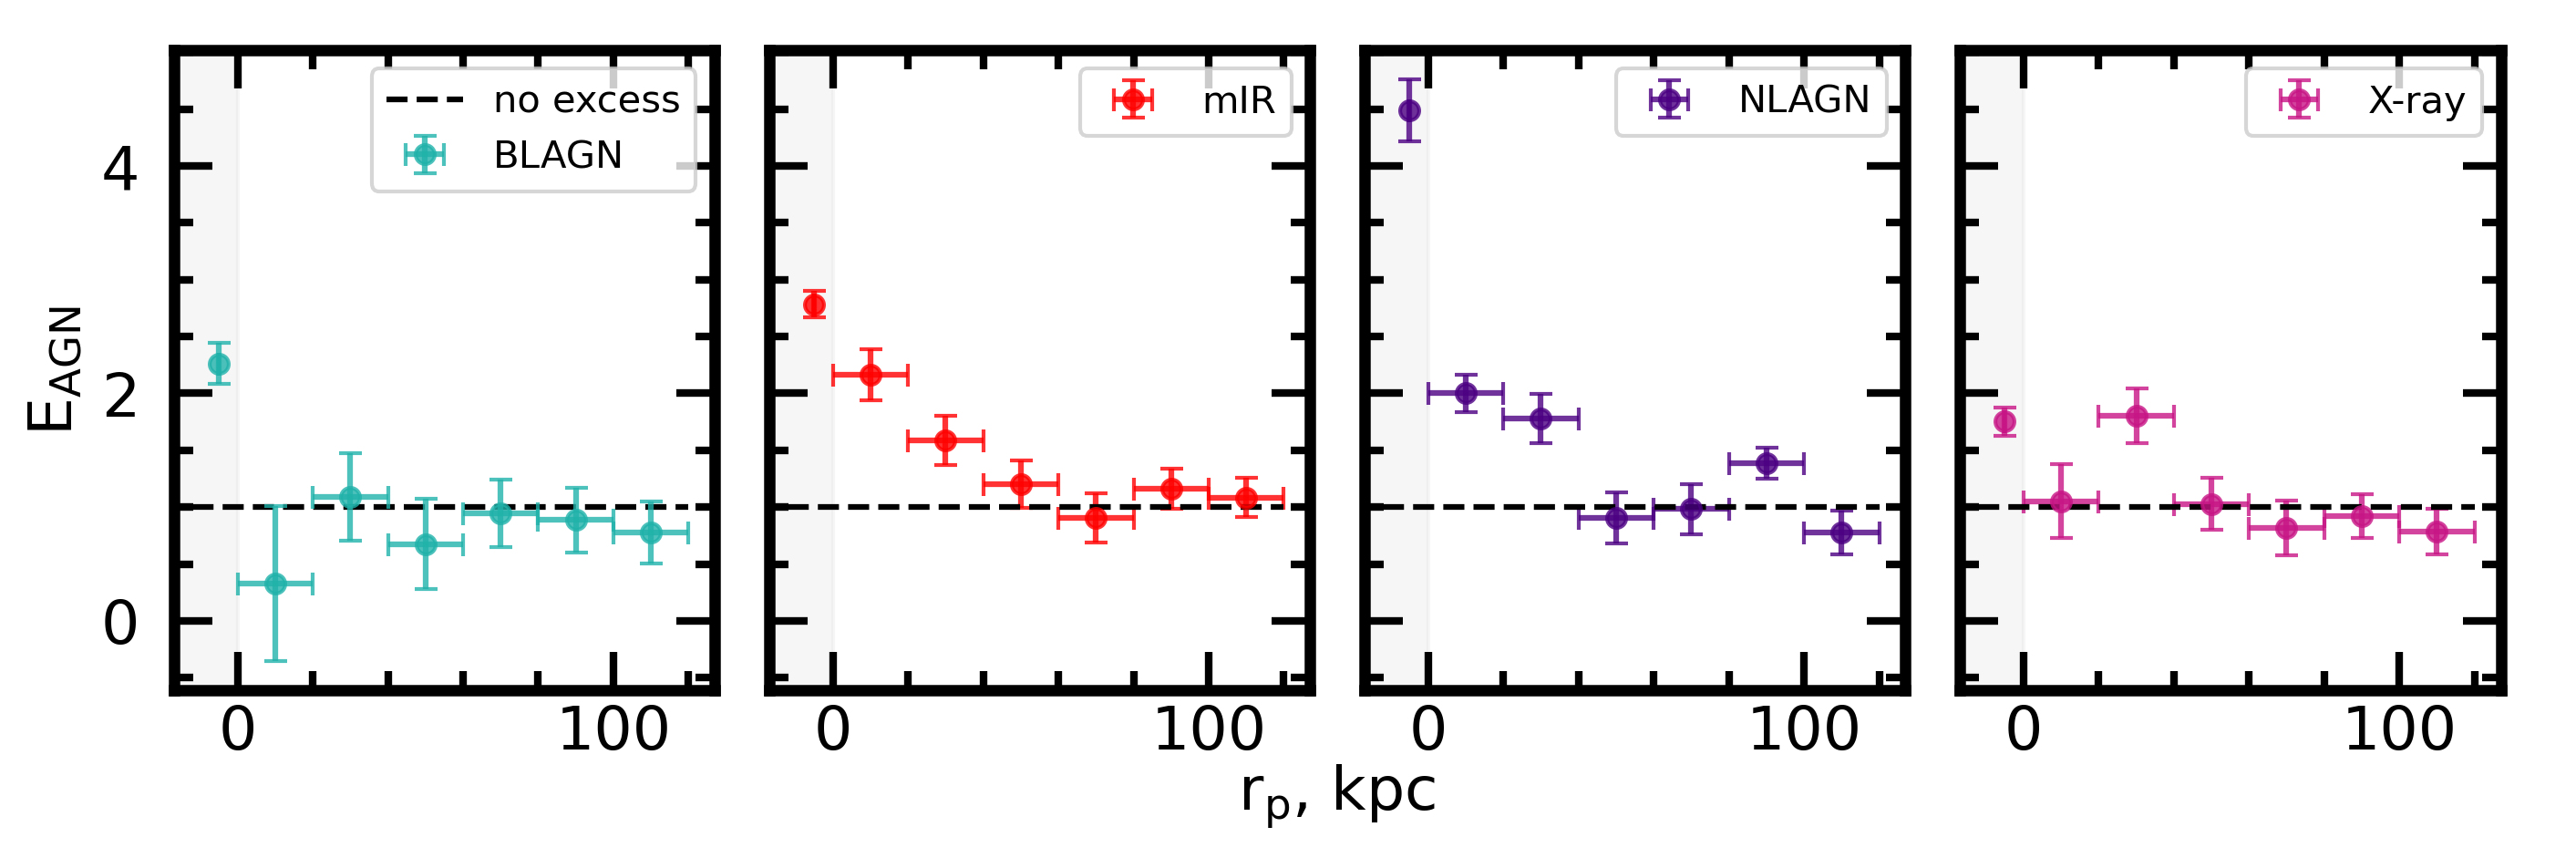

In [83]:
rp_space_plot_ext = rp_space_ext[:-1]+10
fig,axs = plt.subplots(1,4,figsize=[10,3.5],dpi=300,sharex=True,sharey=True)
for ax in axs.flatten():
    ax.axvspan(-40,0,alpha=0.2, color='lightgray')

plt.xlim(-17,127)
#panel 3: excesses of the various AGN types
axs.flatten()[0].hlines(1,-20,120,linestyle='dashed',color='black',label='no excess')

axs.flatten()[0].errorbar(rp_space_plot_ext,bexcs,xerr=10,yerr=berrs,color='lightseagreen',label='BLAGN',marker='o',markersize=5,capsize=3,linestyle='',alpha=0.8)
axs.flatten()[1].errorbar(rp_space_plot_ext,wexcs,xerr=10,yerr=werrs,color='red',label='mIR',marker='o',markersize=5,capsize=3,linestyle='',alpha=0.8)
axs.flatten()[2].errorbar(rp_space_plot_ext,oexcs,xerr=10,yerr=oerrs,color='indigo',label='NLAGN',marker='o',markersize=5,capsize=3,linestyle='',alpha=0.8)
axs.flatten()[3].errorbar(rp_space_plot_ext,excs_ext_x,xerr=10,yerr=exces_ext_x,color='mediumvioletred',label='X-ray',marker='o',markersize=5,capsize=3,linestyle='',alpha=0.8)
axs.flatten()[0].set_ylabel('$\mathrm{E_{AGN}}$')

for ax in axs.flatten():
    ax.legend(loc='upper right',fontsize=10)

axs.flatten()[1].hlines(1,-20,120,linestyle='dashed',color='black',label='no excess')
axs.flatten()[2].hlines(1,-20,120,linestyle='dashed',color='black',label='no excess')
axs.flatten()[3].hlines(1,-20,120,linestyle='dashed',color='black',label='no excess')

axs.flatten()[0].errorbar(-5,bexc_pm,xerr=0,yerr=berr_pm,color='lightseagreen',label='BLAGN',marker='o',markersize=5,capsize=3,linestyle='',alpha=0.8)
axs.flatten()[1].errorbar(-5,wexc_pm,xerr=0,yerr=werr_pm,color='red',label='mIR',marker='o',markersize=5,capsize=3,linestyle='',alpha=0.8)
axs.flatten()[2].errorbar(-5,oexc_pm,xerr=0,yerr=oerr_pm,color='indigo',label='NLAGN',marker='o',markersize=5,capsize=3,linestyle='',alpha=0.8)
axs.flatten()[3].errorbar(-5,exc_x,xerr=0,yerr=exce_x,color='mediumvioletred',label='X-ray',marker='o',markersize=5,capsize=3,linestyle='',alpha=0.8)

fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel('r$\mathrm{_{p}}$, kpc',labelpad=0.1)

plt.tight_layout()
plt.subplots_adjust(hspace=0.1,wspace=0.1)
plt.show()

[  0.  20.  40.  60.  80. 100. 120.]
doing 0
316
316
6320
316 3160
determining AGN statuses
aft = 0.03872447606766116
aft_err = 0.007674642924624223
afc = 0.02922450417661482
afc_err = 0.002118724259850584
exc = 1.3250687106147085
exc_err = 0.2706840533996572
doing 1
485
485
9700
485 4850
determining AGN statuses
aft = 0.046439120708350434
aft_err = 0.0067566331498639855
afc = 0.049037384064328005
afc_err = 0.0021926004668104213
exc = 0.9470146418787526
exc_err = 0.19020725976267955
doing 2
629
629
12580
629 6290
determining AGN statuses
aft = 0.029038468471859535
aft_err = 0.004734210290560936
afc = 0.029693638270838374
afc_err = 0.0015133724570397299
exc = 0.9779356846404952
exc_err = 0.21399858695971424
doing 3
799
799
15980
799 7990
determining AGN statuses
aft = 0.021507890419836695
aft_err = 0.003629018515754326
afc = 0.027795558102074125
afc_err = 0.0013004034478386736
exc = 0.7737887593712954
exc_err = 0.21551421342859728
doing 4
1089
1089
21780
1089 10890
determining AGN statu

  0%|          | 0/10 [00:00<?, ?it/s]

923 9230
determining AGN statuses
aft = 0.11985916619898629
aft_err = 0.007559548591438633
afc = 0.037991447523505695
afc_err = 0.001407072705675167
exc = 3.154898641985889
exc_err = 0.10010682320139573


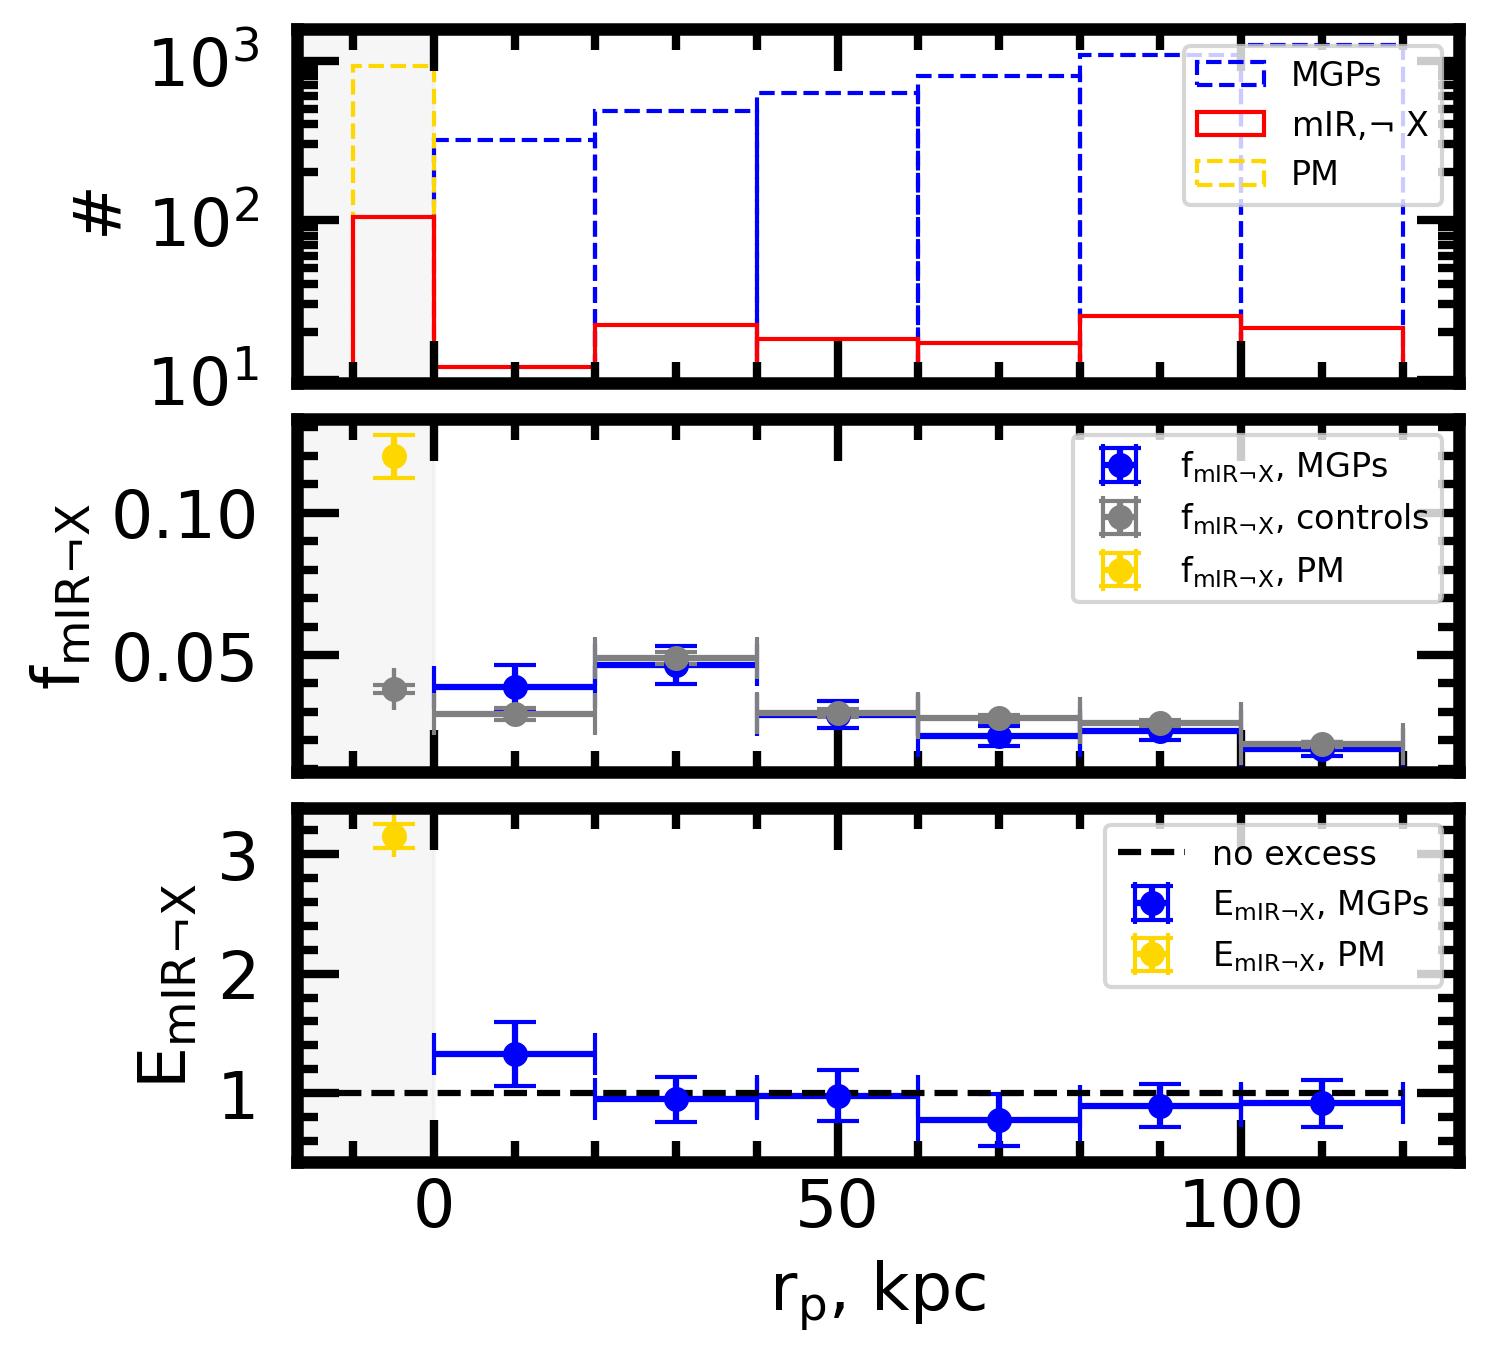

In [84]:
def calc_exc_ext_any(r):
    print('doing {}'.format(str(r)))
    tar_samp = pd.read_csv('./nov6_match_track/tar_samp_strict_120_{}.csv'.format(str(r)))#df[(df['rp']>=rp_space_ext[r])&(df['rp']<rp_space_ext[r+1])&(df['logmass']>8)&(df['z_spec']>0.005)]
    ctrl_samp = pd.read_csv('./nov6_match_track/ctrl_samp_strict_120_{}.csv'.format(str(r)))#pd.DataFrame({},columns=[key for key in df.keys()])
    companion_samp = pd.read_csv('./nov6_match_track/companion_samp_strict_120_{}.csv'.format(str(r)))#pd.DataFrame({},columns=[key for key in df.keys()])
    tars = [row for ind,row in tar_samp.iterrows()]
    comps = [row for ind,row in companion_samp.iterrows()]
    ctrls = [row for ind,row in ctrl_samp.iterrows()]
    print(len(tars))
    print(len(comps))
    print(len(ctrls))
    tar_data = []
    ctrl_data = []
    for batch in range(len(ctrls)//(2*len(tars))):
        for i in range(len(tars)):
            row = tars[i]
            companion = comps[i]
            match = ctrls[batch*len(tars)*2+2*i]
            match2 = ctrls[batch*len(tars)*2+2*i+1]
            #What L_X to add for the target galaxy pair?
            if batch==0: #only add the target LXs if it's the first pass through the data
                tLX1 = row['L_X_e']
                tLX2 = companion['L_X_e']
                tW1 = row['W1']-row['W2']
                tW2 = companion['W1']-companion['W2']
                if np.isnan(tLX1) and np.isnan(tLX2) and (tW1>0.5 or tW2>0.5):
                    tar_data.append(1)
                else:
                    tar_data.append(0)
            #Always add control LXs regardless of what round, since controls are unique
            cLX1 = match['L_X_e']
            cLX2 = match2['L_X_e']
            cW1 = match['W1']-match['W2']
            cW2 = companion['W1']-companion['W2']
            if np.isnan(cLX1) and np.isnan(cLX2) and (cW1>0.5 or cW2>0.5):
                ctrl_data.append(1)
            else:
                ctrl_data.append(0)
    tar_data = np.array(tar_data)
    ctrl_data = np.array(ctrl_data)
    print(len(tar_data),len(ctrl_data))
    print('determining AGN statuses')
    #calculating target AGN fractions
    aft = len(tar_data[tar_data==1])/(len(tar_data))
    aft = 1-np.sqrt(1-2*aft)
    aft_err = np.sqrt(aft*(1-aft)/(2*(len(tar_data))))
    #calculating control agn fractions
    afc = len(ctrl_data[ctrl_data==1])/(len(ctrl_data))
    afc = 1-np.sqrt(1-2*afc)
    afc_err = np.sqrt(afc*(1-afc)/(2*(len(ctrl_data))))
    print('aft = {}'.format(str(aft)))
    print('aft_err = {}'.format(str(aft_err)))
    print('afc = {}'.format(str(afc)))
    print('afc_err = {}'.format(str(afc_err)))
    exc = aft/afc
    err = aft_err/aft+afc_err/afc
    print('exc = {}'.format(str(aft/afc)))
    print('exc_err = {}'.format(str(aft_err/aft+afc_err/afc)))
    #format: [number of galaxies, number of AGN, AFTs, AFTes, AFCs, AFCes, excs, excerrs]
    return [len(tar_data),len(tar_data[tar_data==1]),aft,aft_err,afc,afc_err,exc,err]
rp_space_ext = np.linspace(0,120,7)
print(rp_space_ext)
p = Pool()
#data_ext_any = np.array(p.map(calc_exc_ext_any,range(len(rp_space_ext)-1)))
data_ext = np.array([calc_exc_ext_any(i) for i in range(len(rp_space_ext)-1)])
p.close()
p.join()

ngs_ext_any = data_ext[:,0]
nas_ext_any = data_ext[:,1]
afts_ext_any = data_ext[:,2]
aftes_ext_any = data_ext[:,3]
afcs_ext_any = data_ext[:,4]
afces_ext_any = data_ext[:,5]
excs_ext_any = data_ext[:,6]
exces_ext_any = data_ext[:,7]
exces2_ext_any = exces_ext_any#np.sqrt(2)*(aftes_ext/afts_ext+afces_ext/afcs_ext)
aftes2_ext_any = aftes_ext_any#np.sqrt(2)*aftes_ext
afces2_ext_any = afces_ext_any#np.sqrt(2)*afces_ext

def calc_exc_ext_pm_any():
    tar_samp = pd.read_csv('./nov6_match_track/tar_pool_120_pm.csv')#df[(df['rp']>=rp_space_ext[r])&(df['rp']<rp_space_ext[r+1])&(df['logmass']>8)&(df['z_spec']>0.005)]
    tars = [row for ind,row in tar_samp.iterrows()]
    ctrl_samp = pd.read_csv('./nov6_match_track/ctrl_samp_120_pm.csv')#pd.DataFrame({},columns=[key for key in df.keys()])
    ctrls = [row for ind,row in ctrl_samp.iterrows()]
    tar_data = []
    ctrl_data = []
    for batch in tqdm(range(10)):
        for i in range(len(tars)):
            row = tars[i]
            match = ctrls[batch*len(tars)+i]
            #What L_X to add for the target galaxy pair?
            if batch==0: #only add the target LXs if it's the first pass through the data
                tLX1 = row['L_X_e']
                tW1 = row['W1']-row['W2']
                if np.isnan(tLX1) and tW1>0.5:
                    tar_data.append(1)
                else:
                    tar_data.append(0)
            #Always add control LXs regardless of what round, since controls are unique
            cLX1 = match['L_X_e']
            cW1 = match['W1']-match['W2']
            if np.isnan(cLX1) and cW1>0.5:
                ctrl_data.append(1)
            else:
                ctrl_data.append(0)
    tar_data = np.array(tar_data)
    ctrl_data = np.array(ctrl_data)
    print(len(tar_data),len(ctrl_data))
    print('determining AGN statuses')
    #calculating target AGN fractions
    aft = len(tar_data[tar_data==1])/(len(tar_data))
    aft = 1-np.sqrt(1-2*aft)
    aft_err = np.sqrt(aft*(1-aft)/(2*(len(tar_data))))
    #calculating control agn fractions
    afc = len(ctrl_data[ctrl_data==1])/(len(ctrl_data))
    afc = 1-np.sqrt(1-2*afc)
    afc_err = np.sqrt(afc*(1-afc)/(2*(len(ctrl_data))))
    print('aft = {}'.format(str(aft)))
    print('aft_err = {}'.format(str(aft_err)))
    print('afc = {}'.format(str(afc)))
    print('afc_err = {}'.format(str(afc_err)))
    exc = aft/afc
    err = aft_err/aft+afc_err/afc
    print('exc = {}'.format(str(aft/afc)))
    print('exc_err = {}'.format(str(aft_err/aft+afc_err/afc)))
    #format: [number of galaxies, number of AGN, AFTs, AFTes, AFCs, AFCes, excs, excerrs]
    return [len(tar_data),len(tar_data[tar_data==1]),aft,aft_err,afc,afc_err,exc,err]
ng_any,nagn_any,aft_any,afte_any,afc_any,afce_any,exc_any,exce_any = calc_exc_ext_pm_any()
rp_space_plot_ext = rp_space_ext[:-1]+10
fig,axs = plt.subplots(3,1,figsize=[5,5],dpi=300,sharex=True)
axs.flatten()[0].axvspan(-40,0,alpha=0.2, color='lightgray')
axs.flatten()[1].axvspan(-40,0,alpha=0.2, color='lightgray')
axs.flatten()[2].axvspan(-40,0,alpha=0.2, color='lightgray')
plt.xlim(-17,127)
#panel 1: number of galaxies & agn in each bin
axs.flatten()[0].bar(rp_space_plot_ext,ngs_ext_any,color='gray',edgecolor='blue',width=20,linestyle='dashed',label='MGPs',log=True,fill=False)
axs.flatten()[0].bar(rp_space_plot_ext,nas_ext_any,color='red',edgecolor='red',width=20,label=r'mIR,$\neg$ X',log=True,fill=False)
axs.flatten()[0].bar(-5,ng_any,color='gold',edgecolor='gold',linestyle='dashed',width=10,label='PM',log=True,fill=False)
axs.flatten()[0].bar(-5,nagn_any,color='red',edgecolor='red',width=10,log=True,fill=False)
axs.flatten()[0].set_ylabel('#')
axs.flatten()[0].legend(loc='upper right', fontsize=8)
#panel 2: fractions and errors of AGN in pair & control samples
axs.flatten()[1].errorbar(rp_space_plot_ext,afts_ext_any,xerr=10,yerr=aftes2_ext_any,color='blue',label=r'f$\mathrm{_{mIR \neg X}}$, MGPs',marker='o',markersize=5,capsize=5,linestyle='')
axs.flatten()[1].errorbar(rp_space_plot_ext,afcs_ext_any,xerr=10,yerr=afces2_ext_any,color='gray',label=r'f$\mathrm{_{mIR \neg X}}$, controls',marker='o',markersize=5,capsize=5,linestyle='')
axs.flatten()[1].errorbar(-5,aft_any,xerr=0,yerr=afte_any,color='gold',label=r'f$\mathrm{_{mIR \neg X}}$, PM',marker='o',markersize=5,capsize=5,linestyle='')
axs.flatten()[1].errorbar(-5,afc_any,xerr=0,yerr=afce_any,color='gray',marker='o',markersize=5,capsize=5,linestyle='')
axs.flatten()[1].legend(loc='upper right',fontsize=8)
axs.flatten()[1].set_ylabel(r'f$\mathrm{_{mIR \neg X}}$')
#panel 3: excess calcs
axs.flatten()[2].errorbar(rp_space_plot_ext,excs_ext_any,xerr=10,yerr=exces2_ext_any,color='blue',label=r'E$\mathrm{_{mIR \neg X}}$, MGPs',marker='o',markersize=5,capsize=5,linestyle='')
axs.flatten()[2].errorbar(-5,exc_any,xerr=0,yerr=exce_any,color='gold',label=r'E$\mathrm{_{mIR \neg X}}$, PM',marker='o',markersize=5,capsize=5,linestyle='')
axs.flatten()[2].hlines(1,-20,120,linestyle='dashed',color='black',label='no excess')
axs.flatten()[2].set_ylabel(r'$\mathrm{E_{mIR \neg X}}$')
axs.flatten()[2].set_xlabel('r$\mathrm{_{p}}$, kpc')
axs.flatten()[2].legend(loc='upper right',fontsize=8)
#plt.tight_layout()
plt.subplots_adjust(hspace=0.1)
plt.show()

/tmp/ipykernel_170/333123217.py:21: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  axs[1].set_ylim(0,10**5.5)


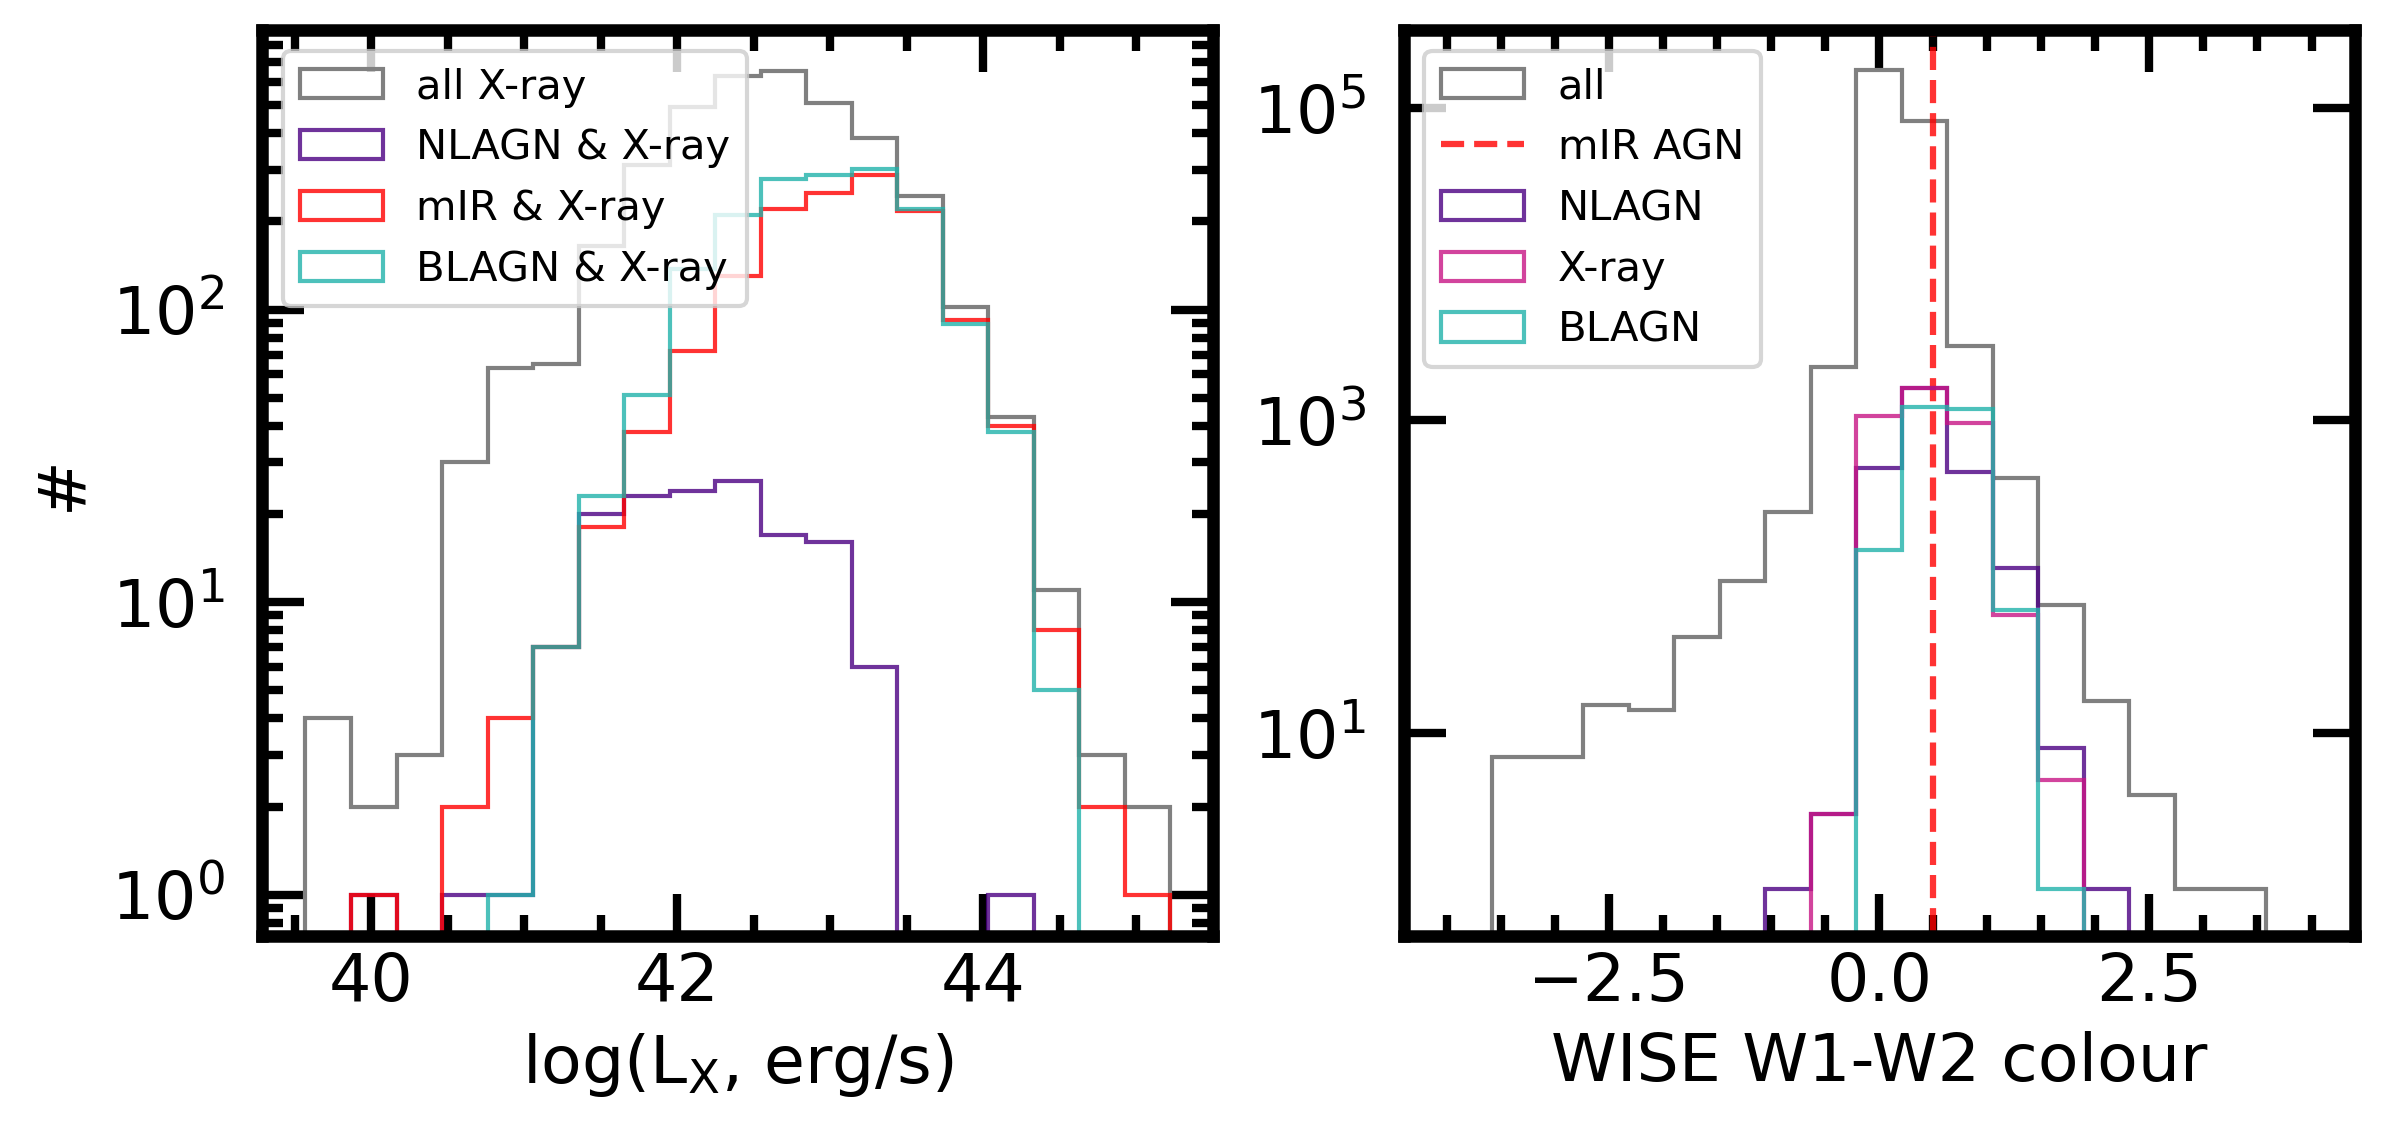

In [85]:
#L_X stats for the different AGN types
fig,axs = plt.subplots(1,2,figsize=[9,4],dpi=300)
bins = np.linspace(np.amin(df['L_X_e'][(df['z_spec']>0.005)&(df['logmass']>8)]),np.amax(df['L_X_e'][(df['z_spec']>0.005)&(df['logmass']>8)]),20)
bpt_agn_mask = (df['agn_sn']>5)&(df['new_K01_flag']=='AGN')&(df['Halpha_ew']<-6)&(np.isnan(df['BLR']))
axs[0].hist(df['L_X_e'][(df['z_spec']>0.005)&(df['logmass']>8)],histtype='step',label='all X-ray',bins=bins,log=True,color='gray')
axs[0].hist(df['L_X_e'][(bpt_agn_mask)&(df['z_spec']>0.005)&(df['logmass']>8)],histtype='step',label='NLAGN & X-ray',bins=bins,log=True,color='indigo',alpha=0.8)
axs[0].hist(df['L_X_e'][((df['W1']-df['W2'])>0.5)&(df['z_spec']>0.005)&(df['logmass']>8)],histtype='step',label='mIR & X-ray',bins=bins,log=True,color='red',alpha=0.8)
axs[0].hist(df['L_X_e'][(df['BLR']==1)&(df['z_spec']>0.005)&(df['logmass']>8)],histtype='step',label='BLAGN & X-ray',bins=bins,log=True,color='lightseagreen',alpha=0.8)
axs[0].legend(loc='upper left',fontsize=10)
axs[0].set_xlabel('log(L$\mathrm{_{X}}$, erg/s)')
axs[0].set_ylabel('#')

bins=np.linspace(-4,4,20)
axs[1].hist(df['W1'][(df['z_spec']>0.005)&(df['logmass']>8)]-df['W2'][(df['z_spec']>0.005)&(df['logmass']>8)],histtype='step',label='all',bins=bins,log=True,color='gray')
axs[1].vlines(0.5,0,1e6,color='red',linestyle='dashed',label='mIR AGN',alpha=0.8)
axs[1].hist(df['W1'][(bpt_agn_mask)&(df['z_spec']>0.005)&(df['logmass']>8)]-df['W2'][(bpt_agn_mask)&(df['z_spec']>0.005)&(df['logmass']>8)],histtype='step',label='NLAGN',bins=bins,log=True,color='indigo',alpha=0.8)
axs[1].hist(df['W1'][(df['L_X_e']>0)&(df['z_spec']>0.005)&(df['logmass']>8)]-df['W2'][(df['L_X_e']>0)&(df['z_spec']>0.005)&(df['logmass']>8)],histtype='step',label='X-ray',bins=bins,log=True,color='mediumvioletred',alpha=0.8)
axs[1].hist(df['W1'][(df['BLR']==1)&(df['z_spec']>0.005)&(df['logmass']>8)]-df['W2'][(df['BLR']==1)&(df['z_spec']>0.005)&(df['logmass']>8)],histtype='step',label='BLAGN',bins=bins,log=True,color='lightseagreen',alpha=0.8)
axs[1].legend(loc='upper left',fontsize=10)
axs[1].set_xlabel('WISE W1-W2 colour')
axs[1].set_ylim(0,10**5.5)
plt.subplots_adjust(wspace=0.2)
plt.show()

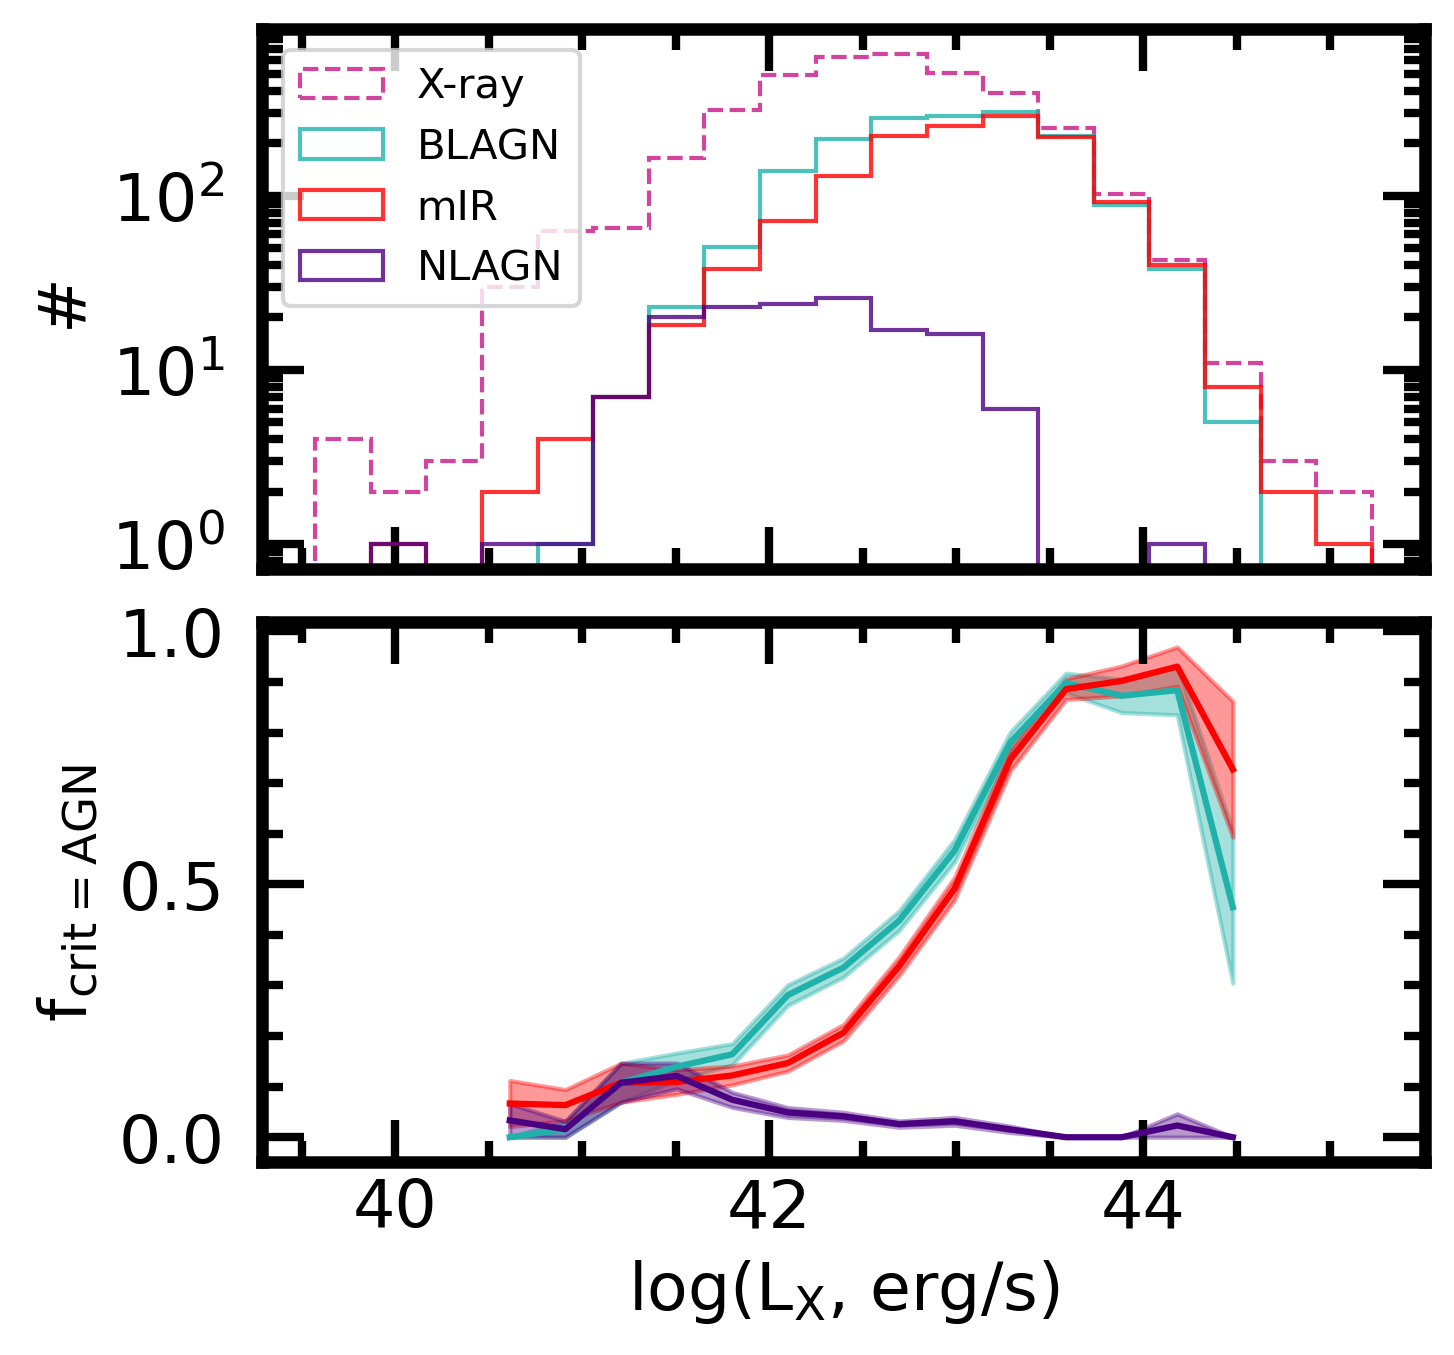

In [86]:
fig,axs = plt.subplots(2,1,figsize=[5,5],sharex=True,dpi=300)
def agn_frac(lxl,lxu,crit):
    den = len(df[(df['L_X_e']>lxl)&(df['L_X_e']<lxu)&(df['z_spec']>0.005)&(df['logmass']>8)])
    num = len(df[(df['L_X_e']>lxl)&(df['L_X_e']<lxu)&(crit)&(df['z_spec']>0.005)&(df['logmass']>8)])
    fr = num/den if den>10 else float('NaN')
    err = np.sqrt(fr*(1-fr)/den) if den>10 else float('NaN')
    return [fr,err]
def frac_series(crit,bins):
    xspace = np.linspace(np.amin(df['L_X_e'][(df['z_spec']>0.005)&(df['logmass']>8)]),np.amax(df['L_X_e'][(df['z_spec']>0.005)&(df['logmass']>8)]),bins)
    dxspace = np.array([(xspace[i+1]-xspace[i]) for i in range(len(xspace)-1)])
    xspace_plot = [xspace[i]+(xspace[i+1]-xspace[i])/2 for i in range(len(xspace)-1)]
    lxls = xspace[:-1]
    lxus = xspace[:-1]+dxspace
    dat = np.array([agn_frac(lxl,lxu,crit) for lxl,lxu in zip(lxls,lxus)])
    frs = dat[:,0]
    ers = dat[:,1]
    return [xspace_plot,frs,ers]
nbins = 20
plot_data = frac_series((df['BLR']==1),nbins)
axs.flatten()[1].plot(plot_data[0],plot_data[1],color='lightseagreen')
axs.flatten()[1].fill_between(plot_data[0],(plot_data[1]+plot_data[2]),(plot_data[1]-plot_data[2]),alpha=0.4,color='lightseagreen')

plot_data = frac_series(((df['W1']-df['W2']>0.5)),nbins)
axs.flatten()[1].plot(plot_data[0],plot_data[1],color='red')
axs.flatten()[1].fill_between(plot_data[0],(plot_data[1]+plot_data[2]),(plot_data[1]-plot_data[2]),alpha=0.4,color='red')

plot_data = frac_series(bpt_agn_mask,nbins)
axs.flatten()[1].plot(plot_data[0],plot_data[1],color='indigo')
axs.flatten()[1].fill_between(plot_data[0],(plot_data[1]+plot_data[2]),(plot_data[1]-plot_data[2]),alpha=0.4,color='indigo')

# plot_data = frac_series((df['HERG']==1),nbins)
# axs.flatten()[1].plot(plot_data[0],plot_data[1],color='sienna')
# axs.flatten()[1].fill_between(plot_data[0],(plot_data[1]+plot_data[2]),(plot_data[1]-plot_data[2]),alpha=0.4,color='sienna')

bins = np.linspace(np.amin(df['L_X_e'][(df['z_spec']>0.005)&(df['logmass']>8)]),np.amax(df['L_X_e'][(df['z_spec']>0.005)&(df['logmass']>8)]),nbins)
axs.flatten()[0].hist(df['L_X_e'][(df['z_spec']>0.005)&(df['logmass']>8)],bins=bins,color='mediumvioletred',linestyle='dashed',histtype='step',log=True,alpha=0.8,label='X-ray')
axs.flatten()[0].hist(df['L_X_e'][(df['BLR']==1)&(df['z_spec']>0.005)&(df['logmass']>8)],bins=bins,color='lightseagreen',histtype='step',log=True,alpha=0.8,label='BLAGN')
axs.flatten()[0].hist(df['L_X_e'][(df['W1']-df['W2']>0.5)&(df['z_spec']>0.005)&(df['logmass']>8)],bins=bins,color='red',histtype='step',log=True,alpha=0.8,label='mIR')
axs.flatten()[0].hist(df['L_X_e'][(bpt_agn_mask)&(df['z_spec']>0.005)&(df['logmass']>8)],bins=bins,color='indigo',histtype='step',log=True,alpha=0.8,label='NLAGN')

axs.flatten()[0].legend(loc='upper left',fontsize=10)
axs.flatten()[1].set_xlabel('log(L$\mathrm{_{X}}$, erg/s)')
axs.flatten()[1].set_ylabel('$\mathrm{f_{crit=AGN}}$')
axs.flatten()[0].set_ylabel('#')
plt.subplots_adjust(hspace=0.1)
plt.show()

/tmp/ipykernel_170/2996046930.py:117: FutureWarning: The input object of type 'Bbox' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Bbox', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  bboxes = np.array(list(map(get_bbox, axs.flat)), mtrans.Bbox).reshape(axs.shape)


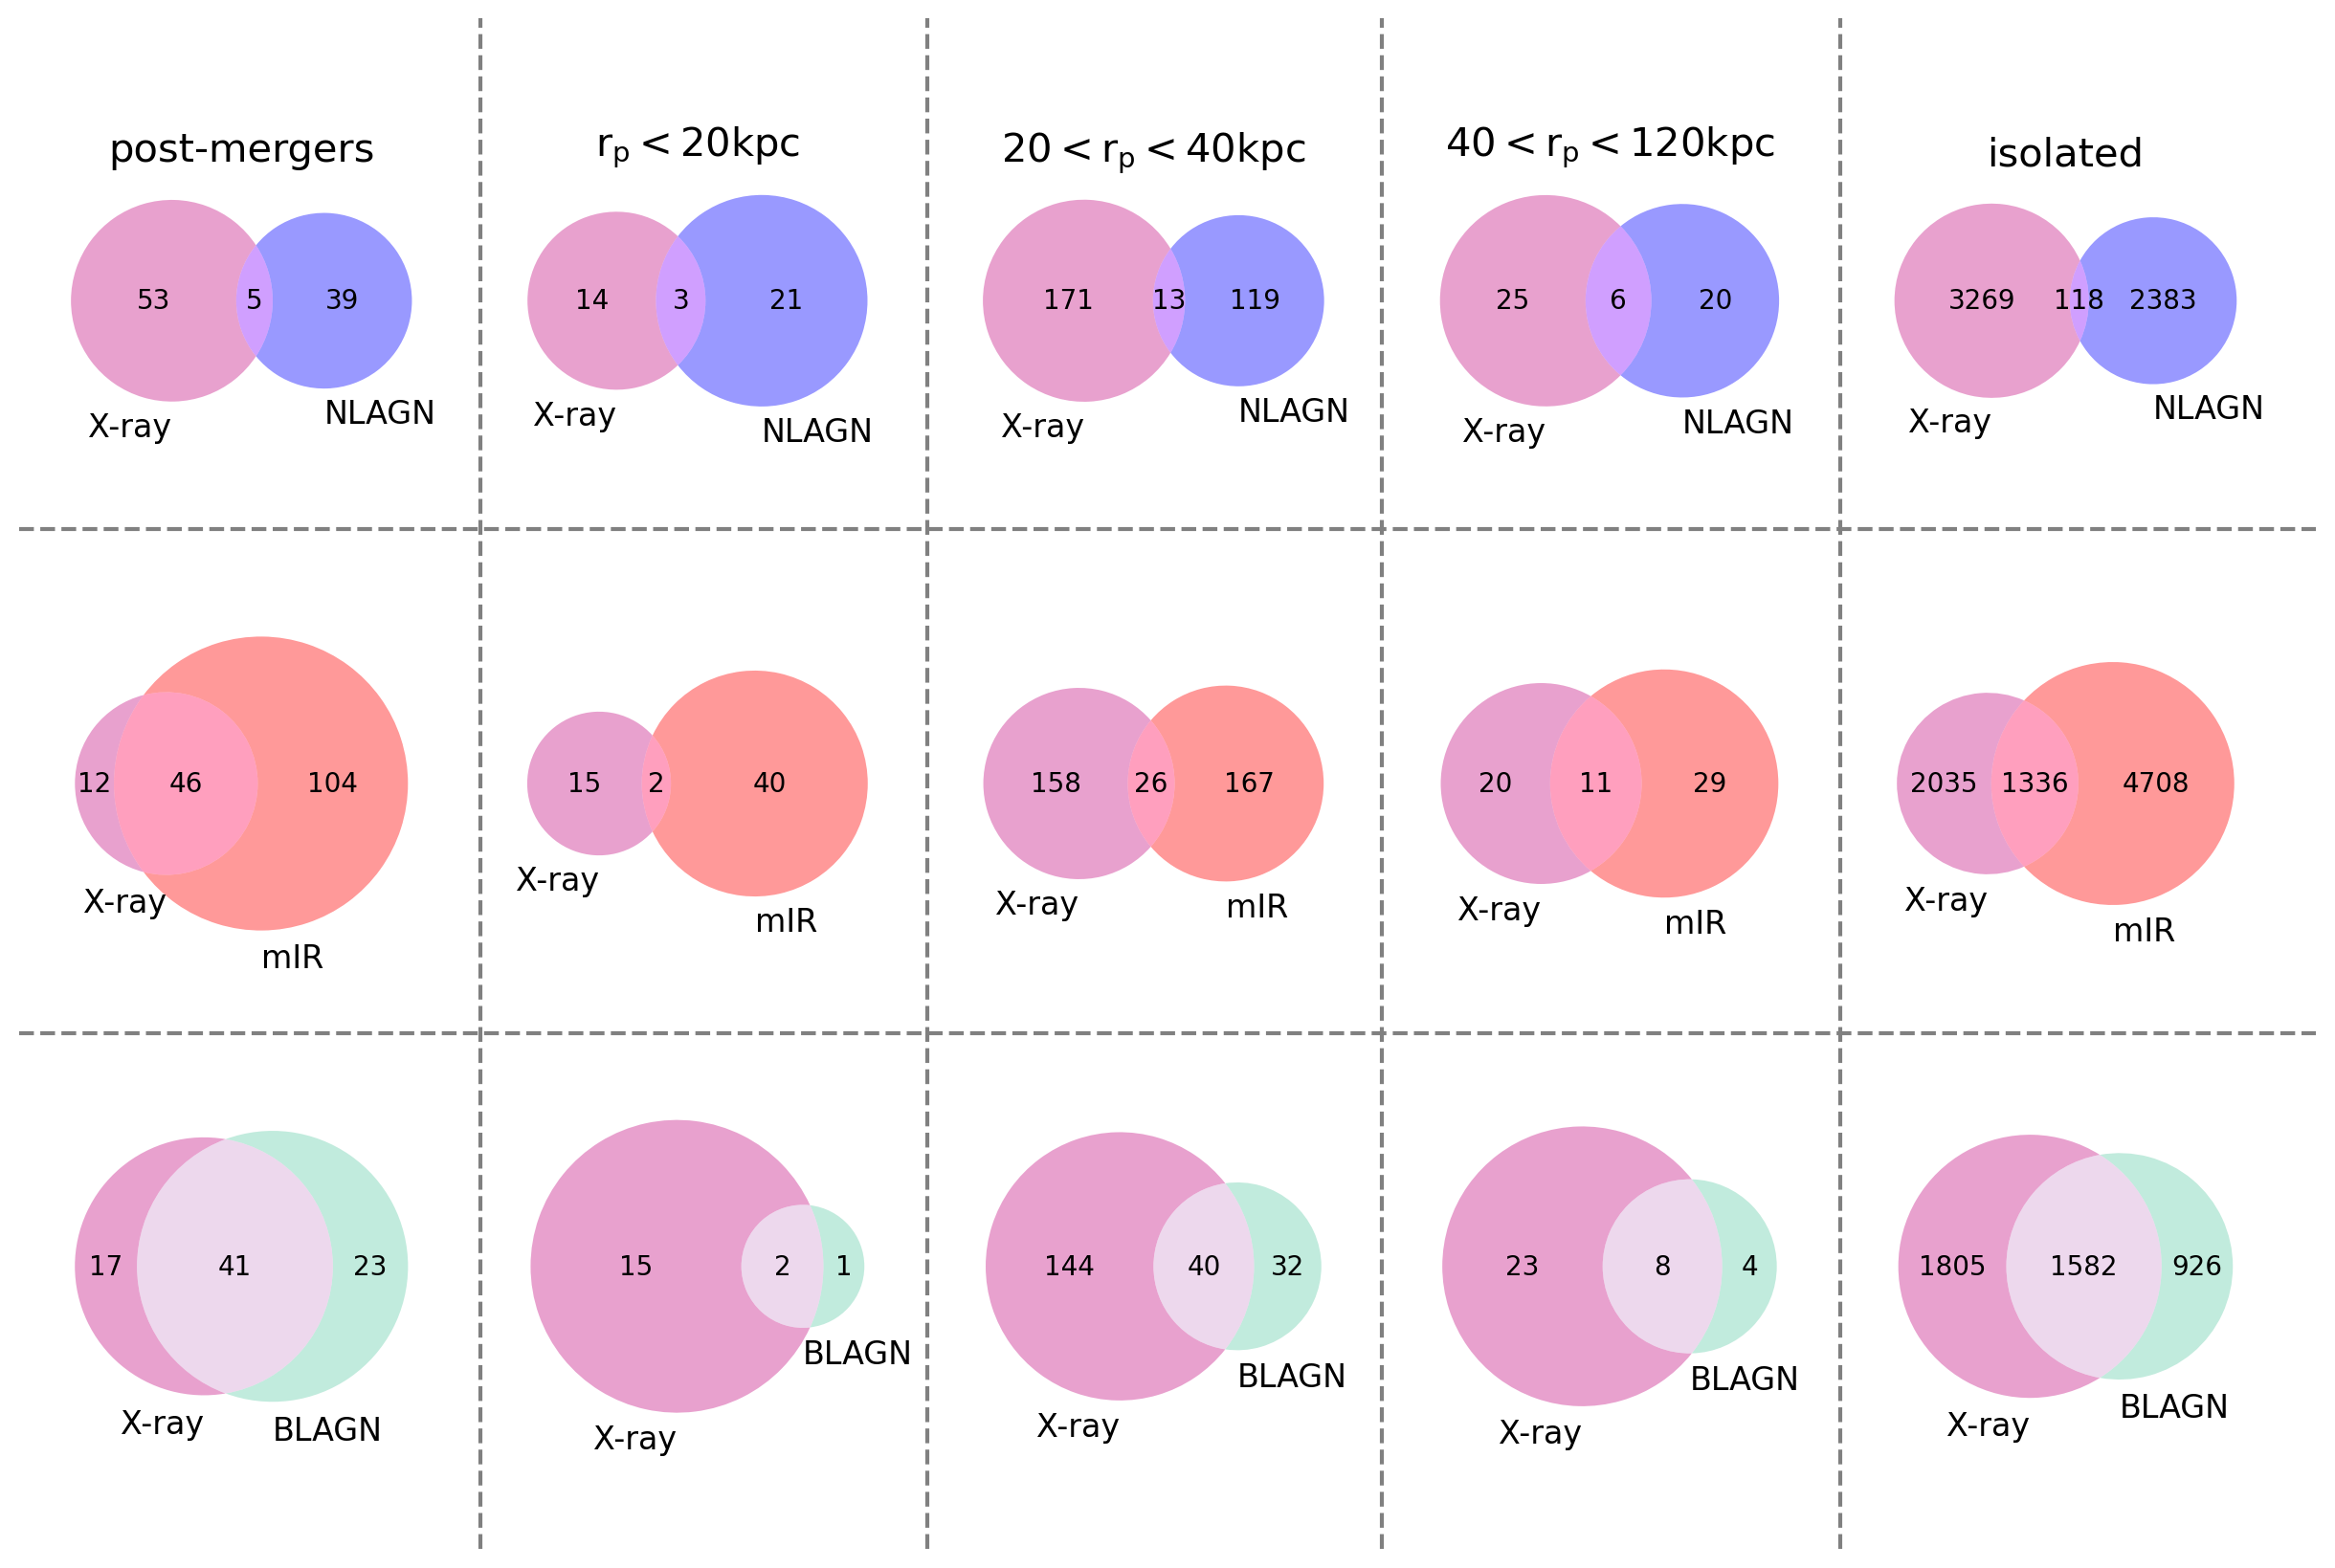

In [87]:
#!pip install matplotlib-venn
from matplotlib_venn import venn2,venn2_circles
fig,axs = plt.subplots(3,5,figsize=[12,8],dpi=200)
#(Abc, aBc, ABc, abC, AbC, aBC, ABC)
close_pair_mask = (df['rp']<20)&(df['logmass']>8)&(df['z_spec']>0.005)&(df['PM']!=1)
far_pair_mask = (df['rp']>=20)&(df['rp']<40)&(df['logmass']>8)&(df['z_spec']>0.005)&(df['PM']!=1)
int_pair_mask = (df['rp']>=40)&(df['rp']<120)&(df['logmass']>8)&(df['z_spec']>0.005)&(df['PM']!=1)
iso_mask = (df['pair_ctrl_120']==1)&(df['logmass']>8)&(df['z_spec']>0.005)
#pms
Ab = len(df[(df['L_X_e']>0)&(df['PM']==1)&(df['logmass']>6)&(df['z_spec']>0.005)&~(bpt_agn_mask)])
AB = len(df[(bpt_agn_mask)&(df['L_X_e']>0)&(df['PM']==1)&(df['logmass']>6)&(df['z_spec']>0.005)])
aB = len(df[(bpt_agn_mask)&(df['PM']==1)&np.isnan(df['L_X_e'])&(df['logmass']>6)&(df['z_spec']>0.005)])

c = venn2([Ab,aB,AB],ax=axs.flatten()[0],set_labels=('X-ray','NLAGN'),set_colors=['mediumvioletred','blue'])

Ab = len(df[(df['L_X_e']>0)&(df['PM']==1)&(df['W1']-df['W2']<=0.5)])
AB = len(df[(df['W1']-df['W2']>0.5)&(df['L_X_e']>0)&(df['PM']==1)])
aB = len(df[(df['W1']-df['W2']>0.5)&(df['PM']==1)&np.isnan(df['L_X_e'])])

venn2([Ab,aB,AB],ax=axs.flatten()[5],set_labels = ('X-ray','mIR'),set_colors=['mediumvioletred','red'])

Ab = len(df[(df['L_X_e']>0)&(df['PM']==1)&np.isnan(df['BLR'])])
AB = len(df[(df['BLR']==1)&(df['L_X_e']>0)&(df['PM']==1)])
aB = len(df[(df['BLR']==1)&(df['PM']==1)&np.isnan(df['L_X_e'])])

venn2([Ab,aB,AB],ax=axs.flatten()[10],set_labels = ('X-ray','BLAGN'),set_colors=['mediumvioletred','mediumaquamarine'])
#close pairs
Ab = len(df[(df['L_X_e']>0)&(close_pair_mask)&~(bpt_agn_mask)])
AB = len(df[(bpt_agn_mask)&(df['L_X_e']>0)&(close_pair_mask)])
aB = len(df[(bpt_agn_mask)&(close_pair_mask)&np.isnan(df['L_X_e'])])

c = venn2([Ab,aB,AB],ax=axs.flatten()[1],set_labels=('X-ray','NLAGN'),set_colors=['mediumvioletred','blue'])

Ab = len(df[(df['L_X_e']>0)&(close_pair_mask)&(df['W1']-df['W2']<=0.5)])
AB = len(df[(df['W1']-df['W2']>0.5)&(df['L_X_e']>0)&(close_pair_mask)])
aB = len(df[(df['W1']-df['W2']>0.5)&(close_pair_mask)&np.isnan(df['L_X_e'])])

venn2([Ab,aB,AB],ax=axs.flatten()[6],set_labels = ('X-ray','mIR'),set_colors=['mediumvioletred','red'])

Ab = len(df[(df['L_X_e']>0)&(close_pair_mask)&np.isnan(df['BLR'])])
AB = len(df[(df['BLR']==1)&(df['L_X_e']>0)&(close_pair_mask)])
aB = len(df[(df['BLR']==1)&(close_pair_mask)&np.isnan(df['L_X_e'])])

venn2([Ab,aB,AB],ax=axs.flatten()[11],set_labels = ('X-ray','BLAGN'),set_colors=['mediumvioletred','mediumaquamarine'])

#intermediate pairs
Ab = len(df[(df['L_X_e']>0)&(int_pair_mask)&~(bpt_agn_mask)])
AB = len(df[(bpt_agn_mask)&(df['L_X_e']>0)&(int_pair_mask)])
aB = len(df[(bpt_agn_mask)&(int_pair_mask)&np.isnan(df['L_X_e'])])

c = venn2([Ab,aB,AB],ax=axs.flatten()[2],set_labels=('X-ray','NLAGN'),set_colors=['mediumvioletred','blue'])

Ab = len(df[(df['L_X_e']>0)&(int_pair_mask)&(df['W1']-df['W2']<=0.5)])
AB = len(df[(df['W1']-df['W2']>0.5)&(df['L_X_e']>0)&(int_pair_mask)])
aB = len(df[(df['W1']-df['W2']>0.5)&(int_pair_mask)&np.isnan(df['L_X_e'])])

venn2([Ab,aB,AB],ax=axs.flatten()[7],set_labels = ('X-ray','mIR'),set_colors=['mediumvioletred','red'])

Ab = len(df[(df['L_X_e']>0)&(int_pair_mask)&np.isnan(df['BLR'])])
AB = len(df[(df['BLR']==1)&(df['L_X_e']>0)&(int_pair_mask)])
aB = len(df[(df['BLR']==1)&(int_pair_mask)&np.isnan(df['L_X_e'])])

venn2([Ab,aB,AB],ax=axs.flatten()[12],set_labels = ('X-ray','BLAGN'),set_colors=['mediumvioletred','mediumaquamarine'])

#far pairs
Ab = len(df[(df['L_X_e']>0)&(far_pair_mask)&~(bpt_agn_mask)])
AB = len(df[(bpt_agn_mask)&(df['L_X_e']>0)&(far_pair_mask)])
aB = len(df[(bpt_agn_mask)&(far_pair_mask)&np.isnan(df['L_X_e'])])

c = venn2([Ab,aB,AB],ax=axs.flatten()[3],set_labels=('X-ray','NLAGN'),set_colors=['mediumvioletred','blue'])

Ab = len(df[(df['L_X_e']>0)&(far_pair_mask)&(df['W1']-df['W2']<=0.5)])
AB = len(df[(df['W1']-df['W2']>0.5)&(df['L_X_e']>0)&(far_pair_mask)])
aB = len(df[(df['W1']-df['W2']>0.5)&(far_pair_mask)&np.isnan(df['L_X_e'])])

venn2([Ab,aB,AB],ax=axs.flatten()[8],set_labels = ('X-ray','mIR'),set_colors=['mediumvioletred','red'])

Ab = len(df[(df['L_X_e']>0)&(far_pair_mask)&np.isnan(df['BLR'])])
AB = len(df[(df['BLR']==1)&(df['L_X_e']>0)&(far_pair_mask)])
aB = len(df[(df['BLR']==1)&(far_pair_mask)&np.isnan(df['L_X_e'])])

venn2([Ab,aB,AB],ax=axs.flatten()[13],set_labels = ('X-ray','BLAGN'),set_colors=['mediumvioletred','mediumaquamarine'])

#isolated
Ab = len(df[(df['L_X_e']>0)&(iso_mask)&~(bpt_agn_mask)])
AB = len(df[(bpt_agn_mask)&(df['L_X_e']>0)&(iso_mask)])
aB = len(df[(bpt_agn_mask)&(iso_mask)&np.isnan(df['L_X_e'])])

c = venn2([Ab,aB,AB],ax=axs.flatten()[4],set_labels=('X-ray','NLAGN'),set_colors=['mediumvioletred','blue'])

Ab = len(df[(df['L_X_e']>0)&(iso_mask)&(df['W1']-df['W2']<=0.5)])
AB = len(df[(df['W1']-df['W2']>0.5)&(df['L_X_e']>0)&(iso_mask)])
aB = len(df[(df['W1']-df['W2']>0.5)&(iso_mask)&np.isnan(df['L_X_e'])])

venn2([Ab,aB,AB],ax=axs.flatten()[9],set_labels = ('X-ray','mIR'),set_colors=['mediumvioletred','red'])

Ab = len(df[(df['L_X_e']>0)&(iso_mask)&np.isnan(df['BLR'])])
AB = len(df[(df['BLR']==1)&(df['L_X_e']>0)&(iso_mask)])
aB = len(df[(df['BLR']==1)&(iso_mask)&np.isnan(df['L_X_e'])])

venn2([Ab,aB,AB],ax=axs.flatten()[14],set_labels = ('X-ray','BLAGN'),set_colors=['mediumvioletred','mediumaquamarine'])

axs.flatten()[0].set_ylabel('X-ray+BPT')
axs.flatten()[5].set_ylabel('X-ray+mIR')
axs.flatten()[10].set_ylabel('X-ray+BLR')
axs.flatten()[0].set_title('post-mergers',fontsize=15)
axs.flatten()[1].set_title('$\mathrm{r_{p}<20 kpc}$',fontsize=15)
axs.flatten()[2].set_title('$\mathrm{20<r_{p}<40 kpc}$',fontsize=15)
axs.flatten()[3].set_title('$\mathrm{40<r_{p}<120 kpc}$',fontsize=15)
axs.flatten()[4].set_title('isolated',fontsize=15)
# rearange the axes for no overlap
fig.tight_layout()

# Get the bounding boxes of the axes including text decorations
r = fig.canvas.get_renderer()
get_bbox = lambda ax: ax.get_tightbbox(r).transformed(fig.transFigure.inverted())
bboxes = np.array(list(map(get_bbox, axs.flat)), mtrans.Bbox).reshape(axs.shape)

#Get the minimum and maximum extent, get the coordinate half-way between those
ymax = np.array(list(map(lambda b: b.y1, bboxes.flat))).reshape(axs.shape).max(axis=1)
ymin = np.array(list(map(lambda b: b.y0, bboxes.flat))).reshape(axs.shape).min(axis=1)
ys = np.c_[ymax[1:], ymin[:-1]].mean(axis=1)

# Draw a horizontal lines at those coordinates
for y in ys:
    line = plt.Line2D([0,1],[y,y], transform=fig.transFigure, color="gray",linestyle='dashed')
    fig.add_artist(line)
    
#Get the minimum and maximum extent, get the coordinate half-way between those
xmax = np.array(list(map(lambda b: b.x1, bboxes.flat))).reshape(axs.shape).max(axis=0)
xmin = np.array(list(map(lambda b: b.x0, bboxes.flat))).reshape(axs.shape).min(axis=0)
xs = np.c_[xmax[1:], xmin[:-1]].mean(axis=1)

# Draw a horizontal lines at those coordinates
for x in xs:
    line = plt.Line2D([x,x],[0,1],transform=fig.transFigure, color="gray",linestyle='dashed')
    fig.add_artist(line)

plt.show()

0


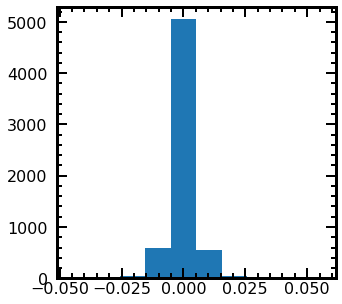

0.056402000000000285
-0.04607120000000009
6320
1


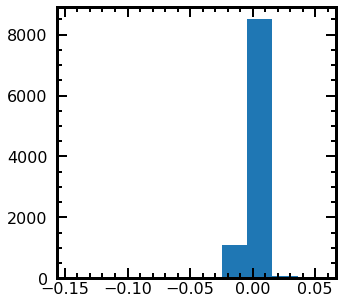

0.05627119999999941
-0.14645940000000035
9700
2


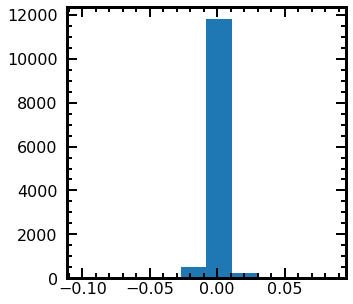

0.08591200000000043
-0.10201299999999947
12580
3


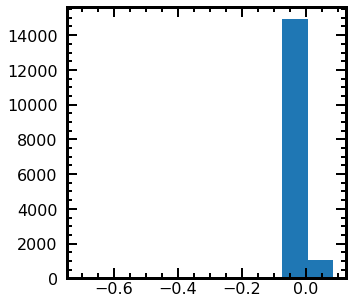

0.08591200000000043
-0.7084579999999994
15980
4


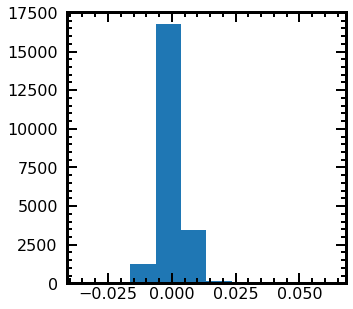

0.06322600000000023
-0.036169499999999744
21780
5


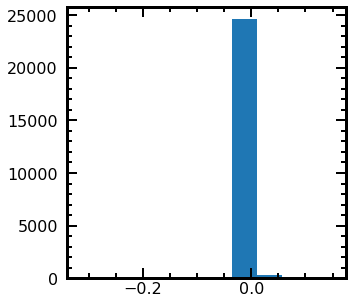

0.15115699999999954
-0.3168072999999998
24940


In [41]:
deltas_master = []
for r in range(6):
    print(r)
    deltas = []
    tar_samp = pd.read_csv('./nov6_match_track/tar_samp_strict_120_{}.csv'.format(str(r)))['logmass']
    ctrl_samp = pd.read_csv('./nov6_match_track/ctrl_samp_strict_120_{}.csv'.format(str(r)))['logmass']
    companion_samp = pd.read_csv('./nov6_match_track/companion_samp_strict_120_{}.csv'.format(str(r)))['logmass']
    for batch in range(len(ctrl_samp)//(2*len(tar_samp))):
        for i in range(len(tar_samp)):
            row = tar_samp[i]
            companion = companion_samp[i]
            match = ctrl_samp[batch*len(tar_samp)*2+2*i]
            match2 = ctrl_samp[batch*len(tar_samp)*2+2*i+1]
            deltas.append(row-match)
            deltas.append(companion-match2)
            
            deltas_master.append(row-match)
            deltas_master.append(companion-match2)
            
    fig,axs = plt.subplots(figsize=[5,5])
    plt.hist(deltas)
    plt.show()
    print(np.amax(deltas))
    print(np.amin(deltas))
    print(len(deltas))

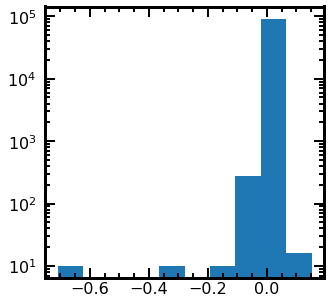

In [42]:
fig,axs = plt.subplots(figsize=[5,5])
plt.hist(deltas_master,log=True)
plt.show()

In [43]:
print(np.amin(deltas_master))
print(np.amax(deltas_master))

-0.7084579999999994
0.15115699999999954


In [51]:
del_abs = np.abs(deltas_master)
print(len(del_abs[del_abs<0.02])/len(del_abs))

0.9928477546549835


0


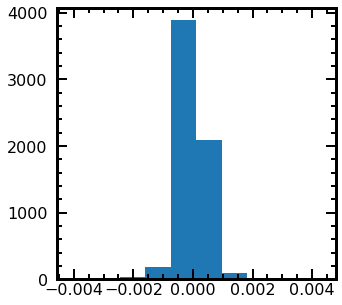

0.004366000000000009
-0.004145999999999983
6320
1


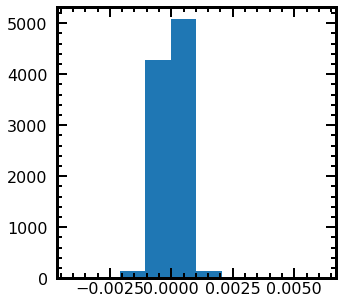

0.00617100000000001
-0.004145999999999983
9700
2


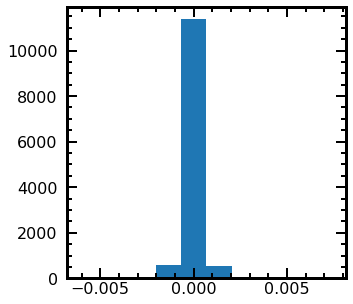

0.007467000000000001
-0.006108999999999996
12580
3


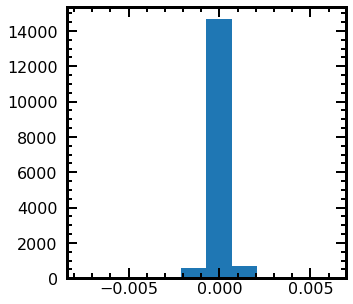

0.006253999999999999
-0.0076990000000000045
15980
4


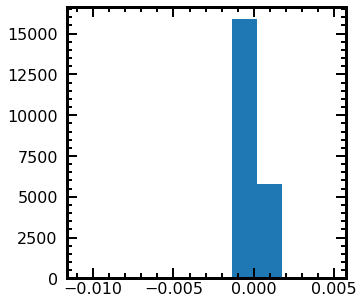

0.0049499999999999995
-0.010853999999999999
21780
5


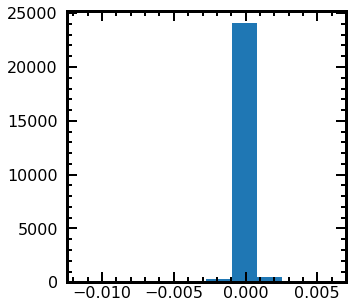

0.0061119999999999924
-0.011579000000000006
24940


In [52]:
deltas_master = []
for r in range(6):
    print(r)
    deltas = []
    tar_samp = pd.read_csv('./nov6_match_track/tar_samp_strict_120_{}.csv'.format(str(r)))['z_spec']
    ctrl_samp = pd.read_csv('./nov6_match_track/ctrl_samp_strict_120_{}.csv'.format(str(r)))['z_spec']
    companion_samp = pd.read_csv('./nov6_match_track/companion_samp_strict_120_{}.csv'.format(str(r)))['z_spec']
    for batch in range(len(ctrl_samp)//(2*len(tar_samp))):
        for i in range(len(tar_samp)):
            row = tar_samp[i]
            companion = companion_samp[i]
            match = ctrl_samp[batch*len(tar_samp)*2+2*i]
            match2 = ctrl_samp[batch*len(tar_samp)*2+2*i+1]
            deltas.append(row-match)
            deltas.append(companion-match2)
            
            deltas_master.append(row-match)
            deltas_master.append(companion-match2)
            
    fig,axs = plt.subplots(figsize=[5,5])
    plt.hist(deltas)
    plt.show()
    print(np.amax(deltas))
    print(np.amin(deltas))
    print(len(deltas))

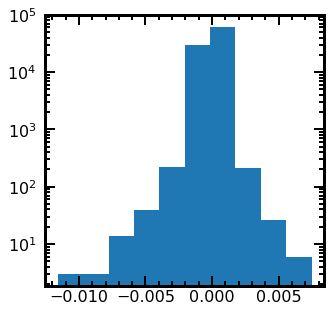

In [53]:
fig,axs = plt.subplots(figsize=[5,5])
plt.hist(deltas_master,log=True)
plt.show()

In [59]:
print(np.amin(deltas_master))
print(np.amax(deltas_master))

-0.011579000000000006
0.007467000000000001


In [58]:
del_abs = np.abs(deltas_master)
print(len(del_abs[del_abs<0.002])/len(del_abs))

0.9950273822562979


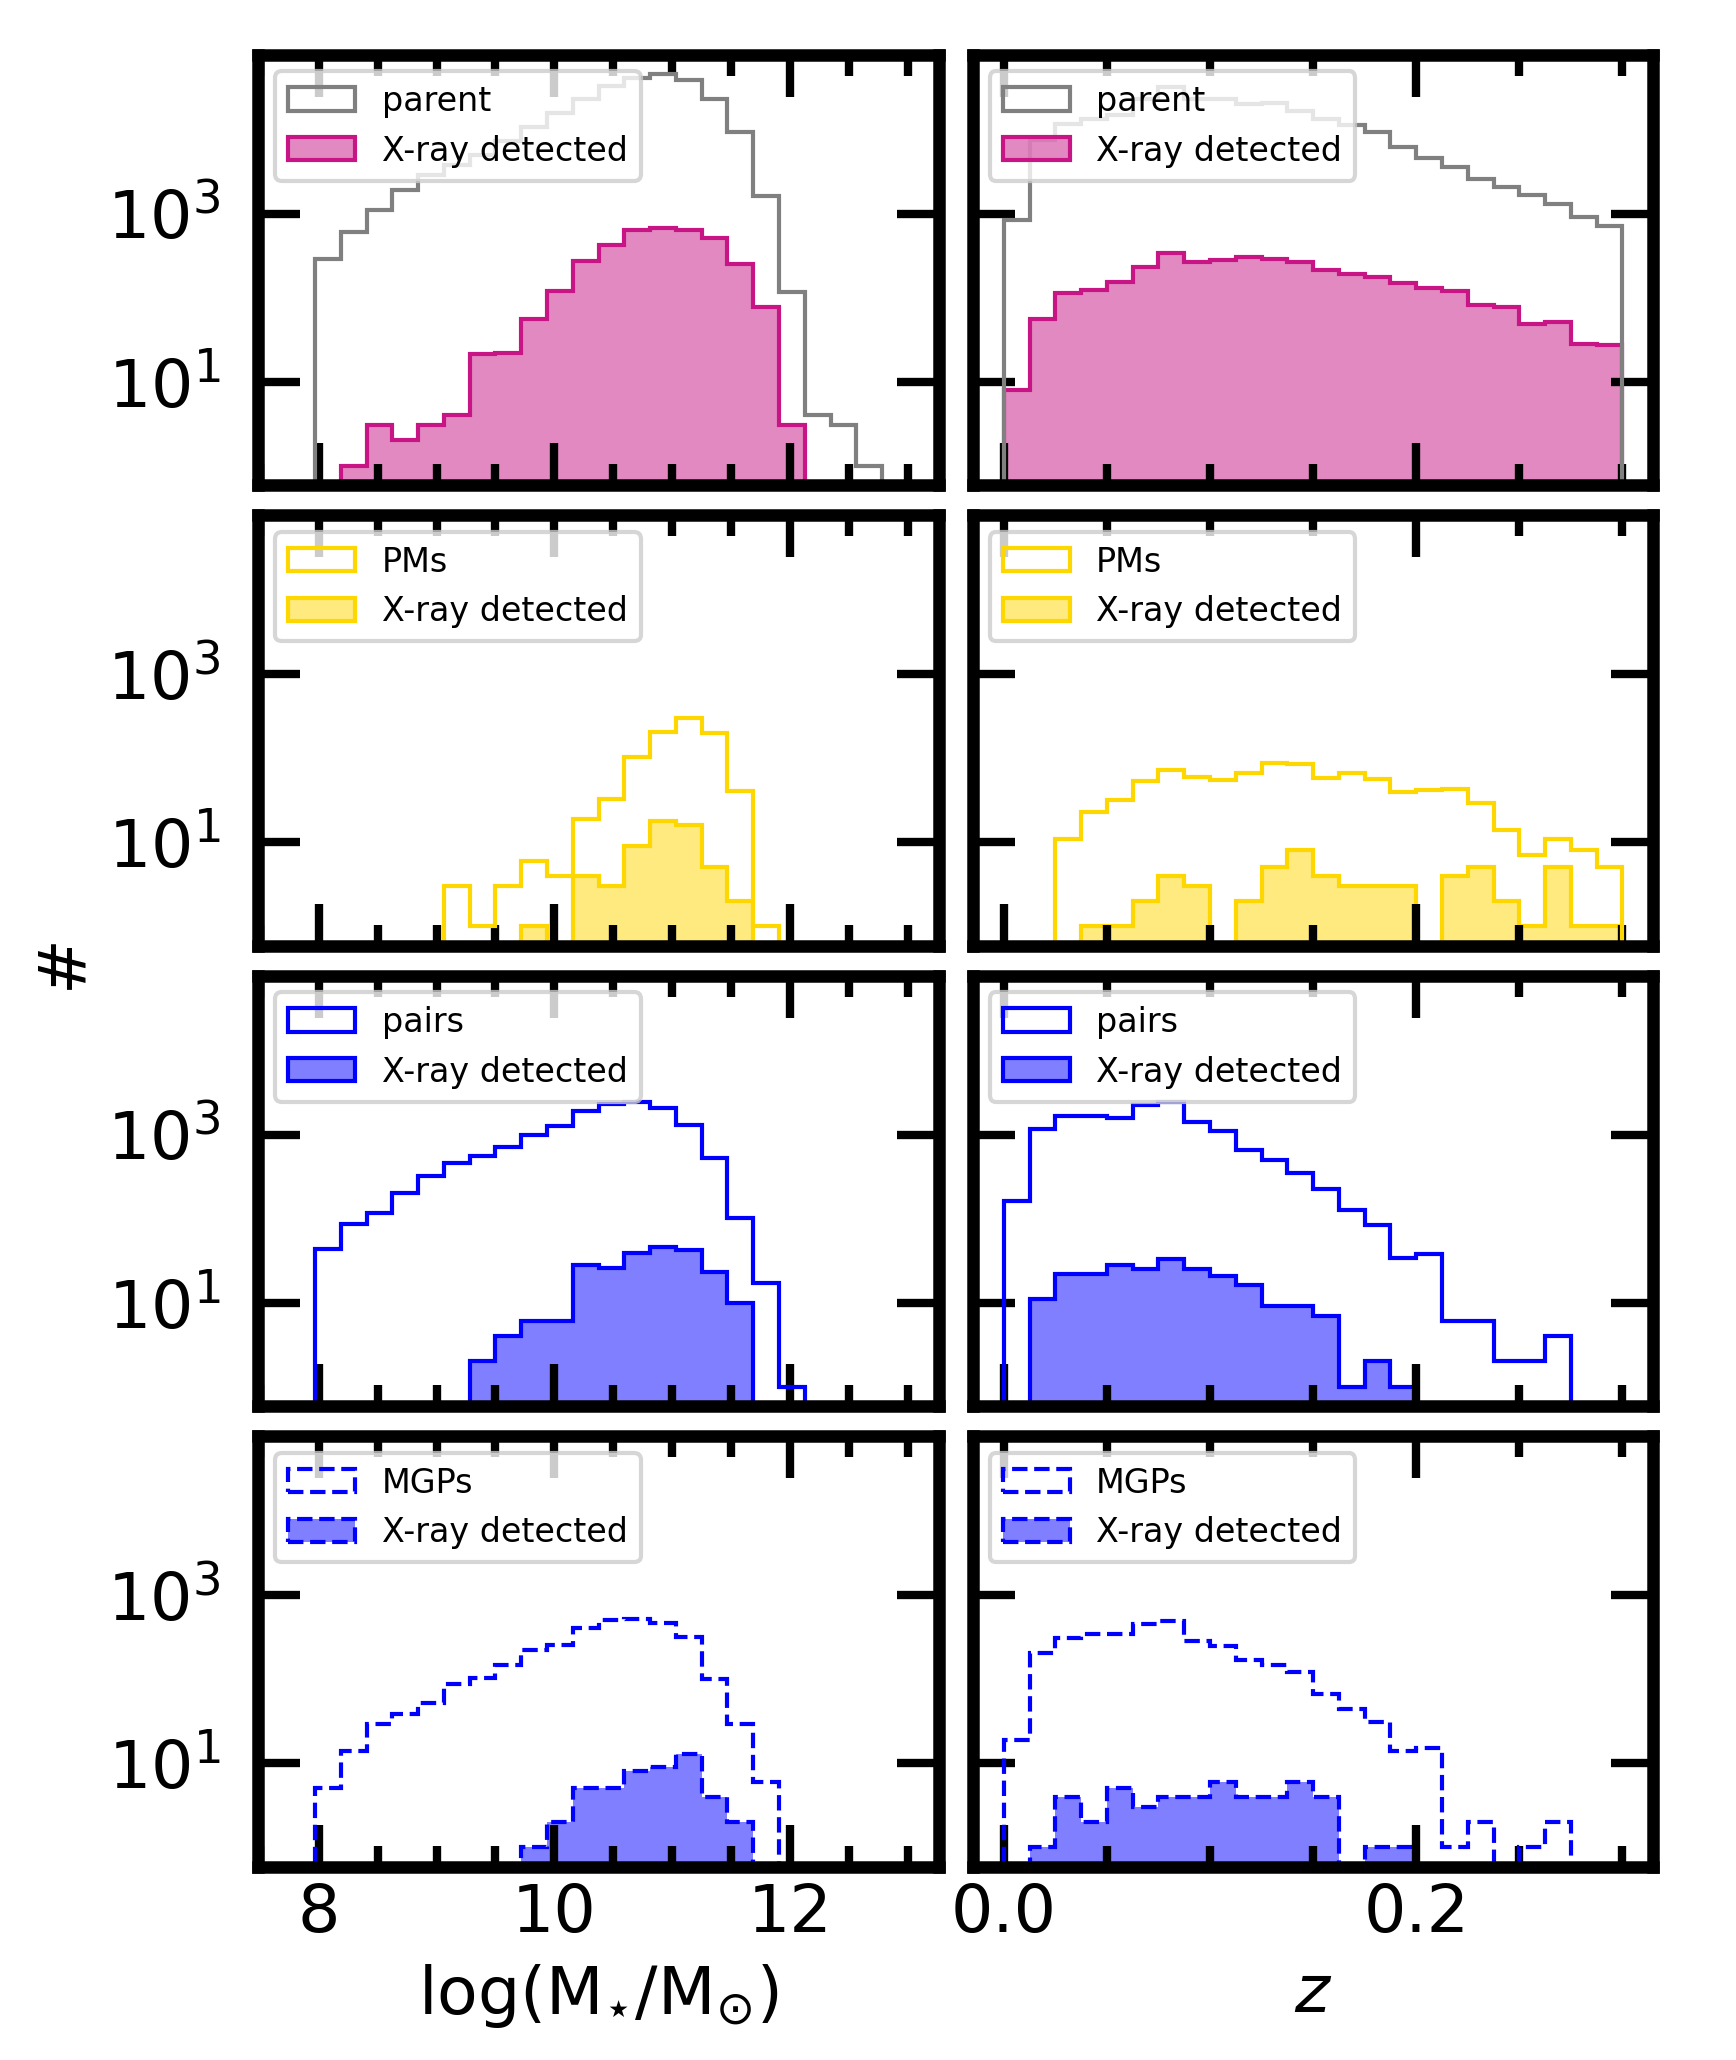

In [79]:
mgp_df = pd.concat([pd.read_csv('./nov6_match_track/tar_samp_strict_120_{}.csv'.format(str(r))) for r in range(5)])
fig,axs = plt.subplots(4,2,figsize=[6,8],dpi=300,sharex='col',sharey='all')
axs[0,0].hist(df['logmass'][(df['z_spec']>0.005)&(df['logmass']>8)],histtype='step',color='gray',log=True,bins=np.linspace(7.75,13,25),label='parent')
axs[0,0].hist(df['logmass'][(df['L_X_e']>0)&(df['z_spec']>0.005)&(df['logmass']>8)],histtype='stepfilled',log=True,bins=np.linspace(7.75,13,25),label='X-ray detected',fc=(199/256,21/256,133/256,0.5),edgecolor='mediumvioletred')

axs[1,0].hist(df['logmass'][(df['PM']==1)&(df['z_spec']>0.005)&(df['logmass']>8)],histtype='step',color='gold',log=True,bins=np.linspace(7.75,13,25),label='PMs')
axs[1,0].hist(df['logmass'][(df['PM']==1)&(df['L_X_e']>0)&(df['z_spec']>0.005)&(df['logmass']>8)],histtype='stepfilled',color='gold',log=True,bins=np.linspace(7.75,13,25),fc=(255/256,215/256,0,0.5),edgecolor='gold',label='X-ray detected')

axs[2,0].hist(df['logmass'][(df['rp']<120)&(df['PM']!=1)&(df['z_spec']>0.005)&(df['logmass']>8)],histtype='step',color='blue',log=True,bins=np.linspace(7.75,13,25),label='pairs')
axs[2,0].hist(df['logmass'][(df['rp']<120)&(df['PM']!=1)&(df['z_spec']>0.005)&(df['logmass']>8)&(df['L_X_e']>0)],histtype='stepfilled',color='blue',log=True,bins=np.linspace(7.75,13,25),fc=(0,0,1,0.5),edgecolor='blue',label='X-ray detected')

axs[3,0].hist(mgp_df['logmass'][(mgp_df['rp']<120)&(mgp_df['PM']!=1)&(mgp_df['z_spec']>0.005)&(mgp_df['logmass']>8)],histtype='step',color='blue',linestyle='dashed',log=True,bins=np.linspace(7.75,13,25),label='MGPs')
axs[3,0].hist(mgp_df['logmass'][(mgp_df['rp']<120)&(mgp_df['PM']!=1)&(mgp_df['z_spec']>0.005)&(mgp_df['logmass']>8)&(mgp_df['L_X_e']>0)],histtype='stepfilled',linestyle='dashed',color='blue',log=True,bins=np.linspace(7.75,13,25),fc=(0,0,1,0.5),edgecolor='blue',label='X-ray detected')

axs[3,0].set_xlabel('log(M$\mathrm{_{\star}}$/M$\mathrm{_{\odot}}$)')
axs[0,0].legend(loc='upper left',fontsize=8)
axs[1,0].legend(loc='upper left',fontsize=8)
axs[2,0].legend(loc='upper left',fontsize=8)
axs[3,0].legend(loc='upper left',fontsize=8)

axs[0,1].hist(df['z_spec'][(df['z_spec']>0.005)&(df['logmass']>8)],histtype='step',color='gray',log=True,bins=np.linspace(0,0.3,25),label='parent')
axs[0,1].hist(df['z_spec'][(df['L_X_e']>0)&(df['z_spec']>0.005)&(df['logmass']>8)],histtype='stepfilled',log=True,bins=np.linspace(0,0.3,25),label='X-ray detected',fc=(199/256,21/256,133/256,0.5),edgecolor='mediumvioletred')
axs[1,1].hist(df['z_spec'][(df['PM']==1)&(df['z_spec']>0.005)&(df['logmass']>8)],histtype='step',color='gold',log=True,bins=np.linspace(0,0.3,25),label='PMs')
axs[1,1].hist(df['z_spec'][(df['PM']==1)&(df['L_X_e']>0)&(df['z_spec']>0.005)&(df['logmass']>8)],histtype='stepfilled',color='gold',log=True,bins=np.linspace(0,0.3,25),fc=(255/256,215/256,0,0.5),edgecolor='gold',label='X-ray detected')
axs[2,1].hist(df['z_spec'][(df['rp']<120)&(df['PM']!=1)&(df['z_spec']>0.005)&(df['logmass']>8)],histtype='step',color='blue',log=True,bins=np.linspace(0,0.3,25),label='pairs')
axs[2,1].hist(df['z_spec'][(df['rp']<120)&(df['PM']!=1)&(df['L_X_e']>0)&(df['z_spec']>0.005)&(df['logmass']>8)],histtype='stepfilled',color='blue',log=True,bins=np.linspace(0,0.3,25),fc=(0,0,1,0.5),edgecolor='blue',label='X-ray detected')
axs[3,1].hist(mgp_df['z_spec'][(mgp_df['rp']<120)&(mgp_df['PM']!=1)&(mgp_df['z_spec']>0.005)&(mgp_df['logmass']>8)],histtype='step',color='blue',log=True,bins=np.linspace(0,0.3,25),label='MGPs',linestyle='dashed')
axs[3,1].hist(mgp_df['z_spec'][(mgp_df['rp']<120)&(mgp_df['PM']!=1)&(mgp_df['z_spec']>0.005)&(mgp_df['L_X_e']>0)&(mgp_df['logmass']>8)],histtype='stepfilled',linestyle='dashed',color='blue',log=True,bins=np.linspace(0,0.3,25),fc=(0,0,1,0.5),edgecolor='blue',label='X-ray detected')
axs[3,1].set_xlabel('$z$')

axs[0,1].legend(loc='upper left',fontsize=8)
axs[1,1].legend(loc='upper left',fontsize=8)
axs[2,1].legend(loc='upper left',fontsize=8)
axs[3,1].legend(loc='upper left',fontsize=8)

plt.subplots_adjust(wspace=0.05,hspace=0.07)

fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.ylabel('#',labelpad=5)

plt.show()

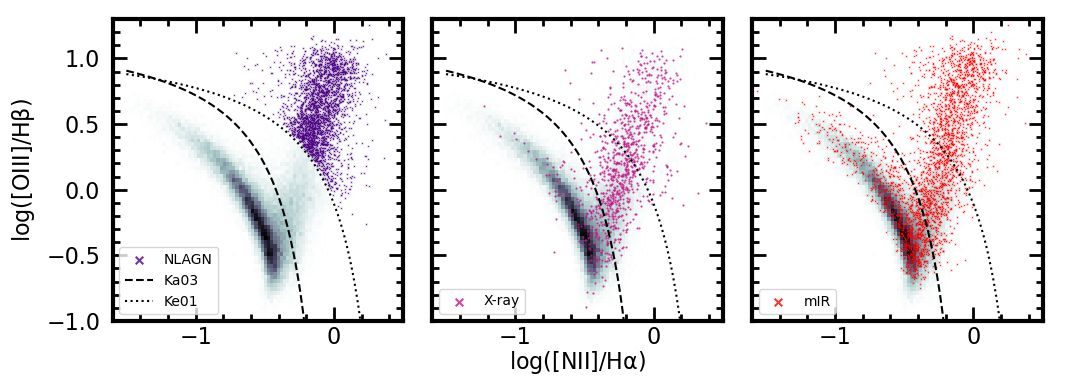

In [81]:
#bpt positions for the agn types
fig,axs = plt.subplots(1,3,figsize=[12,4],dpi=100,sharex=True,sharey=True)
mask = (df['NII_flux']>0)&(df['Halpha_flux']>0)&(df['OIII_5007_flux']>0)&(df['Hbeta_flux']>0)&(df['agn_sn']>5)&(df['z_spec']>0.005)&(df['logmass']>8)
axs.flatten()[0].hist2d(np.log10(df['NII_flux'][mask]/df['Halpha_flux'][mask]),np.log10(df['OIII_5007_flux'][mask]/df['Hbeta_flux'][mask]),bins=[100,75],cmap='bone_r')
axs.flatten()[1].hist2d(np.log10(df['NII_flux'][mask]/df['Halpha_flux'][mask]),np.log10(df['OIII_5007_flux'][mask]/df['Hbeta_flux'][mask]),bins=[100,75],cmap='bone_r')
axs.flatten()[2].hist2d(np.log10(df['NII_flux'][mask]/df['Halpha_flux'][mask]),np.log10(df['OIII_5007_flux'][mask]/df['Hbeta_flux'][mask]),bins=[100,75],cmap='bone_r')


axs.flatten()[0].scatter(np.log10(df['NII_flux'][mask&bpt_agn_mask]/df['Halpha_flux'][mask&bpt_agn_mask]),np.log10(df['OIII_5007_flux'][mask&bpt_agn_mask]/df['Hbeta_flux'][mask&bpt_agn_mask]),color='indigo',s=0.1,marker='x',alpha=0.8,label='NLAGN')

axs.flatten()[1].scatter(np.log10(df['NII_flux'][(mask)&(df['L_X_e']>0)]/df['Halpha_flux'][(mask)&(df['L_X_e']>0)]),np.log10(df['OIII_5007_flux'][(mask)&(df['L_X_e']>0)]/df['Hbeta_flux'][(mask)&(df['L_X_e']>0)]),color='mediumvioletred',marker='x',s=0.3,label='X-ray',alpha=0.8)
lgnd = axs.flatten()[1].legend(loc='lower left',fontsize=10)
lgnd.legendHandles[0]._sizes = [30]

axs.flatten()[2].scatter(np.log10(df['NII_flux'][(mask)&(df['W1']-df['W2']>0.5)]/df['Halpha_flux'][(mask)&(df['W1']-df['W2']>0.5)]),np.log10(df['OIII_5007_flux'][(mask)&(df['W1']-df['W2']>0.5)]/df['Hbeta_flux'][(mask)&(df['W1']-df['W2']>0.5)]),color='red',marker='x',s=0.1,label='mIR',alpha=0.8)
#axs.flatten()[2].hist2d(np.log10(df['NII_flux'][(mask)&(df['W1']-df['W2']>0.5)]/df['Halpha_flux'][(mask)&(df['W1']-df['W2']>0.5)]),np.log10(df['OIII_5007_flux'][(mask)&(df['W1']-df['W2']>0.5)]/df['Hbeta_flux'][(mask)&(df['W1']-df['W2']>0.5)]),bins=[100,75],cmap='Reds')
lgnd = axs.flatten()[2].legend(loc='lower left',fontsize=10)
lgnd.legendHandles[0]._sizes = [30]

xsp = np.linspace(-1.5,0.25,200)
for ax in axs.flatten():
    ax.plot(xsp[xsp<0],np.array(0.61/(xsp-0.05)+1.3)[xsp<0],linestyle='dashed',label='Ka03',c='black')
    ax.plot(xsp,0.61/(xsp-0.47)+1.19,linestyle='dotted',label='Ke01',c='black')
    ax.set_ylim(-1,1.3)
    ax.set_xlim(-1.6,0.5)

lgnd = axs.flatten()[0].legend(loc='lower left',fontsize=10)
lgnd.legendHandles[0]._sizes = [30]

fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel(r'log([NII]/H$\mathrm{\alpha}$)',labelpad=0.1)
plt.ylabel(r'log([OIII]/H$\mathrm{\beta}$)',labelpad=20)
plt.subplots_adjust(wspace=0.1,hspace=0.1)
plt.show()

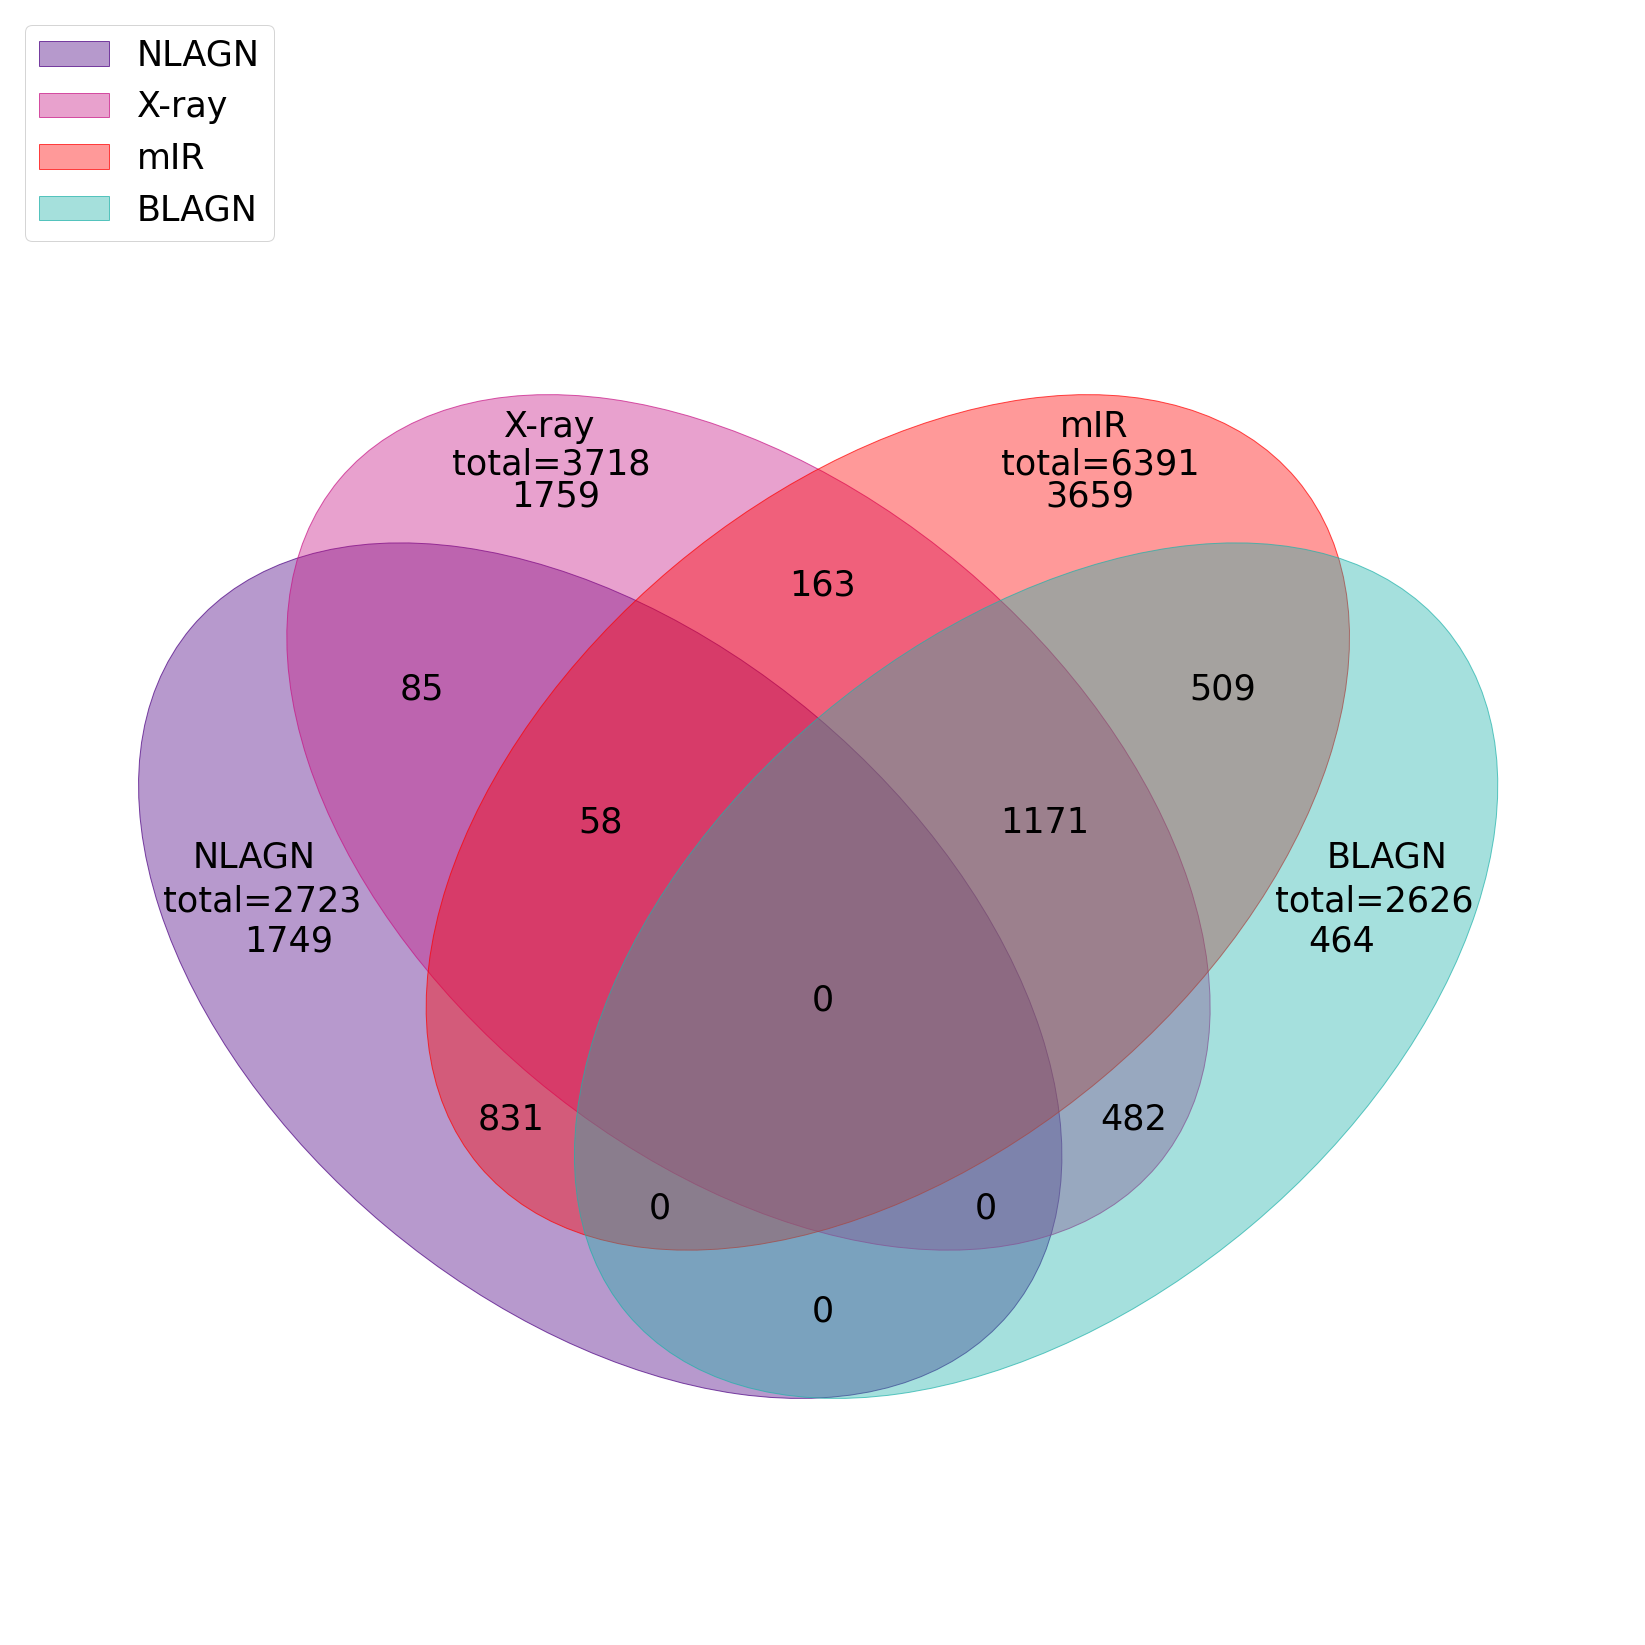

In [144]:
bpt_objIDs = set(df['objID'][(bpt_agn_mask)&(df['z_spec']>0.005)&(df['logmass']>8)].to_numpy().flatten())
ero_objIDs = set(df['objID'][(df['L_X_e']>0)&(df['z_spec']>0.005)&(df['logmass']>8)].to_numpy().flatten())
wi_objIDs = set(df['objID'][(df['W1']-df['W2']>0.5)&(df['z_spec']>0.005)&(df['logmass']>8)].to_numpy().flatten())
blr_objIDs = set(df['objID'][(df['BLR']==1)&(df['z_spec']>0.005)&(df['logmass']>8)].to_numpy().flatten())

venndata = {
    'NLAGN': bpt_objIDs,
    'X-ray': ero_objIDs,
    'mIR': wi_objIDs,
    'BLAGN': blr_objIDs
}
venn(venndata,figsize=[30,30],fontsize=35,cmap=['indigo','mediumvioletred','red','lightseagreen'],legend_loc='upper left')

plt.text(0.075,0.47,'NLAGN',fontsize=35)
plt.text(0.055,0.44,'total=2723',fontsize=35)

plt.text(0.84,0.47,'BLAGN',fontsize=35)
plt.text(0.805,0.44,'total=2626',fontsize=35)

plt.text(0.285,0.76,'X-ray',fontsize=35)
plt.text(0.25,0.735,'total=3718',fontsize=35)

plt.text(0.66,0.76,'mIR',fontsize=35)
plt.text(0.62,0.735,'total=6391',fontsize=35)

plt.show()

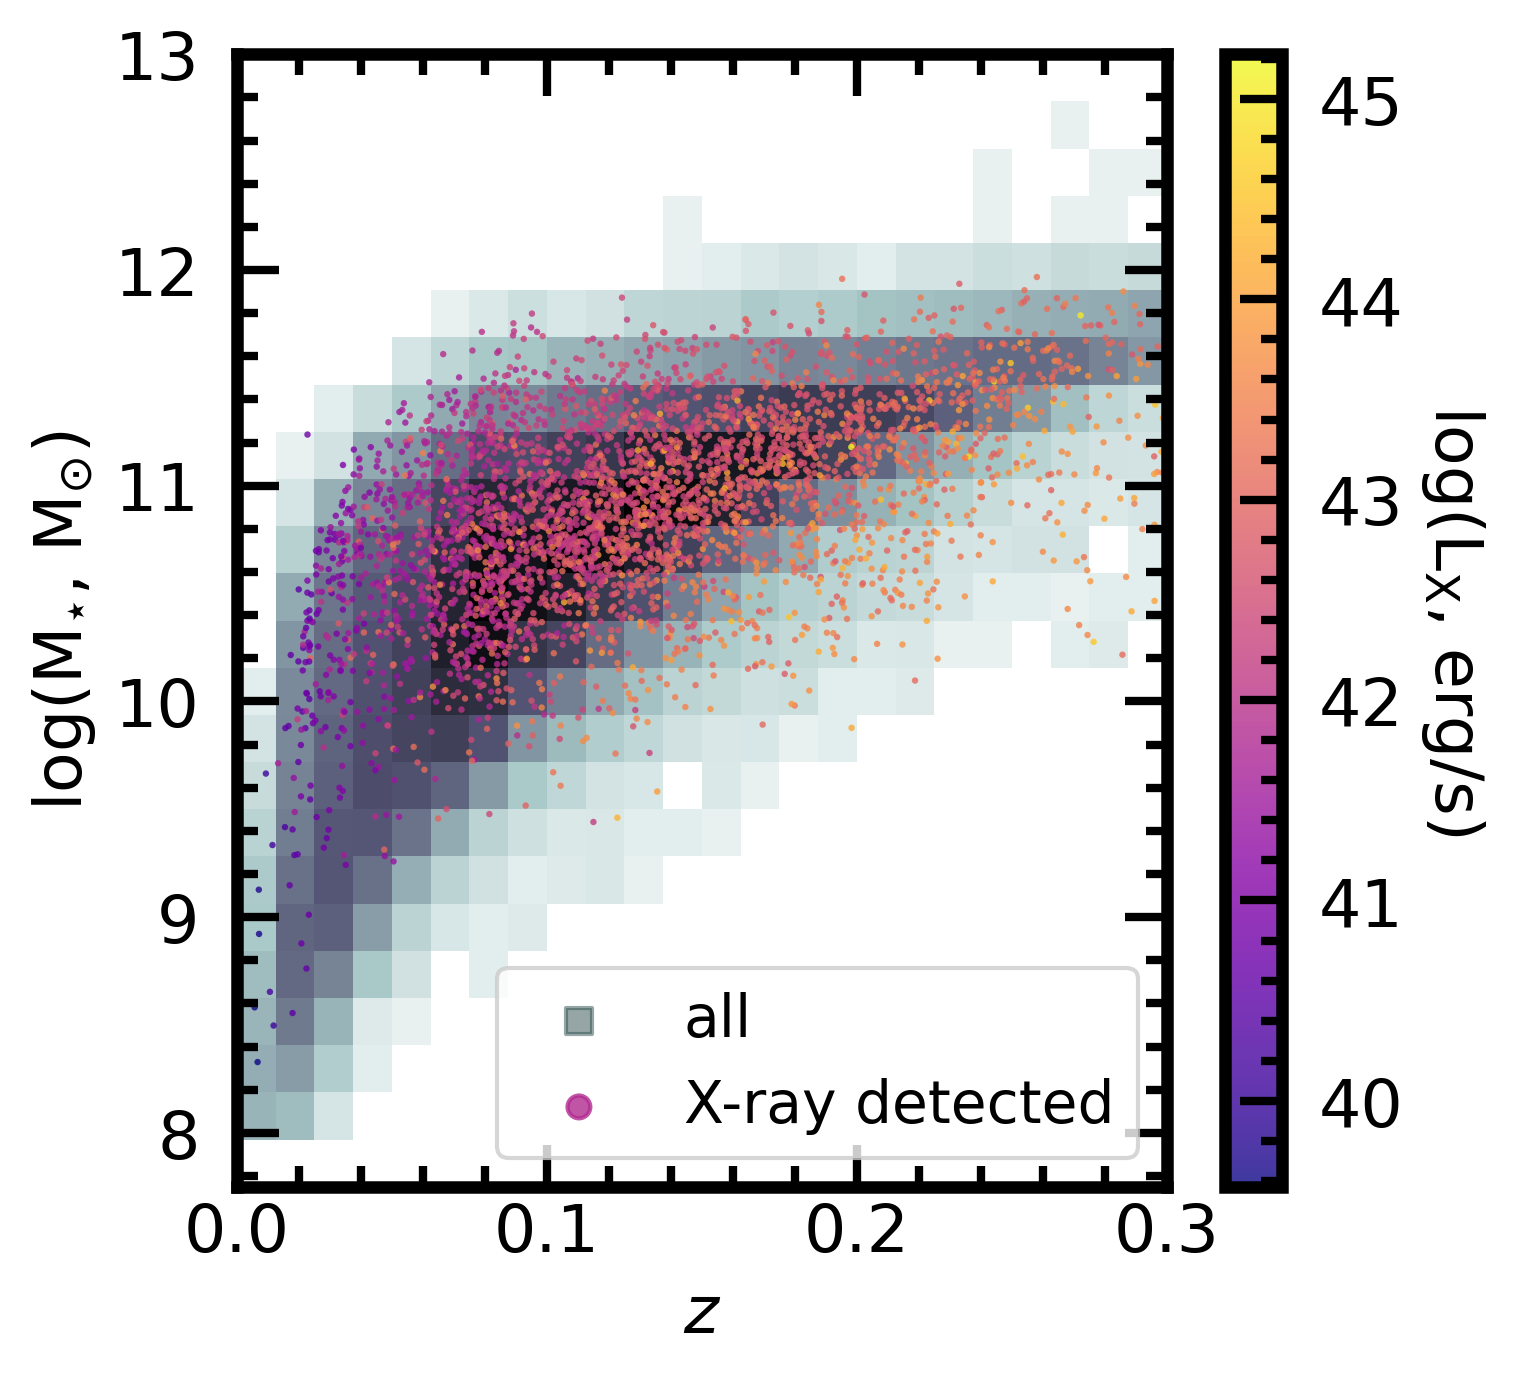

In [91]:
fig,axs = plt.subplots(figsize=[5,5],dpi=300)
plt.scatter(df.z_spec[(df.logmass>8)&(df.z_spec>0.005)],df.logmass[(df.logmass>8)&(df.z_spec>0.005)],color='darkslategray',marker='s',s=1,label='all',alpha=0.5)
plt.hist2d(df.z_spec[(df.logmass>8)&(df.z_spec>0.005)],df.logmass[(df.logmass>8)&(df.z_spec>0.005)],bins=[np.linspace(0,0.3,25),np.linspace(7.75,13,25)],cmap='bone_r',norm=mpl.colors.PowerNorm(0.3))
a = plt.scatter(df.z_spec[(df.logmass>8)&(df.z_spec>0.005)&(df['L_X_e']>0)],df.logmass[(df.logmass>8)&(df.z_spec>0.005)&(df['L_X_e']>0)],c=df.L_X_e[(df.logmass>8)&(df.z_spec>0.005)&(df['L_X_e']>0)],cmap='plasma',s=0.3,marker='o',alpha=0.8,label='X-ray detected')
cb = plt.colorbar(a)
cb.ax.get_yaxis().labelpad = 20
cb.ax.set_ylabel('log(L$\mathrm{_{X}}$, erg/s)',rotation=270)
lgd = plt.legend()
lgd.legendHandles[0]._sizes = [40]
lgd.legendHandles[1]._sizes = [30]
plt.xlabel('$z$')
plt.ylabel('log(M$\mathrm{_{\star}}$, $\mathrm{M_{\odot}}$)')
plt.show()

In [6]:
a = pd.read_csv('./samir_test_data/erass_gswlc-x_comb.dat',delimiter='\s+',header=None,index_col=None,names=['objID','desig','ra','decl','z_spec','FLAG','MJD','fiberID','Nsp'])
flag = a['FLAG']
ugriz_tab = Table(fits.getdata('./samir_test_data/results_ugriz.fits'))
FNugriz_tab = Table(fits.getdata('./samir_test_data/results_FNugriz.fits'))
griz_tab = Table(fits.getdata('./samir_test_data/results_griz.fits'))



In [152]:
ma = (flag==2)&~np.isnan(ugriz_tab['best.stellar.m_star'])&~np.isnan(FNugriz_tab['best.stellar.m_star'])&(FNugriz_tab['best.chi_square']>-3)
a = np.log10(FNugriz_tab['best.stellar.m_star'][ma])-np.log10(ugriz_tab['best.stellar.m_star'][ma])
print(np.mean(a))
print(np.amax(a))

0.012701567496835826
0.931062029244524


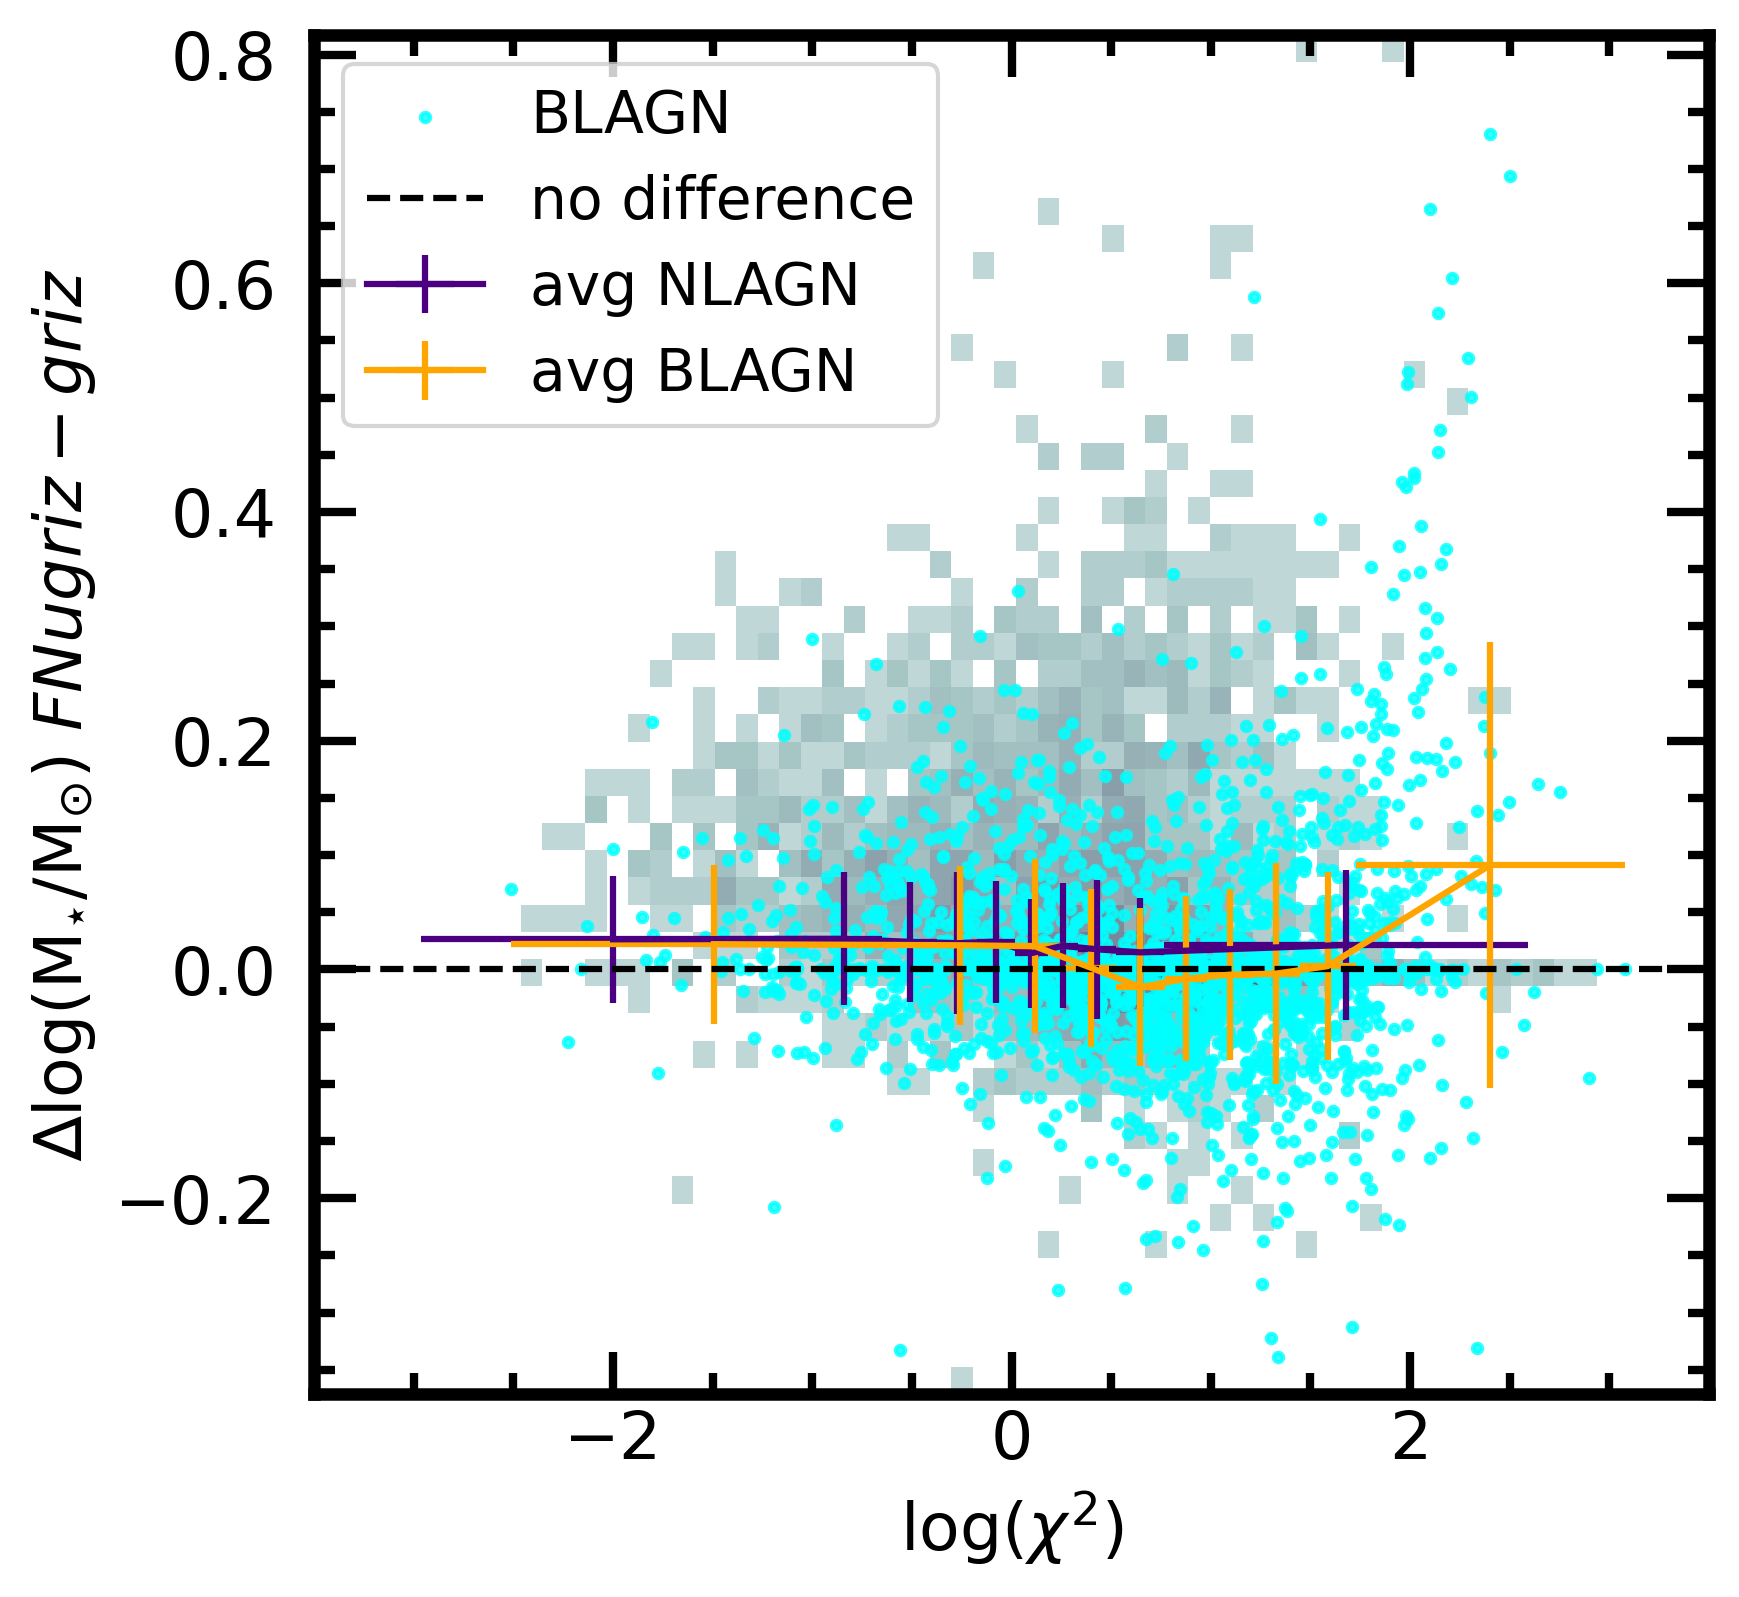

In [153]:
fig,axs = plt.subplots(figsize=[6,6],dpi=300)
ma = (flag==0)&~np.isnan(ugriz_tab['best.stellar.m_star'])&~np.isnan(FNugriz_tab['best.stellar.m_star'])&(FNugriz_tab['best.chi_square']>3)
plt.hist2d(np.log10(ugriz_tab['best.chi_square'][ma]),np.log10(FNugriz_tab['best.stellar.m_star'][ma])-np.log10(ugriz_tab['best.stellar.m_star'][ma]),cmap='bone_r',norm=mpl.colors.PowerNorm(0.3),bins=50)

ma = (flag==1)&~np.isnan(ugriz_tab['best.stellar.m_star'])&~np.isnan(FNugriz_tab['best.stellar.m_star'])&(FNugriz_tab['best.chi_square']>-3)
#plt.scatter(np.log10(ugriz_tab['best.chi_square'][ma]),np.log10(FNugriz_tab['best.stellar.m_star'][ma])-np.log10(ugriz_tab['best.stellar.m_star'][ma]),c='indigo',s=5,label='NLAGN',marker='x',linewidth=1,alpha=0.8)

xspace_plot,ymeds,xerrs,yerrs,xspace = binned_mean_ada(np.log10(ugriz_tab['best.chi_square'][ma]),np.log10(FNugriz_tab['best.stellar.m_star'][ma])-np.log10(ugriz_tab['best.stellar.m_star'][ma]),10)
plt.errorbar(xspace_plot,ymeds,xerr=xerrs,yerr=yerrs,color='indigo',label='avg NLAGN')

ma = (flag==2)&~np.isnan(ugriz_tab['best.stellar.m_star'])&~np.isnan(FNugriz_tab['best.stellar.m_star'])&(FNugriz_tab['best.chi_square']>-3)
plt.scatter(np.log10(ugriz_tab['best.chi_square'][ma]),np.log10(FNugriz_tab['best.stellar.m_star'][ma])-np.log10(ugriz_tab['best.stellar.m_star'][ma]),c='cyan',s=5,label='BLAGN',marker='o',alpha=0.8)

xspace_plot,ymeds,xerrs,yerrs,xspace = binned_mean_ada(np.log10(ugriz_tab['best.chi_square'][ma]),np.log10(FNugriz_tab['best.stellar.m_star'][ma])-np.log10(ugriz_tab['best.stellar.m_star'][ma]),10)
plt.errorbar(xspace_plot,ymeds,xerr=xerrs,yerr=yerrs,color='orange',label='avg BLAGN')
plt.hlines(0,-3.5,3.5,color='black',linestyle='dashed',label='no difference')
plt.xlim(-3.5,3.5)
plt.ylabel(r'∆log($\mathrm{M_{\star}}$/$\mathrm{M_{\odot}}$) $FNugriz-griz$')
plt.xlabel(r'log(${\chi}^{2}$)')
plt.legend()
plt.show()

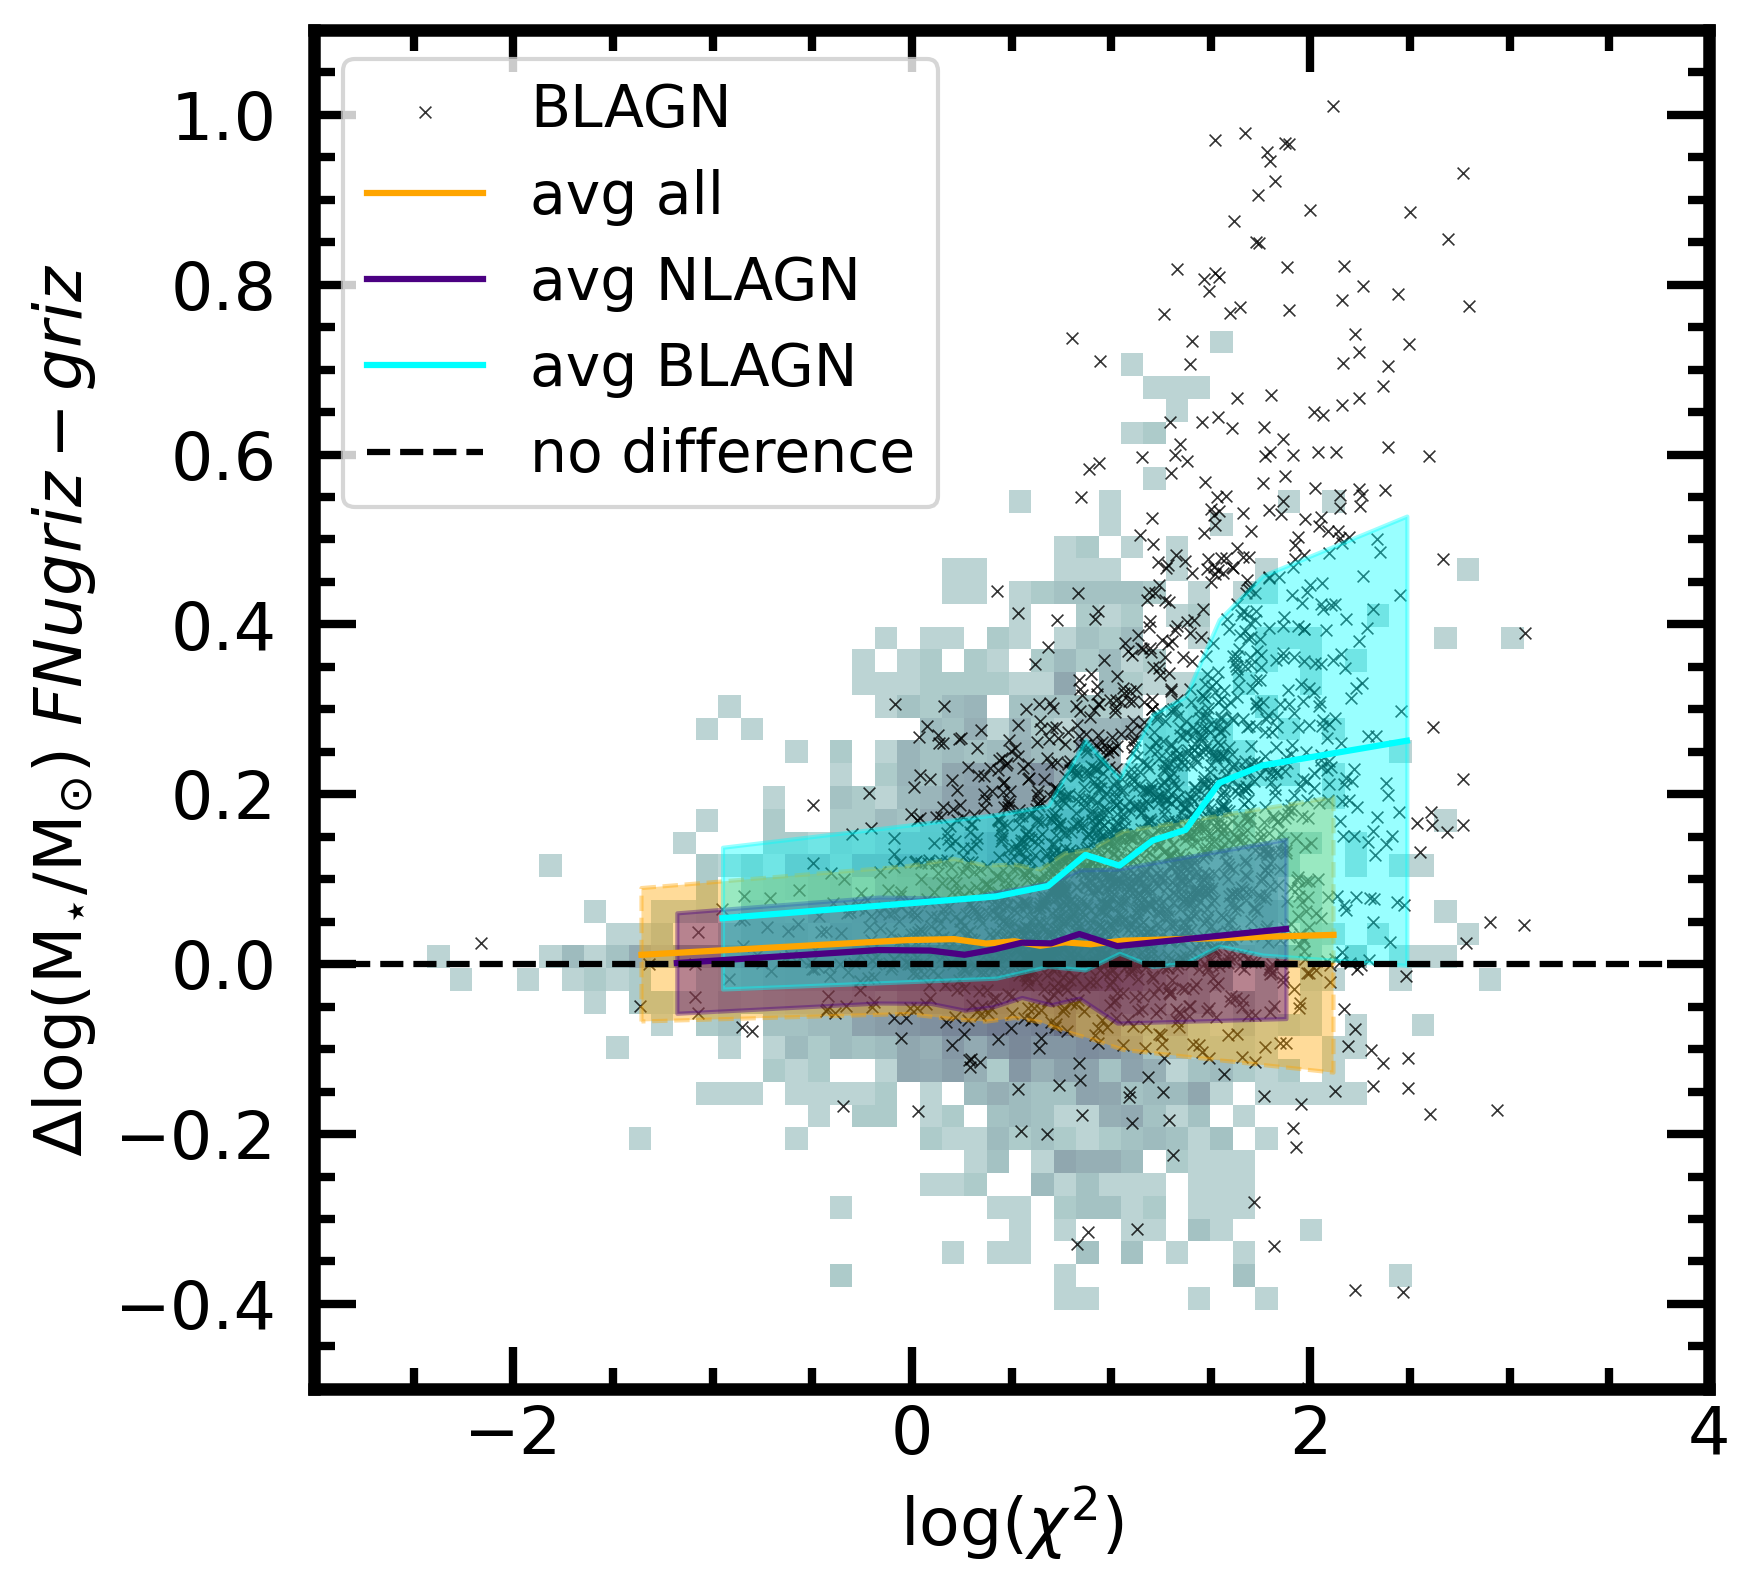

In [53]:
fig,axs = plt.subplots(figsize=[6,6],dpi=300)
ma = (flag==0)&~np.isnan(griz_tab['best.stellar.m_star'])&~np.isnan(FNugriz_tab['best.stellar.m_star'])#&(FNugriz_tab['best.chi_square']>3)
plt.hist2d(np.log10(FNugriz_tab['best.chi_square'][ma]),np.log10(FNugriz_tab['best.stellar.m_star'][ma])-np.log10(griz_tab['best.stellar.m_star'][ma]),cmap='bone_r',norm=mpl.colors.PowerNorm(0.3),bins=50)

ma = (flag==2)&~np.isnan(griz_tab['best.stellar.m_star'])&~np.isnan(FNugriz_tab['best.stellar.m_star'])#&(FNugriz_tab['best.chi_square']>-3)
plt.scatter(np.log10(FNugriz_tab['best.chi_square'][ma]),np.log10(FNugriz_tab['best.stellar.m_star'][ma])-np.log10(griz_tab['best.stellar.m_star'][ma]),c='black',s=8,label='BLAGN',marker='x',alpha=0.8,linewidth=0.4)

ma = (flag==0)&~np.isnan(griz_tab['best.stellar.m_star'])&~np.isnan(FNugriz_tab['best.stellar.m_star'])#&(FNugriz_tab['best.chi_square']>3)
xspace_plot,ymeds,xerrs,yerrs,xspace = binned_mean_ada(np.log10(FNugriz_tab['best.chi_square'][ma]),np.log10(FNugriz_tab['best.stellar.m_star'][ma])-np.log10(griz_tab['best.stellar.m_star'][ma]),10)
plt.plot(xspace_plot,ymeds,color='orange',label='avg all')
plt.fill_between(xspace_plot,(np.array(ymeds)+np.array(yerrs)),(np.array(ymeds)-np.array(yerrs)),alpha=0.4,color='orange',linestyle='dashed')


ma = (flag==1)&~np.isnan(griz_tab['best.stellar.m_star'])&~np.isnan(FNugriz_tab['best.stellar.m_star'])#&(FNugriz_tab['best.chi_square']>-3)
#plt.scatter(np.log10(ugriz_tab['best.chi_square'][ma]),np.log10(FNugriz_tab['best.stellar.m_star'][ma])-np.log10(ugriz_tab['best.stellar.m_star'][ma]),c='indigo',s=5,label='NLAGN',marker='x',linewidth=1,alpha=0.8)

xspace_plot,ymeds,xerrs,yerrs,xspace = binned_mean_ada(np.log10(FNugriz_tab['best.chi_square'][ma]),np.log10(FNugriz_tab['best.stellar.m_star'][ma])-np.log10(griz_tab['best.stellar.m_star'][ma]),10)
plt.plot(xspace_plot,ymeds,color='indigo',label='avg NLAGN')
plt.fill_between(xspace_plot,(np.array(ymeds)+np.array(yerrs)),(np.array(ymeds)-np.array(yerrs)),alpha=0.4,color='indigo')

ma = (flag==2)&~np.isnan(griz_tab['best.stellar.m_star'])&~np.isnan(FNugriz_tab['best.stellar.m_star'])#&(FNugriz_tab['best.chi_square']>-3)
#plt.scatter(np.log10(FNugriz_tab['best.chi_square'][ma]),np.log10(FNugriz_tab['best.stellar.m_star'][ma])-np.log10(griz_tab['best.stellar.m_star'][ma]),c='cyan',s=5,label='BLAGN',marker='o',alpha=0.8)

xspace_plot,ymeds,xerrs,yerrs,xspace = binned_mean_ada(np.log10(FNugriz_tab['best.chi_square'][ma]),np.log10(FNugriz_tab['best.stellar.m_star'][ma])-np.log10(griz_tab['best.stellar.m_star'][ma]),10)
plt.plot(xspace_plot,ymeds,color='cyan',label='avg BLAGN')
plt.fill_between(xspace_plot,(np.array(ymeds)+np.array(yerrs)),(np.array(ymeds)-np.array(yerrs)),alpha=0.4,color='cyan')


plt.hlines(0,-3,4,color='black',linestyle='dashed',label='no difference')
plt.xlim(-3,4)
plt.ylim(-0.5,1.1)
plt.ylabel(r'∆log($\mathrm{M_{\star}}$/$\mathrm{M_{\odot}}$) $FNugriz-griz$')
plt.xlabel(r'log(${\chi}^{2}$)')
plt.legend(loc='upper left')
plt.show()

In [23]:
ma = (flag==2)&~np.isnan(griz_tab['best.stellar.m_star'])&~np.isnan(FNugriz_tab['best.stellar.m_star'])#&(FNugriz_tab['best.chi_square']>-3)
a = np.log10(FNugriz_tab['best.stellar.m_star'][ma])-np.log10(griz_tab['best.stellar.m_star'][ma])
print(np.mean(a))
print(np.amax(a))

0.14850811429406535
1.0102189458349429


In [35]:
ma = (flag==0)&~np.isnan(ugriz_tab['best.stellar.m_star'])&~np.isnan(FNugriz_tab['best.stellar.m_star'])&(FNugriz_tab['best.chi_square']>-3)
a = np.log10(FNugriz_tab['best.stellar.m_star'][ma])-np.log10(ugriz_tab['best.stellar.m_star'][ma])
print(np.mean(a))
print(np.amax(a))

0.03253988671691659
0.8172481218382153


[  0.  20.  40.  60.  80. 100. 120.]
exc 0 = 2.0097251597374344
exc 1 = 1.0101538936296317
exc 2 = 1.4077460598928813
exc 3 = 1.321375232248289
exc 4 = 1.3263996871059285
exc 5 = 1.070329183393816


  0%|          | 0/10 [00:00<?, ?it/s]

exc PM = 2.568937587056826


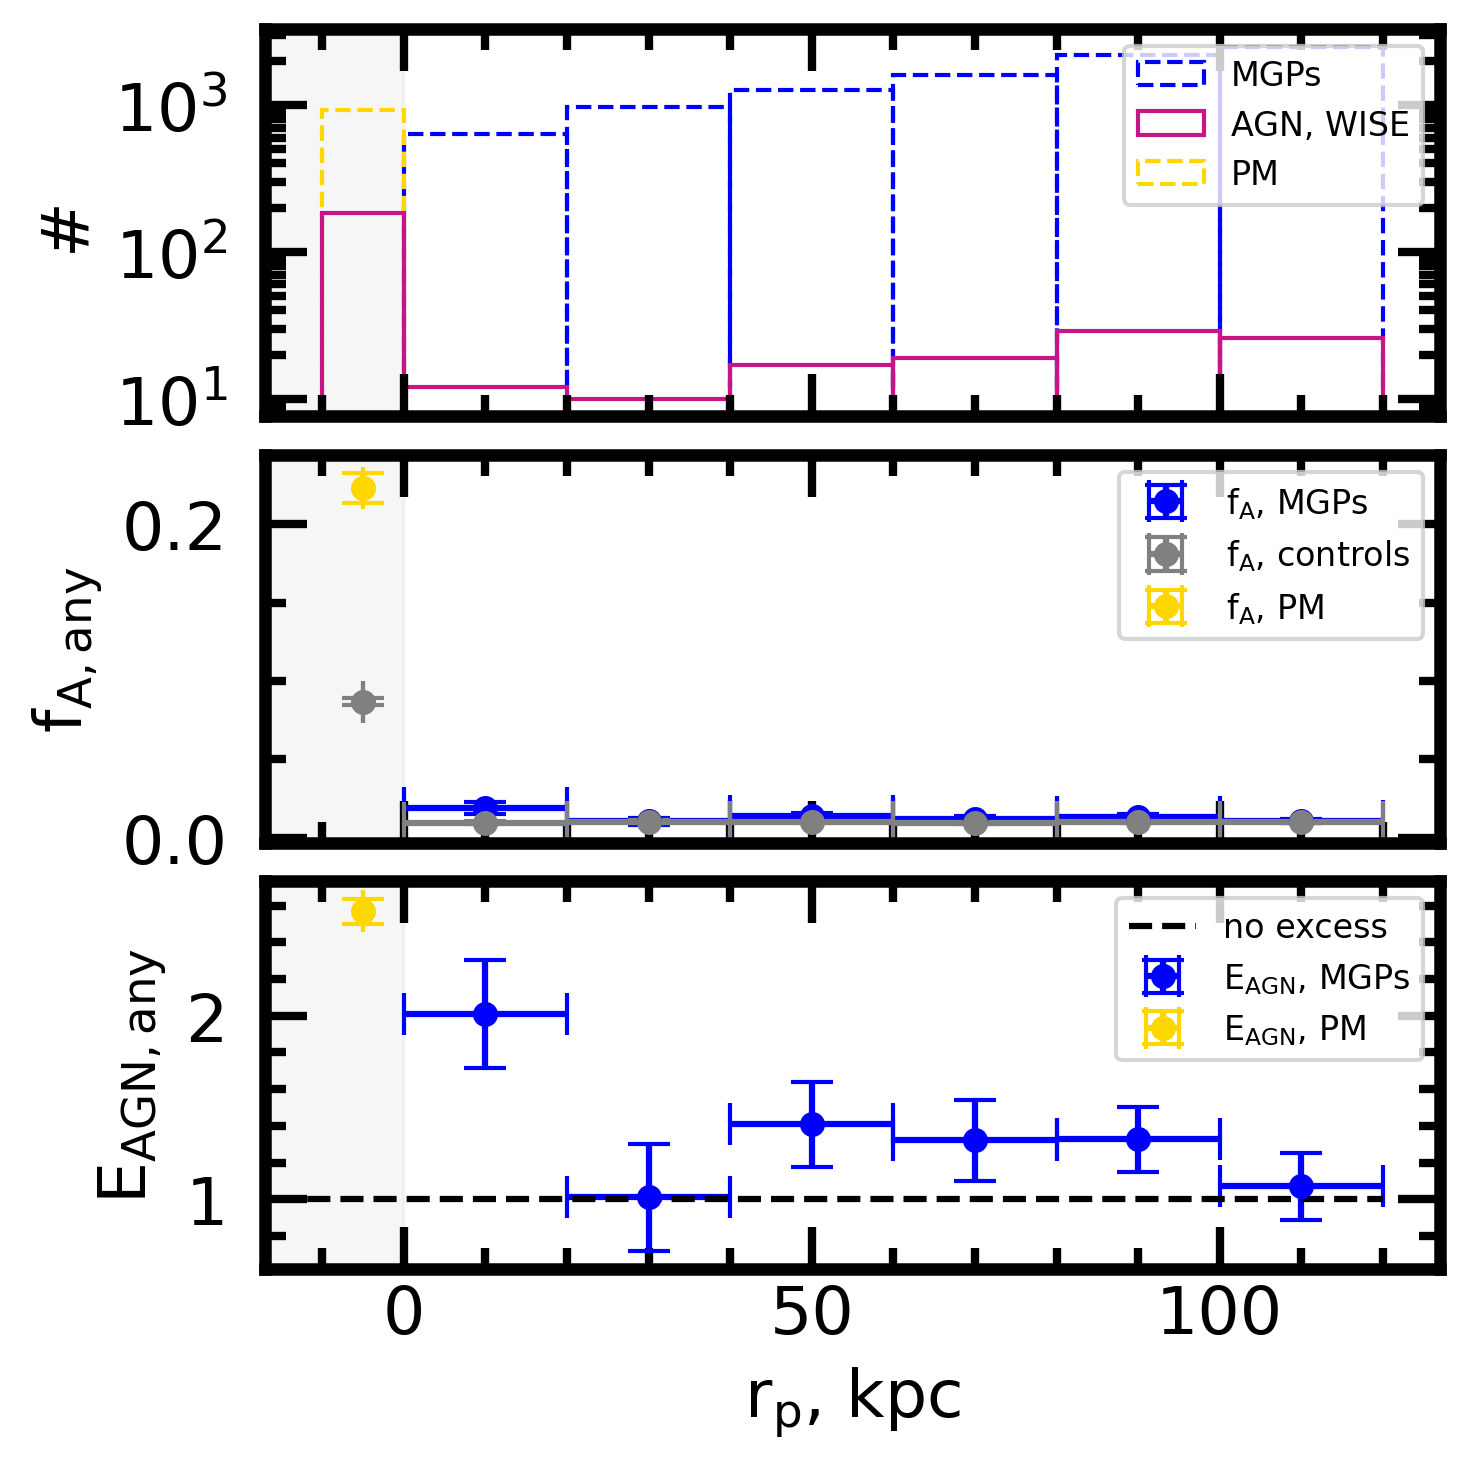

In [151]:
def calc_exc_ext_any(r):
    #print('doing {}'.format(str(r)))
    tar_samp = pd.read_csv('./nov6_match_track/tar_samp_strict_120_{}.csv'.format(str(r)))#df[(df['rp']>=rp_space_ext[r])&(df['rp']<rp_space_ext[r+1])&(df['logmass']>8)&(df['z_spec']>0.005)]
    ctrl_samp = pd.read_csv('./nov6_match_track/ctrl_samp_strict_120_{}.csv'.format(str(r)))#pd.DataFrame({},columns=[key for key in df.keys()])
    companion_samp = pd.read_csv('./nov6_match_track/companion_samp_strict_120_{}.csv'.format(str(r)))#pd.DataFrame({},columns=[key for key in df.keys()])
    tars = [row for ind,row in tar_samp.iterrows()]
    comps = [row for ind,row in companion_samp.iterrows()]
    ctrls = [row for ind,row in ctrl_samp.iterrows()]
    tar_data = []
    ctrl_data = []
    for batch in range(len(ctrls)//(2*len(tars))):
        for i in range(len(tars)):
            row = tars[i]
            companion = comps[i]
            match = ctrls[batch*len(tars)*2+2*i]
            match2 = ctrls[batch*len(tars)*2+2*i+1]
            #What L_X to add for the target galaxy pair?
            if batch==0: #only add the target LXs if it's the first pass through the data
                tLX1 = row['L_X_e']
                tLX2 = companion['L_X_e']
                tW1 = row['W1']-row['W2']
                tW2 = companion['W1']-companion['W2']
                bpt_pos = (row['OIII_5007_flux']>0)&(row['Halpha_flux']>0)&(row['Hbeta_flux']>0)&(row['Halpha_ew']<-6)
                if bpt_pos:
                    tBPT1 = 1 if (row['agn_sn']>5)&(row['new_K01_flag']=='AGN')&(np.isnan(match['BLR'])) else 0
                else:
                    tBPT1 = 0
                bpt_pos = (companion['OIII_5007_flux']>0)&(companion['Halpha_flux']>0)&(companion['Hbeta_flux']>0)&(companion['Halpha_ew']<-6)
                if bpt_pos:
                    tBPT2 = 1 if (companion['agn_sn']>5)&(companion['new_K01_flag']=='AGN')&(np.isnan(match['BLR'])) else 0
                else:
                    tBPT2 = 0
                tBLR1 = row['BLR']
                tBLR2 = companion['BLR']
                if tBPT1==1:
                    tar_data.append(1)
                else:
                    tar_data.append(0)
                if tBPT2==1:
                    tar_data.append(1)
                else:
                    tar_data.append(0)
            #Always add control LXs regardless of what round, since controls are unique
            cLX1 = match['L_X_e']
            cLX2 = match2['L_X_e']
            cW1 = match['W1']-match['W2']
            cW2 = companion['W1']-companion['W2']
            bpt_pos = (match['OIII_5007_flux']>0)&(match['Halpha_flux']>0)&(match['Hbeta_flux']>0)&(match['Halpha_ew']<-6)
            if bpt_pos:
                cBPT1 = 1 if (match['agn_sn']>5)&(match['new_K01_flag']=='AGN')&(np.isnan(match['BLR'])) else 0
            else:
                cBPT1 = 0
            bpt_pos = (match2['OIII_5007_flux']>0)&(match2['Halpha_flux']>0)&(match2['Hbeta_flux']>0)&(match2['Halpha_ew']<-6)
            if bpt_pos:
                cBPT2 = 1 if (match2['agn_sn']>5)&(match2['new_K01_flag']=='AGN')&(np.isnan(match2['BLR'])) else 0
            else:
                cBPT2 = 0
            cBLR1 = match['BLR']
            cBLR2 = match2['BLR']
            if cBPT1==1:
                ctrl_data.append(1)
            else:
                ctrl_data.append(0)
            if cBPT2==1:
                ctrl_data.append(1)
            else:
                ctrl_data.append(0)
    tar_data = np.array(tar_data)
    ctrl_data = np.array(ctrl_data)
    #print(len(tar_data),len(ctrl_data))
    #print('determining AGN statuses')
    #calculating target AGN fractions
    aft = len(tar_data[tar_data==1])/(len(tar_data))
    aft = 1-np.sqrt(1-2*aft)
    aft_err = np.sqrt(aft*(1-aft)/(2*(len(tar_data))))
    #calculating control agn fractions
    afc = len(ctrl_data[ctrl_data==1])/(len(ctrl_data))
    afc = 1-np.sqrt(1-2*afc)
    afc_err = np.sqrt(afc*(1-afc)/(2*(len(ctrl_data))))
    #print('aft = {}'.format(str(aft)))
    #print('aft_err = {}'.format(str(aft_err)))
    #print('afc = {}'.format(str(afc)))
    #print('afc_err = {}'.format(str(afc_err)))
    exc = aft/afc
    err = aft_err/aft+afc_err/afc
    print('exc {} = {}'.format(r,exc))
    #print('exc_err = {}'.format(str(aft_err/aft+afc_err/afc)))
    #format: [number of galaxies, number of AGN, AFTs, AFTes, AFCs, AFCes, excs, excerrs]
    return [len(tar_data),len(tar_data[tar_data==1]),aft,aft_err,afc,afc_err,exc,err]
rp_space_ext = np.linspace(0,120,7)
print(rp_space_ext)
p = Pool()
#data_ext_any = np.array(p.map(calc_exc_ext_any,range(len(rp_space_ext)-1)))
data_ext = np.array([calc_exc_ext_any(i) for i in range(len(rp_space_ext)-1)])
p.close()
p.join()

ngs_ext_any = data_ext[:,0]
nas_ext_any = data_ext[:,1]
afts_ext_any = data_ext[:,2]
aftes_ext_any = data_ext[:,3]
afcs_ext_any = data_ext[:,4]
afces_ext_any = data_ext[:,5]
excs_ext_any = data_ext[:,6]
exces_ext_any = data_ext[:,7]
exces2_ext_any = exces_ext_any#np.sqrt(2)*(aftes_ext/afts_ext+afces_ext/afcs_ext)
aftes2_ext_any = aftes_ext_any#np.sqrt(2)*aftes_ext
afces2_ext_any = afces_ext_any#np.sqrt(2)*afces_ext

ng_any,nagn_any,aft_any,afte_any,afc_any,afce_any,exc_any,exce_any = calc_exc_ext_pm_any()
rp_space_plot_ext = rp_space_ext[:-1]+10
fig,axs = plt.subplots(3,1,figsize=[5,5],dpi=300,sharex=True)
axs.flatten()[0].axvspan(-40,0,alpha=0.2, color='lightgray')
axs.flatten()[1].axvspan(-40,0,alpha=0.2, color='lightgray')
axs.flatten()[2].axvspan(-40,0,alpha=0.2, color='lightgray')
plt.xlim(-17,127)
#panel 1: number of galaxies & agn in each bin
axs.flatten()[0].bar(rp_space_plot_ext,ngs_ext_any,color='gray',edgecolor='blue',width=20,linestyle='dashed',label='MGPs',log=True,fill=False)
axs.flatten()[0].bar(rp_space_plot_ext,nas_ext_any,color='mediumvioletred',edgecolor='mediumvioletred',width=20,label='AGN, WISE',log=True,fill=False)
axs.flatten()[0].bar(-5,ng_any,color='gold',edgecolor='gold',linestyle='dashed',width=10,label='PM',log=True,fill=False)
axs.flatten()[0].bar(-5,nagn_any,color='mediumvioletred',edgecolor='mediumvioletred',width=10,log=True,fill=False)
axs.flatten()[0].set_ylabel('#')
axs.flatten()[0].legend(loc='upper right', fontsize=8)
#panel 2: fractions and errors of AGN in pair & control samples
axs.flatten()[1].errorbar(rp_space_plot_ext,afts_ext_any,xerr=10,yerr=aftes2_ext_any,color='blue',label='f$\mathrm{_{A}}$, MGPs',marker='o',markersize=5,capsize=5,linestyle='')
axs.flatten()[1].errorbar(rp_space_plot_ext,afcs_ext_any,xerr=10,yerr=afces2_ext_any,color='gray',label='f$\mathrm{_{A}}$, controls',marker='o',markersize=5,capsize=5,linestyle='')
axs.flatten()[1].errorbar(-5,aft_any,xerr=0,yerr=afte_any,color='gold',label='f$\mathrm{_{A}}$, PM',marker='o',markersize=5,capsize=5,linestyle='')
axs.flatten()[1].errorbar(-5,afc_any,xerr=0,yerr=afce_any,color='gray',marker='o',markersize=5,capsize=5,linestyle='')
axs.flatten()[1].legend(loc='upper right',fontsize=8)
axs.flatten()[1].set_ylabel('f$\mathrm{_{A, any}}$')
#panel 3: excess calcs
axs.flatten()[2].errorbar(rp_space_plot_ext,excs_ext_any,xerr=10,yerr=exces2_ext_any,color='blue',label='E$\mathrm{_{AGN}}$, MGPs',marker='o',markersize=5,capsize=5,linestyle='')
axs.flatten()[2].errorbar(-5,exc_any,xerr=0,yerr=exce_any,color='gold',label='E$\mathrm{_{AGN}}$, PM',marker='o',markersize=5,capsize=5,linestyle='')
axs.flatten()[2].hlines(1,-20,120,linestyle='dashed',color='black',label='no excess')
axs.flatten()[2].set_ylabel('$\mathrm{E_{AGN, any}}$')
axs.flatten()[2].set_xlabel('r$\mathrm{_{p}}$, kpc')
axs.flatten()[2].legend(loc='upper right',fontsize=8)
plt.tight_layout()
plt.subplots_adjust(hspace=0.1)
plt.show()

In [34]:
#OIII_L = np.array([np.log10((4*np.pi*cosmo.luminosity_distance(z)**2*1e-17*f*u.erg/u.s/u.cm**2).to(u.erg/u.s).value) for z,f in tqdm(zip(df['z_spec'],df['OIII_5007_flux']),total=len(df))])
Ha_L = np.array([np.log10((4*np.pi*cosmo.luminosity_distance(z)**2*1e-17*f*u.erg/u.s/u.cm**2).to(u.erg/u.s).value) for z,f in tqdm(zip(df['z_spec'],df['Halpha_flux']),total=len(df))])

  0%|          | 0/266307 [00:00<?, ?it/s]

/tmp/ipykernel_67/1020595747.py:2: RuntimeWarning: invalid value encountered in log10
  Ha_L = np.array([np.log10((4*np.pi*cosmo.luminosity_distance(z)**2*1e-17*f*u.erg/u.s/u.cm**2).to(u.erg/u.s).value) for z,f in tqdm(zip(df['z_spec'],df['Halpha_flux']),total=len(df))])
/tmp/ipykernel_67/1020595747.py:2: RuntimeWarning: divide by zero encountered in log10
  Ha_L = np.array([np.log10((4*np.pi*cosmo.luminosity_distance(z)**2*1e-17*f*u.erg/u.s/u.cm**2).to(u.erg/u.s).value) for z,f in tqdm(zip(df['z_spec'],df['Halpha_flux']),total=len(df))])


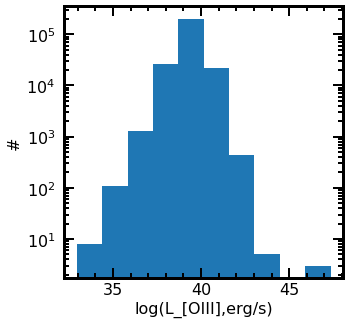

In [33]:
fig,axs = plt.subplots(figsize=[5,5])
ma = ~np.isinf(OIII_L)
plt.hist(OIII_L[ma],log=True)
plt.xlabel('log(L_[OIII],erg/s)')
plt.ylabel('#')
plt.show()

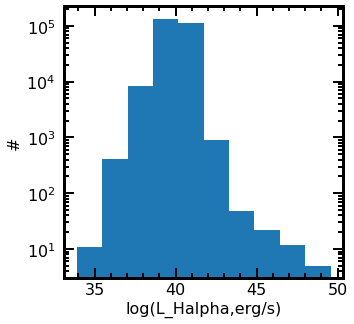

In [35]:
fig,axs = plt.subplots(figsize=[5,5])
ma = ~np.isinf(Ha_L)
plt.hist(Ha_L[ma],log=True)
plt.xlabel('log(L_Halpha,erg/s)')
plt.ylabel('#')
plt.show()

In [36]:
df['Ha_L']=Ha_L
df['OIII_L']=OIII_L

/tmp/ipykernel_67/829389458.py:42: RuntimeWarning: invalid value encountered in true_divide
  a = np.array(plot_data_b[1])/np.array(plot_data_n[1])


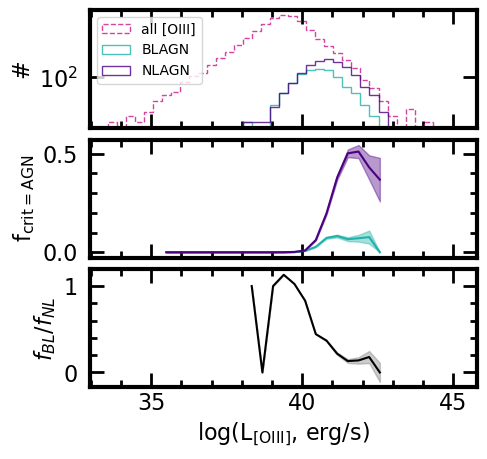

In [49]:
bpt_agn_mask = (df['agn_sn']>5)&(df['new_K01_flag']=='AGN')&(df['Halpha_ew']<-6)&(np.isnan(df['BLR']))
fig,axs = plt.subplots(3,1,figsize=[5,5],sharex=True,dpi=100)
def agn_frac(lxl,lxu,crit):
    den = len(df[~np.isinf(df['OIII_L'])&(df['OIII_L']>lxl)&(df['OIII_L']<lxu)&(df['z_spec']>0.005)&(df['logmass']>8)])
    num = len(df[~np.isinf(df['OIII_L'])&(df['OIII_L']>lxl)&(df['OIII_L']<lxu)&(crit)&(df['z_spec']>0.005)&(df['logmass']>8)])
    fr = num/den if den>10 else float('NaN')
    err = np.sqrt(fr*(1-fr)/den) if den>10 else float('NaN')
    return [fr,err]
def frac_series(crit,bins):
    xspace = np.linspace(np.amin(df['OIII_L'][~np.isinf(df['OIII_L'])&(df['z_spec']>0.005)&(df['logmass']>8)]),np.amax(df['OIII_L'][~np.isinf(df['OIII_L'])&(df['z_spec']>0.005)&(df['logmass']>8)]),bins)
    dxspace = np.array([(xspace[i+1]-xspace[i]) for i in range(len(xspace)-1)])
    xspace_plot = [xspace[i]+(xspace[i+1]-xspace[i])/2 for i in range(len(xspace)-1)]
    lxls = xspace[:-1]
    lxus = xspace[:-1]+dxspace
    dat = np.array([agn_frac(lxl,lxu,crit) for lxl,lxu in zip(lxls,lxus)])
    frs = dat[:,0]
    ers = dat[:,1]
    return [xspace_plot,frs,ers]
nbins = 40
plot_data = frac_series((df['BLR']==1),nbins)
axs.flatten()[1].plot(plot_data[0],plot_data[1],color='lightseagreen')
axs.flatten()[1].fill_between(plot_data[0],(plot_data[1]+plot_data[2]),(plot_data[1]-plot_data[2]),alpha=0.4,color='lightseagreen')
plot_data_b = plot_data
# plot_data = frac_series(((df['W1']-df['W2']>0.5)),nbins)
# axs.flatten()[1].plot(plot_data[0],plot_data[1],color='red')
# axs.flatten()[1].fill_between(plot_data[0],(plot_data[1]+plot_data[2]),(plot_data[1]-plot_data[2]),alpha=0.4,color='red')

plot_data = frac_series(bpt_agn_mask,nbins)
axs.flatten()[1].plot(plot_data[0],plot_data[1],color='indigo')
axs.flatten()[1].fill_between(plot_data[0],(plot_data[1]+plot_data[2]),(plot_data[1]-plot_data[2]),alpha=0.4,color='indigo')
plot_data_n = plot_data
# plot_data = frac_series((df['HERG']==1),nbins)
# axs.flatten()[1].plot(plot_data[0],plot_data[1],color='sienna')
# axs.flatten()[1].fill_between(plot_data[0],(plot_data[1]+plot_data[2]),(plot_data[1]-plot_data[2]),alpha=0.4,color='sienna')

bins = np.linspace(np.amin(df['OIII_L'][~np.isinf(df['OIII_L'])&(df['z_spec']>0.005)&(df['logmass']>8)]),np.amax(df['L_X_e'][(df['z_spec']>0.005)&(df['logmass']>8)]),nbins)
axs.flatten()[0].hist(df['OIII_L'][~np.isinf(df['OIII_L'])&(df['z_spec']>0.005)&(df['logmass']>8)],bins=bins,color='mediumvioletred',linestyle='dashed',histtype='step',log=True,alpha=0.8,label='all [OIII]')
axs.flatten()[0].hist(df['OIII_L'][~np.isinf(df['OIII_L'])&(df['BLR']==1)&(df['z_spec']>0.005)&(df['logmass']>8)],bins=bins,color='lightseagreen',histtype='step',log=True,alpha=0.8,label='BLAGN')
#axs.flatten()[0].hist(df['L_X_e'][(df['W1']-df['W2']>0.5)&(df['z_spec']>0.005)&(df['logmass']>8)],bins=bins,color='red',histtype='step',log=True,alpha=0.8,label='mIR')
axs.flatten()[0].hist(df['OIII_L'][~np.isinf(df['OIII_L'])&(bpt_agn_mask)&(df['z_spec']>0.005)&(df['logmass']>8)],bins=bins,color='indigo',histtype='step',log=True,alpha=0.8,label='NLAGN')

a = np.array(plot_data_b[1])/np.array(plot_data_n[1])
axs.flatten()[2].plot(plot_data[0],a,color='black')
e = np.sqrt(np.array(plot_data_b[2])**2+np.array(plot_data_n[2])**2)
axs.flatten()[2].fill_between(plot_data[0],(a+e),(a-e),alpha=0.4,color='gray')

axs.flatten()[0].legend(loc='upper left',fontsize=10)
axs.flatten()[2].set_xlabel('log(L$\mathrm{_{[OIII]}}$, erg/s)')
axs.flatten()[1].set_ylabel('$\mathrm{f_{crit=AGN}}$')
axs.flatten()[2].set_ylabel('$f_{BL}/f_{NL}$')
axs.flatten()[0].set_ylabel('#')
plt.subplots_adjust(hspace=0.1)
plt.show()

/tmp/ipykernel_67/2679440654.py:42: RuntimeWarning: invalid value encountered in true_divide
  a = np.array(plot_data_b[1])/np.array(plot_data_n[1])


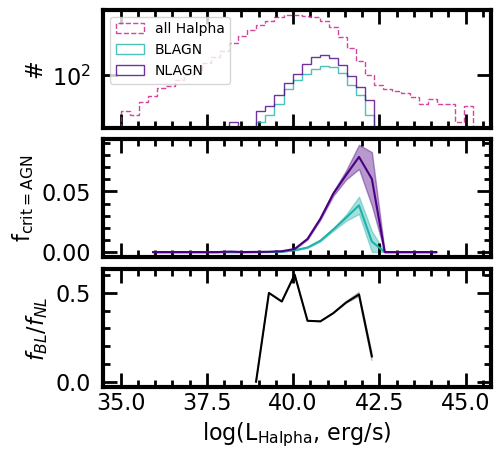

In [50]:
bpt_agn_mask = (df['agn_sn']>5)&(df['new_K01_flag']=='AGN')&(df['Halpha_ew']<-6)&(np.isnan(df['BLR']))
fig,axs = plt.subplots(3,1,figsize=[5,5],sharex=True,dpi=100)
def agn_frac(lxl,lxu,crit):
    den = len(df[~np.isinf(df['Ha_L'])&(df['Ha_L']>lxl)&(df['Ha_L']<lxu)&(df['z_spec']>0.005)&(df['logmass']>8)])
    num = len(df[~np.isinf(df['Ha_L'])&(df['Ha_L']>lxl)&(df['Ha_L']<lxu)&(crit)&(df['z_spec']>0.005)&(df['logmass']>8)])
    fr = num/den if den>10 else float('NaN')
    err = np.sqrt(fr*(1-fr)/den) if den>10 else float('NaN')
    return [fr,err]
def frac_series(crit,bins):
    xspace = np.linspace(np.amin(df['Ha_L'][~np.isinf(df['Ha_L'])&(df['z_spec']>0.005)&(df['logmass']>8)]),np.amax(df['Ha_L'][~np.isinf(df['Ha_L'])&(df['z_spec']>0.005)&(df['logmass']>8)]),bins)
    dxspace = np.array([(xspace[i+1]-xspace[i]) for i in range(len(xspace)-1)])
    xspace_plot = [xspace[i]+(xspace[i+1]-xspace[i])/2 for i in range(len(xspace)-1)]
    lxls = xspace[:-1]
    lxus = xspace[:-1]+dxspace
    dat = np.array([agn_frac(lxl,lxu,crit) for lxl,lxu in zip(lxls,lxus)])
    frs = dat[:,0]
    ers = dat[:,1]
    return [xspace_plot,frs,ers]
nbins = 40
plot_data = frac_series((df['BLR']==1),nbins)
axs.flatten()[1].plot(plot_data[0],plot_data[1],color='lightseagreen')
axs.flatten()[1].fill_between(plot_data[0],(plot_data[1]+plot_data[2]),(plot_data[1]-plot_data[2]),alpha=0.4,color='lightseagreen')
plot_data_b = plot_data
# plot_data = frac_series(((df['W1']-df['W2']>0.5)),nbins)
# axs.flatten()[1].plot(plot_data[0],plot_data[1],color='red')
# axs.flatten()[1].fill_between(plot_data[0],(plot_data[1]+plot_data[2]),(plot_data[1]-plot_data[2]),alpha=0.4,color='red')

plot_data = frac_series(bpt_agn_mask,nbins)
axs.flatten()[1].plot(plot_data[0],plot_data[1],color='indigo')
axs.flatten()[1].fill_between(plot_data[0],(plot_data[1]+plot_data[2]),(plot_data[1]-plot_data[2]),alpha=0.4,color='indigo')
plot_data_n = plot_data
# plot_data = frac_series((df['HERG']==1),nbins)
# axs.flatten()[1].plot(plot_data[0],plot_data[1],color='sienna')
# axs.flatten()[1].fill_between(plot_data[0],(plot_data[1]+plot_data[2]),(plot_data[1]-plot_data[2]),alpha=0.4,color='sienna')

bins = np.linspace(np.amin(df['Ha_L'][~np.isinf(df['Ha_L'])&(df['z_spec']>0.005)&(df['logmass']>8)]),np.amax(df['L_X_e'][(df['z_spec']>0.005)&(df['logmass']>8)]),nbins)
axs.flatten()[0].hist(df['Ha_L'][~np.isinf(df['Ha_L'])&(df['z_spec']>0.005)&(df['logmass']>8)],bins=bins,color='mediumvioletred',linestyle='dashed',histtype='step',log=True,alpha=0.8,label='all Halpha')
axs.flatten()[0].hist(df['Ha_L'][~np.isinf(df['Ha_L'])&(df['BLR']==1)&(df['z_spec']>0.005)&(df['logmass']>8)],bins=bins,color='lightseagreen',histtype='step',log=True,alpha=0.8,label='BLAGN')
#axs.flatten()[0].hist(df['L_X_e'][(df['W1']-df['W2']>0.5)&(df['z_spec']>0.005)&(df['logmass']>8)],bins=bins,color='red',histtype='step',log=True,alpha=0.8,label='mIR')
axs.flatten()[0].hist(df['Ha_L'][~np.isinf(df['Ha_L'])&(bpt_agn_mask)&(df['z_spec']>0.005)&(df['logmass']>8)],bins=bins,color='indigo',histtype='step',log=True,alpha=0.8,label='NLAGN')

a = np.array(plot_data_b[1])/np.array(plot_data_n[1])
axs.flatten()[2].plot(plot_data[0],a,color='black')
e = np.sqrt(np.array(plot_data_b[2])**2+np.array(plot_data_n[2])**2)
axs.flatten()[2].fill_between(plot_data[0],(a+e),(a-e),alpha=0.4,color='gray')

axs.flatten()[0].legend(loc='upper left',fontsize=10)
axs.flatten()[2].set_xlabel('log(L$\mathrm{_{Halpha}}$, erg/s)')
axs.flatten()[1].set_ylabel('$\mathrm{f_{crit=AGN}}$')
axs.flatten()[2].set_ylabel('$f_{BL}/f_{NL}$')
axs.flatten()[0].set_ylabel('#')
plt.subplots_adjust(hspace=0.1)
plt.show()

In [11]:
def get_hw(z):
    #for CFIS, returns the number of pixels corresponding to 50kpc at a given redshift                                                                                                    
    cosmo = FlatLambdaCDM(H0=70,Om0=0.3)
    CCD_scale = 0.262 #arcsec/pix                                                                                                                                                         
    kpc_per_arcsec = cosmo.kpc_proper_per_arcmin(z).value/60. #kpc/arcsec                                                                                                                 
    hw = 25/kpc_per_arcsec/CCD_scale
    return hw

def getCutoutImage(ra,dec,z,objID):
    # Gets the cutout image                                                                                                                                                               
    hw = int(np.around(get_hw(z)))
    #print(hw)
    #print(ra,dec,z)
    url = 'https://www.legacysurvey.org/viewer/cutout.fits?ra={}&dec={}&layer=ls-dr10&pixscale=0.262&bands=gri&size={}'.format(ra,dec,str(2*hw))
    r = requests.get(url, allow_redirects=True)
    cutoutName = './decals_cutouts/Cutout_Temp.fits'
    open(cutoutName, "wb").write(r.content)
    hdul = fits.open(cutoutName)
    image = hdul[0].data
    os.remove(cutoutName)
    return objID, image, url, z
import requests

0it [00:00, ?it/s]

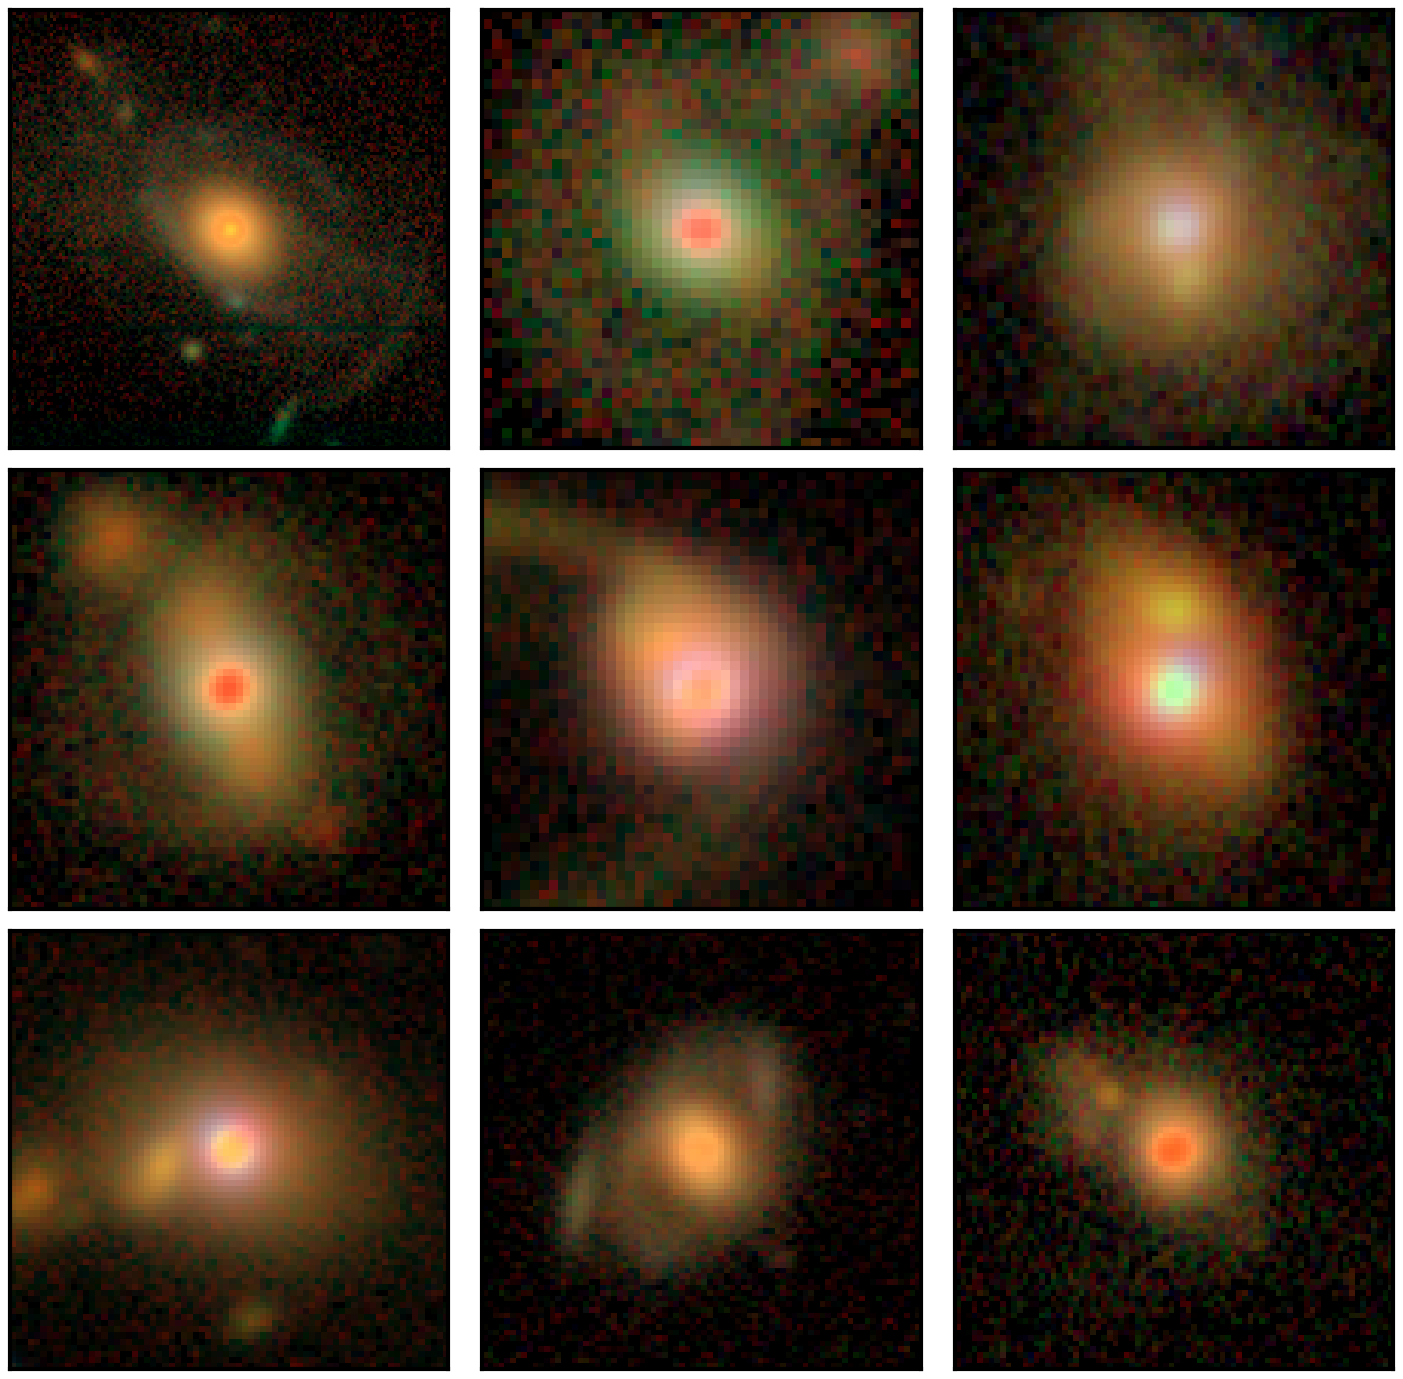

In [30]:
fig,axs = plt.subplots(3,3,figsize=[18,18],dpi=100)
bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.6)
blowout_pairs = df[(df['PM']==1)&(df['z_spec']>0.005)&(df['logmass']>8)&(df['L_X_e']>0)&(df['BLR']==1)]
for ax,num in tqdm(zip(axs.flatten(),np.arange(0,13)[~(np.arange(0,13)==0)&~(np.arange(0,13)==1)&~(np.arange(0,13)==3)&~(np.arange(0,13)==6)])):
    o,im,url,z = getCutoutImage(blowout_pairs['ra'].iloc[num],blowout_pairs['decl'].iloc[num],blowout_pairs['z_spec'].iloc[num],blowout_pairs['objID'].iloc[num])
    g,r,i = im[0],im[1],im[2]
    image = make_lupton_rgb(i,r,g,stretch=0.075)
    ax.imshow(image)
    #ax.imshow(np.log10(image-np.amin(image)+0.0001))
    #ax.text(.05, .95, 'ID={}\n$z$={:.2f}'.format(o,z), transform=ax.transAxes, ha="left", va="top",fontsize=5,bbox=bbox_props)
    ax.tick_params(axis='both', which='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')
plt.subplots_adjust(hspace=0.05,wspace=0.05)
plt.show()

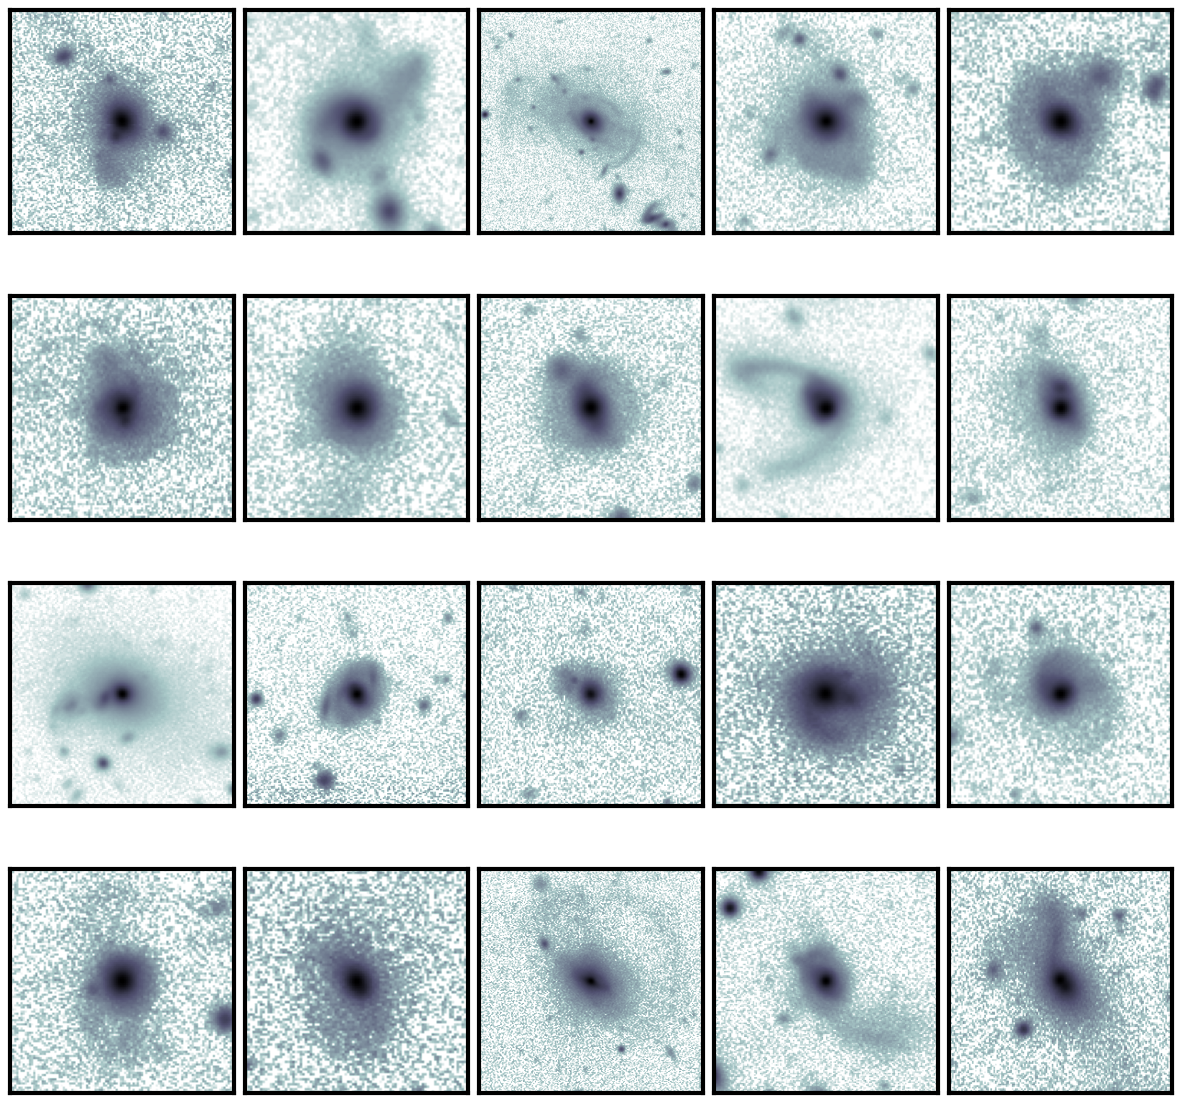

In [33]:
#maybe the PM mosaic first?
#To do this efficiently, I need to load in the pre-BLR version of the df to find the images in the saved pickles.
#prepare the chunked df
# db = pymysql.connect(host='lauca.phys.uvic.ca',db='sdss',user='rbickley',passwd='123Sdss!@#h')
# dbcmd = 'select u.objID,u.ra,u.decl,u.z_spec,u.total_mass_med from dr7_uberuber u where z_spec is not null and z_spec>0 and z_spec<=0.3 and total_mass_med is not null'
# c = db.cursor()
# c.execute(dbcmd)
# db_data = c.fetchall()
# c.close()

# objIDs = [i[0] for i in db_data]
# ras = [i[1] for i in db_data]
# decls = [i[2] for i in db_data]
# zs = [i[3] for i in db_data]
# masses = [i[4] for i in db_data]
# img_df = pd.DataFrame({'objID':objIDs,'ra':ras,'decl':decls,'z_spec':zs, 'total_mass_med':masses})

# dr7_gal_coords = SkyCoord(img_df['ra'],img_df['decl'],unit=u.deg,frame='icrs').galactic
# img_df['gal_l']=dr7_gal_coords.l.deg
# img_df['gal_b']=dr7_gal_coords.b.deg
# img_df = img_df[(img_df['decl']<32.37280239)&(img_df['gal_l']>179.94423568)&(img_df['gal_l']<359.94423568)]
# chunked_df = np.array_split(img_df,265)
# nums = np.arange(265)

# #prepare the chunked df
# db = pymysql.connect(host='lauca.phys.uvic.ca',db='sdss',user='rbickley',passwd='123Sdss!@#h')
# dbcmd = 'select u.objID,u.ra,u.decl,u.z_spec,u.total_mass_med from dr7_uberuber u where z_spec is not null and z_spec>0 and z_spec<=0.3'
# c = db.cursor()
# c.execute(dbcmd)
# db_data = c.fetchall()
# c.close()

# objIDs = [i[0] for i in db_data]
# ras = [i[1] for i in db_data]
# decls = [i[2] for i in db_data]
# zs = [i[3] for i in db_data]
# masses = [i[4] for i in db_data]
# img_df_nm = pd.DataFrame({'objID':objIDs,'ra':ras,'decl':decls,'z_spec':zs, 'total_mass_med':masses})

# dr7_gal_coords = SkyCoord(img_df_nm['ra'],img_df_nm['decl'],unit=u.deg,frame='icrs').galactic
# img_df_nm['gal_l']=dr7_gal_coords.l.deg
# img_df_nm['gal_b']=dr7_gal_coords.b.deg
# img_df_nm = img_df_nm[(img_df_nm['decl']<32.37280239)&(img_df_nm['gal_l']>179.94423568)&(img_df_nm['gal_l']<359.94423568)&(np.isnan(img_df_nm['total_mass_med']))]

# chunked_df_2 = np.array_split(img_df_nm,16)
# nums_2 = np.arange(16)

# def lookup_img(objID):
#     found_index = 999
#     for idx, chunk in zip(nums,chunked_df):
#         if objID in chunk['objID'].tolist():
#             found_index = idx
#             break
#     if found_index != 999:
#         with open('/arc/projects/MachineLearning/Bobby/decals_cutouts/decals_cutouts_{}.pkl'.format(str(found_index)), 'rb') as fp:
#             img_dict = pickle.load(fp)
#             return(img_dict[objID])
#     else:
#         for idx, chunk in zip(nums_2,chunked_df_2):
#             if objID in chunk['objID'].tolist():
#                 found_index = idx
#                 break
#         with open('/arc/home/rbickley/nomass_cutouts/decals_cutouts_nomass_{}.pkl'.format(str(found_index)), 'rb') as fp:
#             img_dict = pickle.load(fp)
#             return(img_dict[objID])

        

# zs = df['z_spec'][(df['PM']==1)&(df['z_spec']>0.005)&(df['logmass']>8)&(df['L_X_e']>0)&(df['BLR']==1)].tolist()[:20]
# oids = df['objID'][(df['PM']==1)&(df['z_spec']>0.005)&(df['logmass']>8)&(df['L_X_e']>0)&(df['BLR']==1)].tolist()[:20]
# print(len(zs))
# print(len(oids))
# ims = [lookup_img(i) for i in tqdm(oids)]
fig,axs = plt.subplots(4,5,figsize=[15,15],dpi=100)
# bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.6)
for ax,z,o,i in zip(axs.flatten(),zs,oids,ims):
    im = np.array(i).clip(min=0)
    mean = np.mean(im.flatten())
    std = np.std(im.flatten())
    im = (im-mean)/std
    im = im - np.amin(im)+0.01
    ax.imshow(np.log10(im),cmap='bone_r')
    #ax.text(.08, .92, '$z$={:.2f}'.format(z), transform=ax.transAxes, ha="left", va="top",fontsize=10,bbox=bbox_props)
    ax.tick_params(axis='both', which='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')
plt.subplots_adjust(hspace=0.05,wspace=0.05)
plt.show()

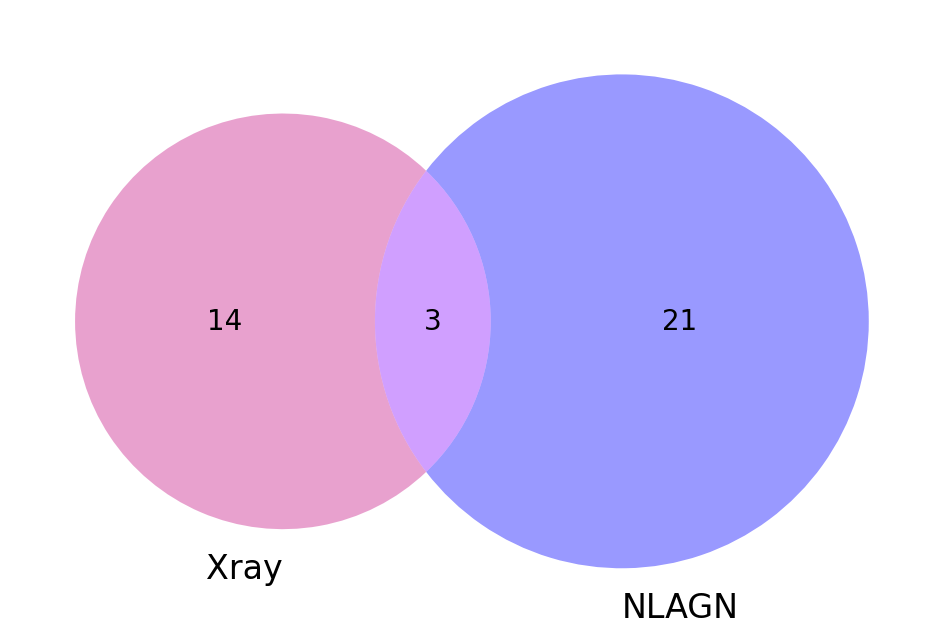

In [4]:
import matplotlib.pyplot as plt
#for the second Venn type with proportional areas for a given category
#you might need to run pip install matplotlib-venn in the command line
from matplotlib_venn import venn2

#figure 13 has a lot of elements, so i'll provide a minimal working example for the venn diagram part only
#make a figure
fig,axs = plt.subplots(figsize=[6,4],dpi=200)

Ab = 14 #some number, objects belonging to category A but not category B
AB = 3 #some number, belonging to both categories A and B
aB = 21 #some number, belonging to B but not A

c = venn2([Ab,aB,AB],ax=axs,set_labels=('Xray','NLAGN'),set_colors=['mediumvioletred','blue'])
plt.show()

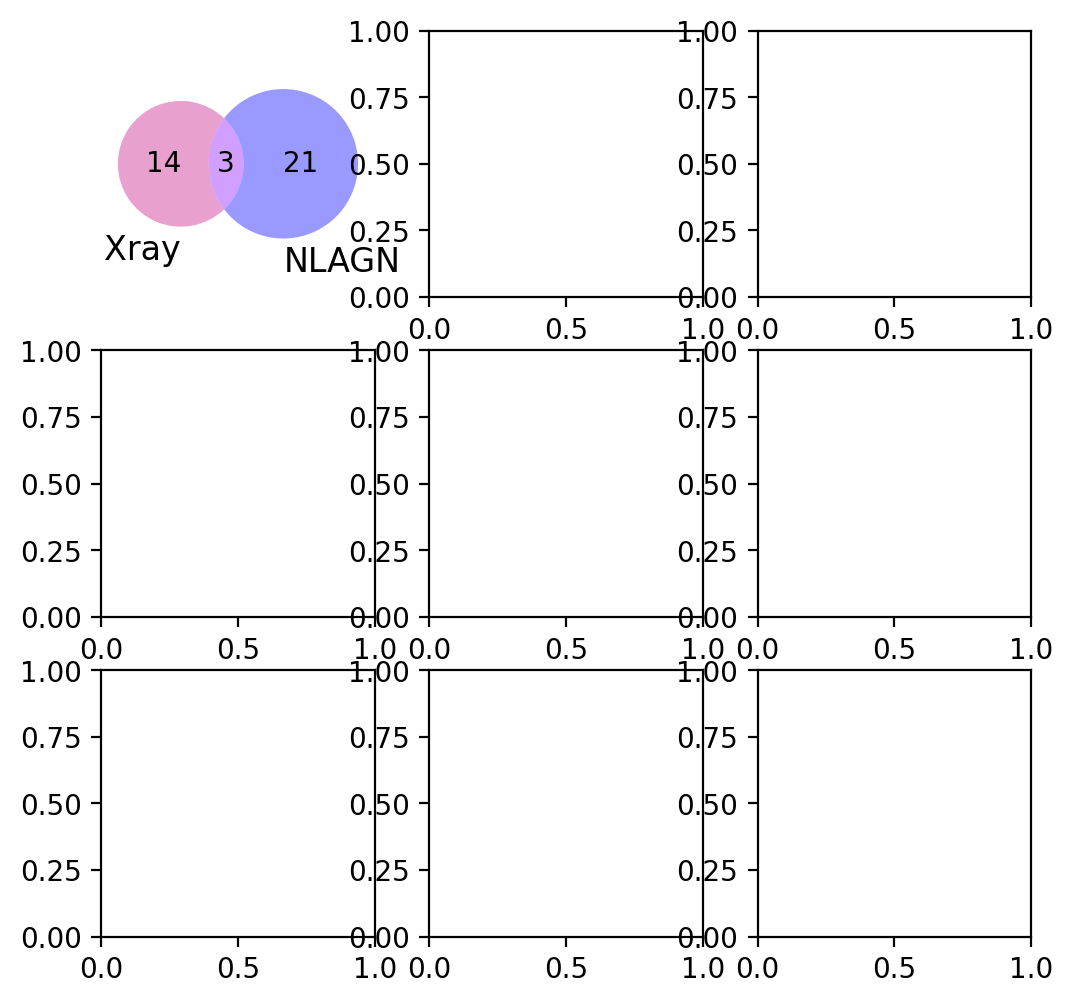

In [5]:
import matplotlib.pyplot as plt
#for the second Venn type with proportional areas for a given category
#you might need to run pip install matplotlib-venn in the command line
from matplotlib_venn import venn2

#figure 13 has a lot of elements, so i'll provide a minimal working example for the venn diagram part only
#make a figure
fig,axs = plt.subplots(3,3,figsize=[6,6],dpi=200)

Ab = 14 #some number, objects belonging to category A but not category B
AB = 3 #some number, belonging to both categories A and B
aB = 21 #some number, belonging to B but not A

c = venn2([Ab,aB,AB],ax=axs.flatten()[0],set_labels=('Xray','NLAGN'),set_colors=['mediumvioletred','blue'])
plt.show()